##** Predicting Media Memorability: MediaEval 2018**
MediaEval is Benchmarking Initiative for Multimedia Evaluation. Every year they organize competetions with new datasets and Machine learning tasks. Predicting video memorability is one of the tasks in 2018.

**Task description:** 
The task concentrates on the issue of predicting how memorable a video is to viewers. Participants are required to training computational models that have the capability of automatically predicting videos’ memorability scores reflecting the probability a video will be remembered from visual content. Video captions or title descriptions attached to the videos are not allowed to be used. Spearman’s ranking correlation will be employed as an evaluation metric in ranking task.

Reference: http://ceur-ws.org/Vol-2283/MediaEval_18_paper_1.pdf

Contact Information:  If you have any questions in running this script, Below is my contact details:

dao.nguyen7@mail.dcu.ie


**This notebook is organized as follows:**

**SECTION 1**   : Function Definitions

**SECTION 2**   : Loading Features

**SECTION 3**   : Experiments with different Machine Learning models and 
features/combinations


  Section 3.1: Prediction models using single features


1.   C3D
2.   HMP
3. ColorHist
4. InceptionV3
5. Aesthetic
6. LBP



  Section 3.2: Prediction models using single features preprocessed with PCA
1.   C3D
2.   HMP
3. ColorHist
4. InceptionV3
5. Aesthetic
6. LBP

Section 3.3: Prediction models using multi features
1.   C3D
2.   HMP
3. ColorHist
4. InceptionV3
5. Aesthetic
6. LBP

**SECTION 4**  : Selecting the best model with features

**SECTION 5**  : Predicting the Memorability scores on Test-Set

  Section 5.1: Training full 6000 Dev-Set

  Section 5.2: Importing Test Datasets

  Section 5.3: Predicting the Scores and Exporting the Results

**Importing** necessary libraries

In [1]:
# data analysis packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from pathlib import Path
from keras import Sequential
from keras import layers
from keras import regularizers
#import pyprind
from collections import Counter
# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
#from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

In [3]:
# connect information in the google drive to this colab session

from google.colab import drive
drive.mount('/content/drive/')

import os
os.chdir("/content/drive/MyDrive/CA684_Assignment/Dev-set")

Mounted at /content/drive/


In [ ]:
!pwd

/content/drive/.shortcut-targets-by-id/1UWIdExqb5P94RLqkaiODcwFC2v7g3lB2/CA684_Assignment/Dev-set


In [ ]:
# List all files available
!ls

'Aesthetic Features'   HMP				     ORB
 C3D		       HOG				     README.txt
 Captions	       InceptionV3			     Sources
 ColorHistogram        LBP
 Ground-truth	       MemorabilityDataset2018_license.txt


In [ ]:


videos = sorted(Path('/content/drive/MyDrive/CA684_Assignment/Complete_Sources').iterdir())


print("there are {} videos\n".format(len(videos)))
# list first 10 videos
videos[:10]

# Section 1: Function Definitions

In [22]:
def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])


In [ ]:
def read_C3D(fname):
    """Scan vectors from file"""
    with open(fname) as f:
        for line in f:
            C3D =[float(item) for item in line.split()] # convert to float type, using default separator
    return C3D

In [ ]:
def read_LBP(fname):
    """Scan vectors from file"""
    with open(fname) as f:
        for line in f:
            LBP =[float(item) for item in line.split()] # convert to float type, using default separator
    return LBP

In [ ]:
def read_HMP(fname):
    """Scan HMP(Histogram of Motion Patterns) features from file"""
    with open(fname) as f:
        for line in f:
            pairs=line.split()
            HMP_temp = { int(p.split(':')[0]) : float(p.split(':')[1]) for p in pairs}
    # there are 6075 bins, fill zeros
    HMP = np.zeros(6075)
    for idx in HMP_temp.keys():
        HMP[idx-1] = HMP_temp[idx]            
    return HMP

In [ ]:
def read_ColorHistogram(fname):
    """Scan Color Histogram from file
    Input file contains RGB histogram,
    Return a matrix of (3,256)"""
    RGB_Hist = np.zeros((3,256))
    with open(fname) as f:
        i_l = 0 # line index
        for line in f:
            pairs = line.split()
            hist_dict = {int(p.split(':')[0]):float(p.split(':')[1]) for p in pairs}
            for idx in hist_dict.keys():
                RGB_Hist[i_l,idx] = hist_dict[idx]
            i_l += 1
    return RGB_Hist

In [ ]:
def parse_inception_feature(s):
    pairs = s.strip().split(' ')
    pairs = [i.split(':') for i in pairs]
    return {int(k): float(v) for k, v in pairs}
def expand_inception_feature(d):
  feature = np.zeros(1000)
  for k, v in d.items():
    feature[k] = v
  return feature


In [ ]:
def read_aesthetic(fname):
    """Scan vectors from file"""
    with open(fname) as f:
        for line in f:
            aesthetic =[float(item) for item in line.split(',')] # convert to float type
    return aesthetic

In [ ]:
def read_orb_1frame(frame):
  orb_list = []
  for x in range(0,500):
    orb_list.append(frame[x][0][0])
    orb_list.append(frame[x][0][1])
    for i in range(1,6):
      orb_list.append(frame[x][i])
    for i in frame[x][6]:
      orb_list.append(i)

  return orb_list

# GROUND_TRUTH

In [ ]:
ground_truth = pd.read_csv('Ground-truth/ground-truth.csv')

In [ ]:
len(ground_truth)

6000

In [ ]:
ground_truth.head()

In [ ]:
ground_truth.corr()

In [ ]:

ground_truth = ground_truth.drop(['nb_short-term_annotations', 'nb_long-term_annotations'], axis=1)

In [ ]:

ground_truth.head()

,video,short-term_memorability,long-term_memorability
0,video3.webm,0.924,0.846
1,video4.webm,0.923,0.667
2,video6.webm,0.863,0.700
3,video8.webm,0.922,0.818
4,video10.webm,0.950,0.900


# Section 2: Loading Features

## C3D


In [ ]:
my_numlist= [] # Creating new list to store the C3D features
my_namelist = [] #Creating a new list to store the names of the videos
path = 'C3D/*.txt'
for filename in glob.glob('C3D_test/*.txt'):
    s= read_C3D(filename)
    my_numlist.append(s)
    my_namelist.append(((filename.split('/')[-1]).split('.')[0])+ '.webm') 
#adding .webm to the name to make it similar to the video name in ground truth

In [ ]:
len(my_numlist[0]) #All 101 features have been captured

101

In [ ]:
len(my_numlist)

2000

In [ ]:
c3d = pd.DataFrame(np.array(my_numlist).reshape(6000,101))
c3d["video"] = my_namelist
#creating new column as video and assigning the names of the vidoes

In [ ]:
# For test-set
c3d = pd.DataFrame(np.array(my_numlist).reshape(2000,101))
c3d["video"] = my_namelist
#creating new column as video and assigning the names of the vidoes

In [ ]:
c3d.head() 
#includes video names and captions, which will help further while merging these features with ground truth

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,video
0,0.003526,0.001376,0.046187,0.000008,0.000041,0.000295,0.000343,0.000406,0.000070,0.000015,3.539800e-04,0.000599,0.000349,0.004517,0.000016,5.500000e-05,0.000057,1.536000e-05,0.000014,0.000145,4.290000e-06,0.153209,6.900000e-07,0.000029,2.325810e-03,0.000133,0.002068,0.000012,0.000026,0.000155,0.000009,0.000481,0.000143,3.594800e-04,1.008580e-03,0.000114,0.000044,1.411000e-05,0.000449,0.000032,...,2.487600e-04,0.000621,0.000640,0.012609,0.000678,0.000394,0.003184,0.000016,0.000394,1.934000e-05,0.000813,0.002481,0.000004,0.000019,4.920000e-06,0.001956,0.000003,0.000026,0.000065,0.000133,0.000653,0.000057,0.000097,0.001134,0.000240,0.000036,0.000022,0.000057,0.000495,1.142530e-03,3.210800e-04,1.673800e-04,5.811330e-03,0.000252,4.400000e-07,0.000568,0.000051,0.000067,0.682813,video8768.webm
1,0.007772,0.002302,0.003671,0.000048,0.000017,0.000018,0.000262,0.000129,0.000079,0.000027,1.174700e-04,0.000437,0.003945,0.000028,0.000009,8.433700e-04,0.000109,1.924000e-05,0.000801,0.000013,3.240000e-06,0.001053,1.023580e-03,0.000054,1.441502e-02,0.000020,0.000030,0.000087,0.000483,0.001210,0.000081,0.000505,0.001729,1.730700e-04,1.497600e-04,0.000126,0.000186,1.690800e-04,0.000468,0.000121,...,1.655870e-03,0.003851,0.000111,0.001212,0.000126,0.000012,0.000106,0.000187,0.000111,3.797700e-04,0.000039,0.000077,0.000036,0.000649,6.266000e-05,0.000469,0.000024,0.001465,0.234685,0.000473,0.000303,0.000665,0.000614,0.000067,0.000004,0.001427,0.000002,0.000192,0.001640,1.099100e-03,2.225000e-04,1.110000e-05,8.693400e-04,0.000065,6.150000e-06,0.000271,0.017517,0.666933,0.002858,video8759.webm
2,0.001573,0.001398,0.071723,0.000025,0.000019,0.000827,0.006838,0.000136,0.000029,0.000239,5.657900e-04,0.000672,0.000265,0.000454,0.000013,3.156000e-04,0.000511,8.040000e-06,0.000010,0.000004,1.034000e-05,0.001801,1.660000e-06,0.000047,4.602800e-04,0.000031,0.000425,0.000133,0.001446,0.000248,0.000171,0.000055,0.006299,2.643500e-04,5.318000e-05,0.000003,0.000084,3.717900e-04,0.000109,0.000013,...,3.979090e-03,0.003753,0.002594,0.003642,0.030717,0.003481,0.000595,0.000011,0.000506,1.954000e-04,0.000053,0.000353,0.000009,0.000182,9.014000e-05,0.000233,0.001900,0.000345,0.000182,0.000258,0.001014,0.000054,0.000069,0.000193,0.001410,0.000869,0.000014,0.000086,0.001698,4.608000e-05,1.467470e-03,1.279700e-04,1.019300e-04,0.000007,3.577000e-05,0.001544,0.000034,0.000837,0.804485,video8762.webm
3,0.000358,0.003973,0.008803,0.007741,0.000403,0.000194,0.009095,0.017529,0.000285,0.000026,3.279300e-04,0.013337,0.000007,0.000169,0.000122,6.851600e-04,0.000816,3.790000e-06,0.001249,0.000297,1.730540e-03,0.017458,4.575800e-04,0.011841,6.208798e-02,0.000916,0.000033,0.001933,0.001350,0.003050,0.000202,0.138158,0.002006,2.664000e-05,1.112671e-02,0.028939,0.007646,1.535432e-02,0.006985,0.000424,...,8.891300e-04,0.001144,0.003669,0.006591,0.000239,0.004588,0.003227,0.000484,0.000935,6.927425e-02,0.000498,0.016600,0.000226,0.086639,1.025600e-04,0.001129,0.000026,0.004527,0.003472,0.045509,0.006680,0.001158,0.001092,0.019399,0.001620,0.004252,0.003154,0.000559,0.014796,1.822863e-02,5.824094e-02,2.662220e-03,2.824549e-02,0.000521,5.476000e-05,0.002431,0.000706,0.045552,0.001591,video8765.webm
4,0.000001,0.000012,0.000025,0.000012,0.000058,0.000572,0.000002,0.000002,0.000030,0.000003,1.400000e-07,0.001003,0.000391,0.000002,0.000004,7.800000e-07,0.000008,8.700000e-07,0.000134,0.000001,9.800000e-07,0.069743,3.310000e-06,0.000528,2.800000e-07,0.000045,0.000013,0.000007,0.000002,0.000002,0.031410,0.000437,0.000003,1.300000e-07,2.000000e-08,0.000045,0.000117,4.900000e-07,0.000001,0.000001,...,6.500000e-07,0.000005,0.000036,0.000022,0.000002,0.000051,0.000002,0.000019,0.000003,4.000000e-07,0.000324,0.869472,0.000120,0.005333,2.000000e-08,0.000001,0.0

In [ ]:

c3d_df = pd.merge(ground_truth, c3d, on='video')

In [ ]:

c3d_df.head()

,video,short-term_memorability,long-term_memorability,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,video3.webm,0.924,0.846,0.020249,0.001578,0.000826,0.000945,0.000063,0.000003,0.001162,0.000097,0.000022,0.000010,0.000337,0.000636,1.111700e-04,0.001008,0.000004,0.000631,3.905000e-05,0.000041,0.000091,0.000303,1.541000e-05,0.000032,5.221000e-05,0.000062,0.017465,0.000666,0.000065,0.000054,0.000273,0.001386,0.000003,0.001356,0.000517,2.426120e-03,0.002719,2.770000e-06,0.001557,...,0.096647,0.004458,0.011840,0.000287,0.002195,0.002792,0.000018,0.003365,0.000061,0.000573,0.000273,0.000034,0.006737,0.000021,0.000098,2.502000e-05,0.005768,2.990000e-06,0.000085,0.000607,0.000461,0.001189,0.000270,0.000127,0.000106,0.000154,0.000567,0.000020,0.000894,0.001079,0.001042,0.000161,0.000257,0.046617,0.000156,0.000006,0.000537,0.000339,0.008437,0.000470
1,video4.webm,0.923,0.667,0.000118,0.000891,0.000188,0.000045,0.000063,0.000002,0.000641,0.000011,0.000017,0.000014,0.000336,0.004081,5.900000e-07,0.000411,0.000003,0.000243,6.600000e-07,0.000002,0.000535,0.000278,4.804000e-05,0.001153,2.792000e-05,0.000040,0.022276,0.004529,0.000020,0.000029,0.000045,0.060436,0.000039,0.027208,0.000074,2.719000e-05,0.000623,2.609600e-04,0.000183,...,0.000372,0.000154,0.000148,0.000086,0.000267,0.000014,0.001430,0.004417,0.000064,0.000105,0.003129,0.000055,0.000061,0.000025,0.004283,1.032000e-05,0.000062,2.903000e-05,0.000374,0.000139,0.741702,0.007178,0.000346,0.000104,0.000181,0.000052,0.004839,0.000078,0.042325,0.000623,0.000582,0.000393,0.000864,0.000947,0.000136,0.000007,0.000360,0.000159,0.001025,0.000020
2,video6.webm,0.863,0.700,0.011765,0.000746,0.000784,0.000013,0.000007,0.000028,0.000041,0.000014,0.000041,0.000083,0.000048,0.000080,1.066610e-03,0.000958,0.000011,0.000070,2.992000e-05,0.000038,0.000031,0.000008,9.700000e-07,0.002905,1.849000e-05,0.000013,0.000192,0.000050,0.000532,0.000027,0.000051,0.000010,0.000005,0.000029,0.000033,3.260172e-02,0.000034,7.100000e-07,0.000006,...,0.876291,0.005509,0.008852,0.000399,0.000069,0.013166,0.000015,0.000044,0.000520,0.000046,0.000007,0.000024,0.010491,0.000475,0.000023,5.590000e-06,0.005554,2.500000e-07,0.000057,0.000328,0.000149,0.001844,0.000008,0.000103,0.000030,0.000005,0.000179,0.000001,0.000006,0.000215,0.000224,0.000003,0.000031,0.002538,0.000104,0.000005,0.000064,0.005380,0.001027,0.001384
3,video8.webm,0.922,0.818,0.000223,0.000165,0.000007,0.000016,0.000005,0.000014,0.000154,0.000008,0.000004,0.000009,0.001057,0.000126,3.404000e-05,0.000004,0.000006,0.000012,1.940000e-06,0.000003,0.001759,0.000005,8.330000e-06,0.000027,3.200000e-07,0.000010,0.000137,0.000006,0.000005,0.000008,0.000008,0.000611,0.000166,0.583214,0.000004,2.100000e-07,0.000002,2.136000e-05,0.000003,...,0.000009,0.000007,0.000005,0.000539,0.000035,0.000391,0.000021,0.000043,0.000010,0.000028,0.012471,0.006671,0.001187,0.000002,0.119488,5.600000e-07,0.000004,4.250000e-06,0.000040,0.000148,0.103989,0.058989,0.000002,0.000069,0.000004,0.000130,0.001182,0.000003,0.000006,0.000044,0.000046,0.000009,0.000023,0.000053,0.000048,0.000019,0.000001,0.000004,0.000380,0.000029
4,video10.webm,0.950,0.900,0.000090,0.000615,0.003436,0.001281,0.003551,0.000313,0.000042,0.000018,0.000157,0.000117,0.000256,0.000116,3.234800e-04,0.009888,0.000001,0.000576,3.004000e-05,0.000008,0.002029,0.000016,7.690000e-06,0.007324,2.863000e-05,0.000015,0.035220,0.000153,0.001053,0.000031,0.000026,0.001376,0.000215,0.001759,0.000013,1.698540e-03,0.000248,1.754577e-02,0.000260,...,0.000236,0.000046,0.000027,0.000203,0.010644,0.000252,0.000349,0.001776,0.000006,0.001443,0.000146,0.019003,0.000584,0.000027,0.000692,5.650000e-06,0.000403,2.894700e-04,0.000197,0.001254,0.005257,0.045808,0.000008,0.000296,0.003893,0.000318,0.000048,0.000018,0.000264,0.000026,0.000037,0.000690,0.000171,0.00023

In [ ]:
c3d_df.to_csv(r"/content/drive/MyDrive/CA684_Assignment_dao/C3D.csv")

In [ ]:
c3d.to_csv(r"/content/drive/MyDrive/CA684_Assignment_dao/C3D_test.csv")

In [ ]:
C3D_test=pd.read_csv(r"/content/drive/MyDrive/CA684_Assignment_dao/C3D_test.csv")
C3D_test.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,video
0,0,0.003526,0.001376,0.046187,0.000008,0.000041,0.000295,0.000343,0.000406,0.000070,0.000015,3.539800e-04,0.000599,0.000349,0.004517,0.000016,5.500000e-05,0.000057,1.536000e-05,0.000014,0.000145,4.290000e-06,0.153209,6.900000e-07,0.000029,2.325810e-03,0.000133,0.002068,0.000012,0.000026,0.000155,0.000009,0.000481,0.000143,3.594800e-04,1.008580e-03,0.000114,0.000044,1.411000e-05,0.000449,...,2.487600e-04,0.000621,0.000640,0.012609,0.000678,0.000394,0.003184,0.000016,0.000394,1.934000e-05,0.000813,0.002481,0.000004,0.000019,4.920000e-06,0.001956,0.000003,0.000026,0.000065,0.000133,0.000653,0.000057,0.000097,0.001134,0.000240,0.000036,0.000022,0.000057,0.000495,1.142530e-03,3.210800e-04,1.673800e-04,5.811330e-03,0.000252,4.400000e-07,0.000568,0.000051,0.000067,0.682813,video8768.webm
1,1,0.007772,0.002302,0.003671,0.000048,0.000017,0.000018,0.000262,0.000129,0.000079,0.000027,1.174700e-04,0.000437,0.003945,0.000028,0.000009,8.433700e-04,0.000109,1.924000e-05,0.000801,0.000013,3.240000e-06,0.001053,1.023580e-03,0.000054,1.441502e-02,0.000020,0.000030,0.000087,0.000483,0.001210,0.000081,0.000505,0.001729,1.730700e-04,1.497600e-04,0.000126,0.000186,1.690800e-04,0.000468,...,1.655870e-03,0.003851,0.000111,0.001212,0.000126,0.000012,0.000106,0.000187,0.000111,3.797700e-04,0.000039,0.000077,0.000036,0.000649,6.266000e-05,0.000469,0.000024,0.001465,0.234685,0.000473,0.000303,0.000665,0.000614,0.000067,0.000004,0.001427,0.000002,0.000192,0.001640,1.099100e-03,2.225000e-04,1.110000e-05,8.693400e-04,0.000065,6.150000e-06,0.000271,0.017517,0.666933,0.002858,video8759.webm
2,2,0.001573,0.001398,0.071723,0.000025,0.000019,0.000827,0.006838,0.000136,0.000029,0.000239,5.657900e-04,0.000672,0.000265,0.000454,0.000013,3.156000e-04,0.000511,8.040000e-06,0.000010,0.000004,1.034000e-05,0.001801,1.660000e-06,0.000047,4.602800e-04,0.000031,0.000425,0.000133,0.001446,0.000248,0.000171,0.000055,0.006299,2.643500e-04,5.318000e-05,0.000003,0.000084,3.717900e-04,0.000109,...,3.979090e-03,0.003752,0.002594,0.003642,0.030717,0.003481,0.000595,0.000011,0.000506,1.954000e-04,0.000053,0.000353,0.000009,0.000182,9.014000e-05,0.000233,0.001900,0.000345,0.000182,0.000258,0.001014,0.000054,0.000069,0.000193,0.001410,0.000869,0.000014,0.000086,0.001698,4.608000e-05,1.467470e-03,1.279700e-04,1.019300e-04,0.000007,3.577000e-05,0.001544,0.000034,0.000837,0.804485,video8762.webm
3,3,0.000358,0.003973,0.008803,0.007741,0.000403,0.000194,0.009095,0.017529,0.000285,0.000026,3.279300e-04,0.013337,0.000007,0.000169,0.000122,6.851600e-04,0.000816,3.790000e-06,0.001249,0.000297,1.730540e-03,0.017458,4.575800e-04,0.011841,6.208798e-02,0.000916,0.000033,0.001933,0.001350,0.003050,0.000202,0.138158,0.002006,2.664000e-05,1.112671e-02,0.028939,0.007646,1.535432e-02,0.006985,...,8.891300e-04,0.001144,0.003669,0.006591,0.000239,0.004588,0.003227,0.000484,0.000935,6.927425e-02,0.000498,0.016600,0.000226,0.086639,1.025600e-04,0.001129,0.000026,0.004527,0.003472,0.045509,0.006680,0.001158,0.001092,0.019399,0.001620,0.004252,0.003154,0.000559,0.014796,1.822863e-02,5.824094e-02,2.662220e-03,2.824549e-02,0.000521,5.476000e-05,0.002431,0.000706,0.045552,0.001591,video8765.webm
4,4,0.000001,0.000012,0.000025,0.000012,0.000058,0.000572,0.000002,0.000002,0.000030,0.000003,1.400000e-07,0.001003,0.000392,0.000002,0.000004,7.800000e-07,0.000008,8.700000e-07,0.000134,0.000001,9.800000e-07,0.069743,3.310000e-06,0.000528,2.800000e-07,0.000045,0.000013,0.000007,0.000002,0.000002,0.031410,0.000437,0.000003,1.300000e-07,2.000000e-08,0.000045,0.000117,4.900000e-07,0.000001,...,6.500000e-07,0.000005,0.000036,0.000022,0.000002,0.000051,0.000002,0.000019,0.000003,4.000000e-07,0.000324,0.869472,0.000120,0.005333,2.000000e-08,0.000001,0.000002,0.000001,0.000017,0.0

In [ ]:
#Storing the predicted results into a dataframe 
pred = pd.DataFrame(np.array(y_pred).reshape(1200,2), columns = ("shortPred","longPred"))

In [ ]:
#Storing the actual test set values into a dataframe
actual = pd.DataFrame(np.array(y_test).reshape(1200,2), columns = ("shortActual","longActual"))

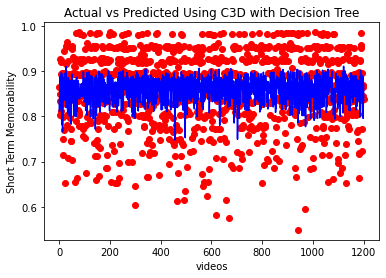

In [ ]:

xTest = range(1,1201)
plt.scatter(xTest, actual["shortActual"], color = 'red')
plt.plot(xTest, pred["shortPred"], color = 'blue')
plt.title('Actual vs Predicted Using C3D with Decision Tree')
plt.xlabel('videos')
plt.ylabel('Short Term Memorability')
plt.show()

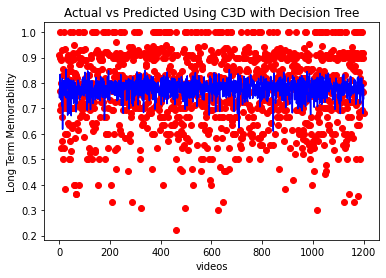

In [ ]:
xTest = range(1,1201)
plt.scatter(xTest, actual["longActual"], color = 'red')
plt.plot(xTest, pred["longPred"], color = 'blue')
plt.title('Actual vs Predicted Using C3D with Decision Tree')
plt.xlabel('videos')
plt.ylabel('Long Term Memorability')
plt.show()

## Aesthetics

In [ ]:
import os
os.chdir("/content/drive/MyDrive/CA684_Assignment_dao/dev-set_aesthetic-features/features/aesthetic_visual_features")

In [ ]:
my_numlist= [] # Creating new list to store the aesthetic features
my_namelist = [] #Creating a new list to store the names of the videos
for filename in glob.glob('aesthetic_feat_dev-set_mean/*.txt'):
    s= read_aesthetic(filename)
    my_numlist.append(s)
    my_namelist.append(((filename.split('/')[-1]).split('.')[0])+ '.webm') 
#adding .webm to the name to make it similar to the video name in ground truth

In [ ]:
df_mean = pd.DataFrame(my_numlist, index = my_namelist)

In [ ]:
df_mean.head()

In [ ]:
df_mean.to_csv(r"/content/drive/MyDrive/CA684_Assignment_dao/aesthetic_mean.csv")

In [ ]:
my_numlist= [] # Creating new list to store the aesthetic features
my_namelist = [] #Creating a new list to store the names of the videos
for filename in glob.glob('aesthetic_feat_dev-set_median/*.txt'):
    s= read_aesthetic(filename)
    my_numlist.append(s)
    my_namelist.append(((filename.split('/')[-1]).split('.')[0])+ '.webm') 
#adding .webm to the name to make it similar to the video name in ground truth

In [ ]:
df_median = pd.DataFrame(my_numlist, index = my_namelist)

In [ ]:
df_median.head()

In [ ]:
df_median.shape

In [ ]:
df_median.to_csv(r"/content/drive/MyDrive/CA684_Assignment_dao/aesthetic_median.csv")

In [ ]:
x = pd.concat([df_median, df_mean])
y = df_mean.drop_duplicates(keep ='last')

In [ ]:
df_aesthetic = pd.merge(y, df_median, left_on=y.index, right_on =df_median.index )

In [ ]:
df_aesthetic = pd.merge(df_mean, df_median, left_on=df_mean.index, right_on =df_median.index )

In [ ]:
df_aesthetic.to_csv(r"/content/drive/MyDrive/CA684_Assignment_dao/aesthetic.csv")

## LBP


In [ ]:
# new list to store the LBP features - first frame
LBP_feature_list_0= []
video_name_list_0 = []

for filename in glob.glob('LBP/*-0.txt'):
    name = ((filename.split('/')[-1]).split('-')[0]+'.webm')
    video_name_list_0.append(name)
    LBP_features = read_LBP(filename)
    LBP_feature_list_0.append(LBP_features)



In [ ]:
# new list to store the LBP features - second frame
LBP_feature_list_56= []
video_name_list_56 = []

for filename in glob.glob('LBP/*-56.txt'):
    name = ((filename.split('/')[-1]).split('-')[0]+'.webm')
    video_name_list_56.append(name)
    LBP_features = read_LBP(filename)
    LBP_feature_list_56.append(LBP_features)



In [ ]:
# new list to store the LBP features - third frame
LBP_feature_list_112= []
video_name_list_112 = []

for filename in glob.glob('LBP/*-112.txt'):
    name = ((filename.split('/')[-1]).split('-')[0]+'.webm')
    video_name_list_112.append(name)
    LBP_features = read_LBP(filename)
    LBP_feature_list_112.append(LBP_features)

In [ ]:
df_0 =pd.read_csv(r"/content/drive/MyDrive/CA684_Assignment_dao/LBP_0.csv")

In [ ]:
df_0 = pd.DataFrame(LBP_feature_list_0, index =video_name_list_0)

In [ ]:
df_0.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121
video7367.webm,0.011365,0.003509,0.002903,0.002230,0.002634,0.001549,0.001424,0.001423,0.001386,0.001654,0.001468,0.001162,0.001095,0.001042,0.001028,0.001050,0.000916,0.000769,0.000736,0.000734,0.000838,0.000854,0.000779,0.000751,0.000768,0.000835,0.000872,0.001013,0.000987,0.001061,0.001097,0.001142,0.001254,0.001350,0.001381,0.001435,0.001582,0.001594,0.001602,0.001734,...,0.001582,0.001470,0.001138,0.001485,0.001155,0.001266,0.001087,0.000980,0.001046,0.001068,0.000838,0.000867,0.000891,0.000963,0.000882,0.000986,0.000867,0.000743,0.000815,0.000925,0.000877,0.000969,0.000891,0.001001,0.001074,0.001172,0.001484,0.001668,0.001571,0.001778,0.002039,0.002796,0.003433,0.002919,0.003203,0.004549,0.005258,0.004235,0.022905,0.630058
video737.webm,0.024803,0.005143,0.004535,0.003419,0.003490,0.002916,0.002639,0.002570,0.002220,0.002134,0.001981,0.001663,0.001405,0.001426,0.001292,0.001187,0.001121,0.001051,0.000997,0.001014,0.001049,0.000967,0.000855,0.000856,0.000815,0.000807,0.000783,0.000762,0.000736,0.000739,0.000706,0.000690,0.000684,0.000691,0.000688,0.000723,0.000731,0.000743,0.000787,0.000858,...,0.000869,0.000895,0.000795,0.001058,0.000833,0.001029,0.000835,0.000823,0.000842,0.001050,0.000799,0.000822,0.000831,0.000978,0.000838,0.000902,0.000860,0.000854,0.000880,0.001054,0.000958,0.001010,0.001070,0.001261,0.001336,0.001440,0.001806,0.001865,0.001886,0.002060,0.002345,0.002917,0.003397,0.003562,0.003884,0.005377,0.006263,0.005573,0.031331,0.747927
video7365.webm,0.024072,0.004288,0.004477,0.003564,0.003425,0.002412,0.002105,0.001960,0.001742,0.002095,0.001932,0.001569,0.001403,0.001347,0.001158,0.001151,0.001032,0.001022,0.000962,0.000964,0.001017,0.000925,0.000810,0.000852,0.000840,0.000804,0.000793,0.000796,0.000763,0.000783,0.000803,0.000788,0.000882,0.000913,0.000945,0.001009,0.000970,0.000990,0.001020,0.001099,...,0.001573,0.001831,0.001240,0.002962,0.001306,0.002702,0.001618,0.001242,0.001662,0.002320,0.001220,0.001643,0.001334,0.002374,0.001667,0.001858,0.001574,0.001423,0.001511,0.002764,0.001669,0.001781,0.001862,0.003220,0.002296,0.002447,0.003702,0.003424,0.002836,0.002896,0.002907,0.003758,0.003714,0.003565,0.004471,0.005563,0.005198,0.004243,0.065922,0.648205
video7370.webm,0.020581,0.004866,0.004818,0.003632,0.005005,0.002711,0.001732,0.001404,0.000886,0.001055,0.000940,0.000532,0.000386,0.000419,0.000362,0.000369,0.000284,0.000243,0.000234,0.000262,0.000312,0.000227,0.000159,0.000185,0.000164,0.000180,0.000183,0.000171,0.000136,0.000148,0.000137,0.000130,0.000138,0.000163,0.000152,0.000160,0.000168,0.000166,0.000194,0.000212,...,0.000473,0.000522,0.000412,0.000648,0.000412,0.000572,0.000478,0.000420,0.000418,0.000620,0.000443,0.000431,0.000427,0.000604,0.000442,0.000497,0.000455,0.000465,0.000531,0.000744,0.000706,0.000829,0.000830,0.000929,0.001036,0.001277,0.001684,0.001925,0.001827,0.002015,0.002346,0.003696,0.005330,0.004899,0.005601,0.008853,0.009845,0.007348,0.055852,0.773921
video7372.webm,0.008521,0.001551,0.001379,0.001237,0.001472,0.001135,0.000992,0.000891,0.000798,0.001408,0.001254,0.000742,0.000598,0.000761,0.000631,0.000698,0.000554,0.000492,0.000450,0.000519,0.001239,0.001095,0.000574,0.000796,0.000795,0.000705,0.000706,0.000702,0.000654,0.000740,0.000948,0.000836,0.001082,0.001270,0.001128,0.001355,0.001166,0.001522,0.001479,0.001524,...,0.004381,0.005086,0.002823,0.007616,0.002807,0.006447,0.004172,0.002708,0.004976,0.004964,0.002625,0.003544,0.003537,0.004747,0.004115,0.004851,0.003243,0.002454,0.002784,0.005231,0.002843,0.002978,0.003180,0.005630,0.004058,0.003946,0.007044,0.005476,0.003594,0.003667,0.003414,0.005978,0.005028,0.003659,0.004031,0.003987,0.004302,0.003075,0.138677,0.382438


In [ ]:
df_56.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121
video7367.webm,0.011367,0.003384,0.003015,0.002342,0.002292,0.001622,0.001563,0.001650,0.001554,0.001571,0.001494,0.001328,0.001171,0.001231,0.001146,0.001085,0.000980,0.000973,0.000934,0.000935,0.000949,0.000980,0.000846,0.000898,0.000924,0.000908,0.000963,0.001078,0.001076,0.001178,0.001298,0.001312,0.001408,0.001602,0.001646,0.001681,0.001679,0.001808,0.001938,0.001896,...,0.001632,0.001724,0.001385,0.001666,0.001283,0.001506,0.001230,0.001078,0.001246,0.001188,0.001018,0.001155,0.001100,0.001251,0.001100,0.001265,0.001190,0.001118,0.001198,0.001244,0.001032,0.001194,0.001201,0.001445,0.001389,0.001422,0.001918,0.001977,0.001993,0.002399,0.002251,0.002873,0.002949,0.003261,0.003845,0.004814,0.005022,0.003641,0.029668,0.593951
video7365.webm,0.024758,0.004355,0.004702,0.003861,0.003352,0.002502,0.002207,0.002047,0.001861,0.002128,0.001822,0.001571,0.001386,0.001337,0.001169,0.001176,0.001106,0.001033,0.001025,0.001071,0.000967,0.000902,0.000868,0.000870,0.000845,0.000885,0.000821,0.000832,0.000779,0.000815,0.000827,0.000841,0.000855,0.000942,0.000938,0.000998,0.000981,0.001022,0.001067,0.001100,...,0.001438,0.001481,0.001127,0.002424,0.001215,0.002187,0.001359,0.001152,0.001347,0.002017,0.001121,0.001342,0.001139,0.001937,0.001312,0.001391,0.001294,0.001295,0.001442,0.002282,0.001479,0.001666,0.001581,0.002449,0.001974,0.002092,0.002664,0.002582,0.002555,0.002758,0.002751,0.003493,0.003634,0.003622,0.004720,0.005605,0.005314,0.004330,0.052518,0.677453
video7370.webm,0.018958,0.003055,0.003256,0.003041,0.003843,0.002587,0.001998,0.002028,0.001372,0.002132,0.001811,0.000948,0.000648,0.000865,0.000779,0.000908,0.000597,0.000717,0.000671,0.000581,0.001285,0.000982,0.000457,0.000736,0.000646,0.000510,0.000602,0.000526,0.000469,0.000504,0.000576,0.000468,0.000507,0.000626,0.000520,0.000595,0.000458,0.000496,0.000604,0.000489,...,0.001240,0.001223,0.000987,0.001802,0.000969,0.001553,0.001281,0.001065,0.001466,0.001750,0.001213,0.001359,0.001867,0.001832,0.001795,0.002856,0.001725,0.001807,0.002441,0.002661,0.002230,0.002594,0.002642,0.003441,0.003312,0.003587,0.006890,0.005212,0.004860,0.005277,0.004665,0.008023,0.007946,0.006072,0.008071,0.007669,0.006000,0.004375,0.109350,0.634208
video7374.webm,0.005874,0.000898,0.000753,0.000595,0.000707,0.000533,0.000520,0.000576,0.000571,0.000847,0.000847,0.000631,0.000538,0.000721,0.000700,0.000826,0.000782,0.000797,0.000811,0.000802,0.001122,0.001125,0.000882,0.001054,0.000994,0.000997,0.001065,0.001156,0.001073,0.001187,0.001375,0.001265,0.001462,0.001672,0.001705,0.001728,0.001656,0.001903,0.002086,0.001971,...,0.003602,0.004145,0.003113,0.004129,0.002849,0.003525,0.002900,0.002326,0.003134,0.002794,0.002151,0.002430,0.002564,0.002750,0.002448,0.002961,0.002363,0.001814,0.002118,0.002678,0.001783,0.001958,0.002115,0.002637,0.002344,0.002387,0.003971,0.003026,0.002391,0.002543,0.002117,0.003309,0.002871,0.002714,0.003539,0.003491,0.003217,0.002175,0.055490,0.363910
video7373.webm,0.013258,0.004201,0.002822,0.002020,0.001934,0.001304,0.001090,0.001078,0.000944,0.001004,0.001002,0.000868,0.000847,0.000861,0.000831,0.000888,0.000904,0.000936,0.000938,0.000989,0.001104,0.001108,0.001058,0.001132,0.001169,0.001272,0.001311,0.001408,0.001486,0.001499,0.001657,0.001541,0.001728,0.001815,0.001863,0.001935,0.002063,0.002178,0.002353,0.002446,...,0.002823,0.002939,0.002523,0.002592,0.002275,0.002169,0.002109,0.002046,0.001927,0.001751,0.001704,0.001740,0.001625,0.001470,0.001479,0.001519,0.001392,0.001276,0.001409,0.001441,0.001278,0.001437,0.001334,0.001337,0.001313,0.001325,0.001502,0.001584,0.001415,0.001554,0.001540,0.001786,0.001908,0.001850,0.002328,0.003014,0.003200,0.002539,0.020113,0.573786


In [ ]:

df_56 = pd.DataFrame(LBP_feature_list_56, index = video_name_list_56)
df_112 = pd.DataFrame(LBP_feature_list_112, index = video_name_list_112)

In [ ]:


df_056 = pd.merge(df_0, df_56, left_on=df_0.index, right_on =df_56.index )
df_056=df_056.set_index('key_0')


In [ ]:
df = pd.merge(df_056, df_112, left_on=df_056.index, right_on =df_112.index )
df =df.set_index('key_0')

df_LBP = pd.merge(ground_truth,df, left_on =ground_truth.video, right_on =df.index)
df_LBP =df_LBP.drop(['key_0'], axis =1)

In [ ]:

df_LBP

,video,short-term_memorability,long-term_memorability,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,14_x,15_x,16_x,17_x,18_x,19_x,20_x,21_x,22_x,23_x,24_x,25_x,26_x,27_x,28_x,29_x,30_x,31_x,32_x,33_x,34_x,35_x,36_x,...,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121
0,video3.webm,0.924,0.846,0.011832,0.002344,0.001827,0.001400,0.002978,0.001540,0.001206,0.001338,0.001135,0.002456,0.002407,0.001198,0.000881,0.001327,0.001227,0.001404,0.001140,0.000991,0.001031,0.000986,0.001727,0.001502,0.000980,0.001182,0.001061,0.000959,0.000979,0.000963,0.000887,0.000942,0.001001,0.000903,0.000986,0.001165,0.001046,0.001085,0.001005,...,0.001668,0.001819,0.001398,0.002101,0.001433,0.001848,0.001553,0.001402,0.001825,0.001791,0.001472,0.001600,0.001937,0.001886,0.001966,0.002980,0.001952,0.001743,0.002127,0.002777,0.002083,0.002364,0.002354,0.003308,0.002976,0.003040,0.005617,0.004017,0.003649,0.003919,0.003662,0.006215,0.006339,0.006231,0.008805,0.009746,0.008074,0.004699,0.135541,0.514539
1,video4.webm,0.923,0.667,0.009664,0.002918,0.002194,0.001868,0.002558,0.002044,0.001905,0.001840,0.001749,0.001888,0.001789,0.001499,0.001479,0.001522,0.001379,0.001347,0.001318,0.001160,0.001185,0.001212,0.001240,0.001421,0.001334,0.001376,0.001353,0.001362,0.001445,0.001549,0.001558,0.001582,0.001673,0.001621,0.001672,0.001737,0.001821,0.001936,0.001866,...,0.002528,0.002615,0.002311,0.002562,0.002304,0.002279,0.002250,0.002113,0.002213,0.002022,0.001905,0.001983,0.002024,0.001839,0.001813,0.001778,0.001612,0.001539,0.001589,0.001681,0.001592,0.001522,0.001517,0.001648,0.001585,0.001687,0.001811,0.001713,0.001716,0.001889,0.001843,0.002144,0.002100,0.002151,0.002319,0.002662,0.002464,0.001534,0.020534,0.461064
2,video6.webm,0.863,0.700,0.010840,0.001895,0.001541,0.000961,0.002857,0.001182,0.000741,0.000833,0.000578,0.001172,0.001049,0.000531,0.000367,0.000525,0.000492,0.000579,0.000466,0.000393,0.000427,0.000435,0.000566,0.000550,0.000488,0.000521,0.000557,0.000513,0.000609,0.000629,0.000573,0.000652,0.000720,0.000652,0.000725,0.000867,0.000802,0.000898,0.000850,...,0.002792,0.002827,0.002060,0.002904,0.001984,0.002328,0.002153,0.001590,0.002035,0.002184,0.001498,0.001908,0.001866,0.001977,0.001951,0.002677,0.001997,0.001528,0.002115,0.002349,0.001648,0.002129,0.001858,0.002656,0.002149,0.002325,0.003595,0.003207,0.002935,0.003156,0.002285,0.003928,0.003798,0.003482,0.004864,0.004392,0.003166,0.002012,0.123364,0.482255
3,video8.webm,0.922,0.818,0.011634,0.004315,0.003213,0.001912,0.002423,0.001428,0.001103,0.001135,0.000999,0.001311,0.000917,0.000560,0.000399,0.000422,0.000323,0.000372,0.000258,0.000244,0.000244,0.000244,0.000391,0.000320,0.000231,0.000258,0.000228,0.000242,0.000221,0.000224,0.000168,0.000210,0.000234,0.000209,0.000232,0.000307,0.000254,0.000311,0.000236,...,0.001165,0.001447,0.001073,0.002222,0.001072,0.002207,0.001313,0.001260,0.001609,0.002204,0.001296,0.001530,0.001989,0.002463,0.002063,0.003670,0.002086,0.001608,0.001930,0.003342,0.001830,0.001929,0.002153,0.003901,0.002668,0.002665,0.004221,0.003836,0.003699,0.004204,0.003601,0.006800,0.006328,0.007033,0.011622,0.011662,0.009279,0.005855,0.224420,0.535760
4,video10.webm,0.950,0.900,0.025250,0.004858,0.004892,0.003862,0.004429,0.003433,0.003179,0.003398,0.003172,0.003559,0.003347,0.002780,0.002710,0.002611,0.002328,0.002436,0.002118,0.001975,0.001837,0.001694,0.001498,0.001401,0.001190,0.001123,0.001041,0.000953,0.000923,0.000933,0.000855,0.000868,0.000877,0.000856,0.000893,0.000943,0.000937,0.000966,0.000947,...,0.000925,0.000947,0.000848,0.000942,0.000859,0.000907,0.000849,0.000974,0.000887,0.000961,0.000968,0.001034,0.001037,0.001174,0.001216,0.001264,0.001315,0.001407,0.001445,0.001623,0.001651,0.001824,0.001919,0.001981,0.002148,0.002311,0.002348,0.002459,0.002568,0.002552,0.002474,0.002568,0.002568,0.002832,0.003209,0.004080,0.004773,0.003983,0.026907,0.688721
...,...,.

In [ ]:
df_LBP.to_csv(r"/content/drive/MyDrive/CA684_Assignment_dao/LBP.csv")

In [ ]:
df_LBP

,video,short-term_memorability,long-term_memorability,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,14_x,15_x,16_x,17_x,18_x,19_x,20_x,21_x,22_x,23_x,24_x,25_x,26_x,27_x,28_x,29_x,30_x,31_x,32_x,33_x,34_x,35_x,36_x,...,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121
0,video3.webm,0.924,0.846,0.011832,0.002344,0.001827,0.001400,0.002978,0.001540,0.001206,0.001338,0.001135,0.002456,0.002407,0.001198,0.000881,0.001327,0.001227,0.001404,0.001140,0.000991,0.001031,0.000986,0.001727,0.001502,0.000980,0.001182,0.001061,0.000959,0.000979,0.000963,0.000887,0.000942,0.001001,0.000903,0.000986,0.001165,0.001046,0.001085,0.001005,...,0.001668,0.001819,0.001398,0.002101,0.001433,0.001848,0.001553,0.001402,0.001825,0.001791,0.001472,0.001600,0.001937,0.001886,0.001966,0.002980,0.001952,0.001743,0.002127,0.002777,0.002083,0.002364,0.002354,0.003308,0.002976,0.003040,0.005617,0.004017,0.003649,0.003919,0.003662,0.006215,0.006339,0.006231,0.008805,0.009746,0.008074,0.004699,0.135541,0.514539
1,video4.webm,0.923,0.667,0.009664,0.002918,0.002194,0.001868,0.002558,0.002044,0.001905,0.001840,0.001749,0.001888,0.001789,0.001499,0.001479,0.001522,0.001379,0.001347,0.001318,0.001160,0.001185,0.001212,0.001240,0.001421,0.001334,0.001376,0.001353,0.001362,0.001445,0.001549,0.001558,0.001582,0.001673,0.001621,0.001672,0.001737,0.001821,0.001936,0.001866,...,0.002528,0.002615,0.002311,0.002562,0.002304,0.002279,0.002250,0.002113,0.002213,0.002022,0.001905,0.001983,0.002024,0.001839,0.001813,0.001778,0.001612,0.001539,0.001589,0.001681,0.001592,0.001522,0.001517,0.001648,0.001585,0.001687,0.001811,0.001713,0.001716,0.001889,0.001843,0.002144,0.002100,0.002151,0.002319,0.002662,0.002464,0.001534,0.020534,0.461064
2,video6.webm,0.863,0.700,0.010840,0.001895,0.001541,0.000961,0.002857,0.001182,0.000741,0.000833,0.000578,0.001172,0.001049,0.000531,0.000367,0.000525,0.000492,0.000579,0.000466,0.000393,0.000427,0.000435,0.000566,0.000550,0.000488,0.000521,0.000557,0.000513,0.000609,0.000629,0.000573,0.000652,0.000720,0.000652,0.000725,0.000867,0.000802,0.000898,0.000850,...,0.002792,0.002827,0.002060,0.002904,0.001984,0.002328,0.002153,0.001590,0.002035,0.002184,0.001498,0.001908,0.001866,0.001977,0.001951,0.002677,0.001997,0.001528,0.002115,0.002349,0.001648,0.002129,0.001858,0.002656,0.002149,0.002325,0.003595,0.003207,0.002935,0.003156,0.002285,0.003928,0.003798,0.003482,0.004864,0.004392,0.003166,0.002012,0.123364,0.482255
3,video8.webm,0.922,0.818,0.011634,0.004315,0.003213,0.001912,0.002423,0.001428,0.001103,0.001135,0.000999,0.001311,0.000917,0.000560,0.000399,0.000422,0.000323,0.000372,0.000258,0.000244,0.000244,0.000244,0.000391,0.000320,0.000231,0.000258,0.000228,0.000242,0.000221,0.000224,0.000168,0.000210,0.000234,0.000209,0.000232,0.000307,0.000254,0.000311,0.000236,...,0.001165,0.001447,0.001073,0.002222,0.001072,0.002207,0.001313,0.001260,0.001609,0.002204,0.001296,0.001530,0.001989,0.002463,0.002063,0.003670,0.002086,0.001608,0.001930,0.003342,0.001830,0.001929,0.002153,0.003901,0.002668,0.002665,0.004221,0.003836,0.003699,0.004204,0.003601,0.006800,0.006328,0.007033,0.011622,0.011662,0.009279,0.005855,0.224420,0.535760
4,video10.webm,0.950,0.900,0.025250,0.004858,0.004892,0.003862,0.004429,0.003433,0.003179,0.003398,0.003172,0.003559,0.003347,0.002780,0.002710,0.002611,0.002328,0.002436,0.002118,0.001975,0.001837,0.001694,0.001498,0.001401,0.001190,0.001123,0.001041,0.000953,0.000923,0.000933,0.000855,0.000868,0.000877,0.000856,0.000893,0.000943,0.000937,0.000966,0.000947,...,0.000925,0.000947,0.000848,0.000942,0.000859,0.000907,0.000849,0.000974,0.000887,0.000961,0.000968,0.001034,0.001037,0.001174,0.001216,0.001264,0.001315,0.001407,0.001445,0.001623,0.001651,0.001824,0.001919,0.001981,0.002148,0.002311,0.002348,0.002459,0.002568,0.002552,0.002474,0.002568,0.002568,0.002832,0.003209,0.004080,0.004773,0.003983,0.026907,0.688721
...,...,.

In [ ]:
lbp_features = df_LBP.iloc[:,3:369].values

In [ ]:
X = lbp_features
Y = ground_truth.iloc[:, 1:3].values

In [ ]:
a = df_LBP.isnull().values.any()

In [ ]:
a = df_LBP[df_LBP.isnull().T.any()]

In [ ]:
a

,video,short-term_memorability,long-term_memorability,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,14_x,15_x,16_x,17_x,18_x,19_x,20_x,21_x,22_x,23_x,24_x,25_x,26_x,27_x,28_x,29_x,30_x,31_x,32_x,33_x,34_x,35_x,36_x,...,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121
1142,video1429.webm,0.896,0.667,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.002565,0.002975,0.002127,0.003951,0.002026,0.003610,0.002388,0.001740,0.002661,0.003210,0.001741,0.002099,0.002292,0.003047,0.002339,0.003244,0.002102,0.001682,0.002271,0.003693,0.001874,0.002147,0.002452,0.004276,0.003046,0.003063,0.005987,0.003989,0.003367,0.003516,0.002894,0.005374,0.004710,0.003952,0.005073,0.004332,0.003812,0.002325,0.215641,0.314568
1364,video1697.webm,0.799,0.700,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.002388,0.002521,0.002015,0.002469,0.001857,0.002297,0.001910,0.001603,0.002069,0.001819,0.001522,0.001709,0.001689,0.001771,0.001614,0.002054,0.001600,0.001353,0.001564,0.001876,0.001374,0.001616,0.001667,0.001981,0.001689,0.001636,0.002606,0.002008,0.001797,0.001956,0.001809,0.003008,0.003059,0.003265,0.005176,0.006421,0.005707,0.003900,0.075379,0.465656
1447,video1800.webm,0.789,0.909,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.001617,0.001557,0.001352,0.001910,0.001253,0.001604,0.001411,0.001167,0.001342,0.001539,0.001183,0.001182,0.001329,0.001531,0.001372,0.001709,0.001493,0.001383,0.001580,0.001995,0.001518,0.001812,0.001696,0.002276,0.002179,0.002441,0.002834,0.002860,0.002949,0.003408,0.003023,0.003803,0.003797,0.004427,0.005748,0.006664,0.005605,0.003207,0.078224,0.529943
1544,video1914.webm,0.954,0.929,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.002272,0.002279,0.002008,0.002220,0.001870,0.001850,0.001792,0.001745,0.001783,0.001712,0.001670,0.001724,0.001694,0.001779,0.001698,0.001778,0.001680,0.001603,0.001677,0.001874,0.001603,0.001698,0.001564,0.001725,0.001710,0.001829,0.001935,0.001876,0.001977,0.002107,0.001996,0.002624,0.002715,0.003221,0.004298,0.006088,0.005618,0.003350,0.037042,0.541557
1671,video2073.webm,0.640,0.818,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000262,0.000257,0.000230,0.000407,0.000245,0.000295,0.000272,0.000336,0.000255,0.000342,0.000275,0.000294,0.000284,0.000374,0.000337,0.000355,0.000369,0.000365,0.000412,0.000544,0.000489,0.000559,0.000642,0.000715,0.000761,0.001008,0.001125,0.001306,0.001563,0.001837,0.002012,0.002514,0.003034,0.003826,0.005079,0.007718,0.008981,0.005898,0.038792,0.801924
1745,video2172.webm,0.894,0.778,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.004128,0.005473,0.002889,0.007542,0.003274,0.006588,0.004253,0.002434,0.004081,0.005460,0.002014,0.003889,0.002431,0.004826,0.003312,0.002940,0.002677,0.001557,0.002418,0.005015,0.002033,0.002592,0.002298,0.005447,0.003078,0.003556,0.007266,0.005685,0.004249,0.004261,0.004406,0.010232,0.009775,0.007376,0.010262,0.010663,0.009416,0.005636,0.195884,0.366176
3229,video4056.webm,0.952,0.938,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000236,0.000246,0.000175,0.000407,0.000184,0.000203,0.000240,0.000294,0.000163,0.000283,0.000224,0.000236,0.0001

In [ ]:
for i in range(3,125):
  a.iloc[:,i] = a.iloc[:, i+122]

In [ ]:
x = pd.concat([a, df_LBP])
x.shape

In [ ]:
y=x.dropna()

In [ ]:
y.to_csv(r"/content/drive/MyDrive/CA684_Assignment_dao/LBP.csv")

## HMP


In [ ]:

HMP_feature_list= []
video_names_list = []
path = 'HMP/*.txt'
for filename in glob.glob('HMP_test/*.txt'):
    name = ((filename.split('/')[-1]).split('.')[0]+'.webm')
    video_names_list.append(name)
    HMP_features = read_HMP(filename)
    HMP_feature_list.append(HMP_features)

In [ ]:
len(HMP_feature_list[0])
#len(video_names_list)


6075

In [ ]:
HMP_features = pd.DataFrame(np.array(HMP_feature_list).reshape(2000,6075))
HMP_features["video"] = video_names_list

In [ ]:
HMP_features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,6036,6037,6038,6039,6040,6041,6042,6043,6044,6045,6046,6047,6048,6049,6050,6051,6052,6053,6054,6055,6056,6057,6058,6059,6060,6061,6062,6063,6064,6065,6066,6067,6068,6069,6070,6071,6072,6073,6074,video
0,0.002060,0.000583,0.000011,0.0,0.000395,0.000031,0.0,0.000000,0.000007,0.0,0.0,0.0,0.0,0.000035,0.000000,0.0,0.000000,0.000002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000901,0.001298,0.000085,0.000370,0.000221,0.000007,0.000421,0.000616,0.000026,0.000526,0.000793,0.000033,0.000346,0.000145,0.000000,0.000129,0.000186,0.000011,0.000022,0.000035,0.000000,0.000173,0.000088,0.000004,0.000270,0.000368,0.000015,0.000083,0.000072,0.000004,0.000366,0.000169,0.000002,0.000388,0.000590,0.000033,0.000655,0.000671,0.000055,video8763.webm
1,0.015623,0.005571,0.000267,0.0,0.003743,0.000415,0.0,0.000002,0.000082,0.0,0.0,0.0,0.0,0.000805,0.000124,0.0,0.000002,0.000024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000845,0.000984,0.000260,0.000468,0.000141,0.000007,0.000247,0.000498,0.000055,0.000457,0.000457,0.000115,0.000382,0.000097,0.000002,0.000099,0.000152,0.000015,0.000026,0.000037,0.000007,0.000205,0.000060,0.000004,0.000265,0.000406,0.000033,0.000068,0.000062,0.000049,0.000944,0.000185,0.000007,0.000439,0.000955,0.000084,0.000851,0.000752,0.000273,video8758.webm
2,0.005330,0.001166,0.000002,0.0,0.000927,0.000011,0.0,0.000000,0.000004,0.0,0.0,0.0,0.0,0.000074,0.000000,0.0,0.000000,0.000002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000293,0.000617,0.000185,0.000170,0.000101,0.000007,0.000246,0.000393,0.000034,0.000288,0.000384,0.000150,0.000087,0.000029,0.000002,0.000025,0.000034,0.000002,0.000002,0.000013,0.000007,0.000096,0.000058,0.000000,0.000139,0.000130,0.000018,0.000016,0.000040,0.000018,0.000092,0.000025,0.000016,0.000107,0.000199,0.000009,0.000152,0.000188,0.000092,video8768.webm
3,0.040748,0.016237,0.000303,0.0,0.007668,0.000118,0.0,0.000000,0.000033,0.0,0.0,0.0,0.0,0.002083,0.000107,0.0,0.000000,0.000013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000383,0.001531,0.000004,0.000053,0.000316,0.000000,0.000114,0.000630,0.000000,0.000118,0.001318,0.000002,0.000047,0.000151,0.000000,0.000056,0.000180,0.000000,0.000027,0.000100,0.000000,0.000016,0.000020,0.000000,0.000082,0.000238,0.000000,0.000018,0.000100,0.000002,0.000058,0.000154,0.000000,0.000125,0.000530,0.000000,0.000073,0.000572,0.000002,video8764.webm
4,0.056045,0.012873,0.000278,0.0,0.006645,0.000157,0.0,0.000000,0.000069,0.0,0.0,0.0,0.0,0.001593,0.000112,0.0,0.000000,0.000016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000152,0.000217,0.000114,0.000027,0.000013,0.000002,0.000083,0.000096,0.000011,0.000056,0.000110,0.000045,0.000063,0.000016,0.000000,0.000018,0.000018,0.000004,0.000004,0.000002,0.000000,0.000020,0.000009,0.000000,0.000036,0.000103,0.000009,0.000002,0.000018,0.000025,0.000074,0.000027,0.000004,0.000036,0.000305,0.000011,0.000087,0.000217,0.000345,video8760.webm


In [ ]:
hdf = pd.merge(ground_truth, HMP_features , on='video')

In [ ]:

hdf.head()

,video,short-term_memorability,long-term_memorability,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,6035,6036,6037,6038,6039,6040,6041,6042,6043,6044,6045,6046,6047,6048,6049,6050,6051,6052,6053,6054,6055,6056,6057,6058,6059,6060,6061,6062,6063,6064,6065,6066,6067,6068,6069,6070,6071,6072,6073,6074
0,video3.webm,0.924,0.846,0.125563,0.024036,0.000314,0.0,0.015864,0.000358,0.0,0.000000,0.000086,0.0,0.0,0.0,0.0,0.002795,0.000054,0.0,0.000000,0.000037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000002,0.000173,0.000459,0.000000,0.000148,0.000104,0.000000,0.000121,0.000551,0.000000,0.000114,0.000884,0.000002,0.000116,0.000077,0.000002,0.000027,0.000136,0.000000,0.000000,0.000002,0.000000,0.000091,0.000035,0.000000,0.000163,0.000467,0.000002,0.000010,0.000017,0.000000,0.000393,0.000279,0.000000,0.000289,0.001926,0.000000,0.000086,0.000580,0.000000
1,video4.webm,0.923,0.667,0.007526,0.001421,0.000068,0.0,0.001184,0.000143,0.0,0.000000,0.000079,0.0,0.0,0.0,0.0,0.000246,0.000024,0.0,0.000000,0.000042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000685,0.000308,0.001054,0.000751,0.000176,0.000062,0.000000,0.000123,0.000398,0.000086,0.000246,0.000433,0.000446,0.000143,0.000053,0.000000,0.000053,0.000099,0.000009,0.000004,0.000033,0.000004,0.000051,0.000035,0.000000,0.000062,0.000358,0.000035,0.000024,0.000083,0.000053,0.000244,0.000066,0.000000,0.000081,0.000617,0.000094,0.000220,0.000762,0.001224
2,video6.webm,0.863,0.700,0.109584,0.018978,0.000289,0.0,0.008774,0.000208,0.0,0.000002,0.000088,0.0,0.0,0.0,0.0,0.002046,0.000061,0.0,0.000000,0.000038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000083,0.000057,0.000158,0.000073,0.000021,0.000009,0.000002,0.000019,0.000095,0.000021,0.000019,0.000090,0.000073,0.000050,0.000024,0.000000,0.000012,0.000021,0.000000,0.000000,0.000002,0.000000,0.000017,0.000007,0.000002,0.000066,0.000203,0.000026,0.000002,0.000040,0.000007,0.000054,0.000045,0.000000,0.000028,0.000291,0.000033,0.000052,0.000258,0.000215
3,video8.webm,0.922,0.818,0.120431,0.013561,0.000277,0.0,0.018974,0.000913,0.0,0.000024,0.000713,0.0,0.0,0.0,0.0,0.002496,0.000149,0.0,0.000011,0.000157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000210,0.000434,0.000543,0.000412,0.000412,0.000045,0.000003,0.000144,0.000282,0.000037,0.000197,0.000218,0.000157,0.000237,0.000021,0.000000,0.000040,0.000056,0.000008,0.000005,0.000013,0.000019,0.000168,0.000013,0.000000,0.000133,0.000202,0.000029,0.000029,0.000035,0.000059,0.001110,0.000075,0.000008,0.000333,0.000793,0.000101,0.000588,0.000503,0.000452
4,video10.webm,0.950,0.900,0.005026,0.001356,0.000055,0.0,0.000665,0.000029,0.0,0.000000,0.000024,0.0,0.0,0.0,0.0,0.000147,0.000020,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000160,0.000996,0.001604,0.000103,0.000768,0.000215,0.000009,0.000415,0.000926,0.000020,0.000538,0.001178,0.000050,0.000518,0.000169,0.000007,0.000134,0.000169,0.000007,0.000026,0.000046,0.000007,0.000373,0.000088,0.000000,0.000338,0.000441,0.000029,0.000070,0.000149,0.000009,0.000882,0.000200,0.000009,0.000559,0.001097,0.000018,0.000632,0.001128,0.000064


In [ ]:
hdf.shape

(6000, 6078)

In [ ]:
hdf.to_csv(r"/content/drive/MyDrive/CA684_Assignment_dao/HMP.csv")

In [ ]:
HMP_features.shape

(2000, 6076)

In [ ]:
HMP_features.to_csv(r"/content/drive/MyDrive/CA684_Assignment_dao/HMP_test.csv")

In [ ]:
df_hdf=pd.read_csv(r"/content/drive/MyDrive/CA684_Assignment_dao/HMP_test.csv")
df_hdf.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,6036,6037,6038,6039,6040,6041,6042,6043,6044,6045,6046,6047,6048,6049,6050,6051,6052,6053,6054,6055,6056,6057,6058,6059,6060,6061,6062,6063,6064,6065,6066,6067,6068,6069,6070,6071,6072,6073,6074,video
0,0,0.002060,0.000583,0.000011,0.0,0.000395,0.000031,0.0,0.000000,0.000007,0.0,0.0,0.0,0.0,0.000035,0.000000,0.0,0.000000,0.000002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000901,0.001298,0.000085,0.000370,0.000221,0.000007,0.000421,0.000616,0.000026,0.000526,0.000793,0.000033,0.000346,0.000145,0.000000,0.000129,0.000186,0.000011,0.000022,0.000035,0.000000,0.000173,0.000088,0.000004,0.000270,0.000368,0.000015,0.000083,0.000072,0.000004,0.000366,0.000169,0.000002,0.000388,0.000590,0.000033,0.000655,0.000671,0.000055,video8763.webm
1,1,0.015623,0.005571,0.000267,0.0,0.003743,0.000415,0.0,0.000002,0.000082,0.0,0.0,0.0,0.0,0.000805,0.000124,0.0,0.000002,0.000024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000845,0.000984,0.000260,0.000468,0.000141,0.000007,0.000247,0.000498,0.000055,0.000457,0.000457,0.000115,0.000382,0.000097,0.000002,0.000099,0.000152,0.000015,0.000026,0.000037,0.000007,0.000205,0.000060,0.000004,0.000265,0.000406,0.000033,0.000068,0.000062,0.000049,0.000944,0.000185,0.000007,0.000439,0.000955,0.000084,0.000851,0.000752,0.000273,video8758.webm
2,2,0.005330,0.001166,0.000002,0.0,0.000927,0.000011,0.0,0.000000,0.000004,0.0,0.0,0.0,0.0,0.000074,0.000000,0.0,0.000000,0.000002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000293,0.000617,0.000185,0.000170,0.000101,0.000007,0.000246,0.000393,0.000034,0.000288,0.000384,0.000150,0.000087,0.000029,0.000002,0.000025,0.000034,0.000002,0.000002,0.000013,0.000007,0.000096,0.000058,0.000000,0.000139,0.000130,0.000018,0.000016,0.000040,0.000018,0.000092,0.000025,0.000016,0.000107,0.000199,0.000009,0.000152,0.000188,0.000092,video8768.webm
3,3,0.040748,0.016237,0.000303,0.0,0.007668,0.000118,0.0,0.000000,0.000033,0.0,0.0,0.0,0.0,0.002083,0.000107,0.0,0.000000,0.000013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000383,0.001531,0.000004,0.000053,0.000316,0.000000,0.000114,0.000630,0.000000,0.000118,0.001318,0.000002,0.000047,0.000151,0.000000,0.000056,0.000180,0.000000,0.000027,0.000100,0.000000,0.000016,0.000020,0.000000,0.000082,0.000238,0.000000,0.000018,0.000100,0.000002,0.000058,0.000154,0.000000,0.000125,0.000530,0.000000,0.000073,0.000572,0.000002,video8764.webm
4,4,0.056045,0.012873,0.000278,0.0,0.006645,0.000157,0.0,0.000000,0.000069,0.0,0.0,0.0,0.0,0.001593,0.000112,0.0,0.000000,0.000016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000152,0.000217,0.000114,0.000027,0.000013,0.000002,0.000083,0.000096,0.000011,0.000056,0.000110,0.000045,0.000063,0.000016,0.000000,0.000018,0.000018,0.000004,0.000004,0.000002,0.000000,0.000020,0.000009,0.000000,0.000036,0.000103,0.000009,0.000002,0.000018,0.000025,0.000074,0.000027,0.000004,0.000036,0.000305,0.000011,0.000087,0.000217,0.000345,video8760.webm


## ColorHistogram

In [ ]:
ColorHis_feature_list_0= []
video_names_list_0 = []

for filename in glob.glob('ColorHistogram_test/*-0.txt'):
    name = ((filename.split('/')[-1]).split('-')[0]+'.webm')
    video_names_list_0.append(name)
    ColorHis_features = read_ColorHistogram(filename)
    ColorHis_feature_list_0.append(ColorHis_features)
    


In [ ]:
ColorHis_feature_list_56= []
video_names_list_56 = []
for filename in glob.glob('ColorHistogram_test/*-56.txt'):
    name = ((filename.split('/')[-1]).split('-')[0]+'.webm')
    video_names_list_56.append(name)
    ColorHis_features = read_ColorHistogram(filename)
    ColorHis_feature_list_56.append(ColorHis_features)




In [ ]:
ColorHis_feature_list_112= []
video_names_list_112 = []
for filename in glob.glob('ColorHistogram_test/*-112.txt'):
    name = ((filename.split('/')[-1]).split('-')[0]+'.webm')
    video_names_list_112.append(name)
    ColorHis_features = read_ColorHistogram(filename)
    ColorHis_feature_list_112.append(ColorHis_features)

In [ ]:
colorHistFlatten_0 = []
for video in ColorHis_feature_list_0:
    colorHistFlatten_0.append(video.flatten())


In [ ]:

colorHistFlatten_56 = []
for video in ColorHis_feature_list_56:
    colorHistFlatten_56.append(video.flatten())

colorHistFlatten_112 = []
for video in ColorHis_feature_list_112:
    colorHistFlatten_112.append(video.flatten())

In [ ]:
df_0 = pd.DataFrame(colorHistFlatten_0, index = video_names_list_0)
df_56 = pd.DataFrame(colorHistFlatten_56, index = video_names_list_56)
df_112 = pd.DataFrame(colorHistFlatten_112, index = video_names_list_112)

In [ ]:
df_056 = pd.merge(df_0, df_56, left_on=df_0.index, right_on =df_56.index )
df_056=df_056.set_index('key_0')
df_056

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,14_x,15_x,16_x,17_x,18_x,19_x,20_x,21_x,22_x,23_x,24_x,25_x,26_x,27_x,28_x,29_x,30_x,31_x,32_x,33_x,34_x,35_x,36_x,37_x,38_x,39_x,...,728_y,729_y,730_y,731_y,732_y,733_y,734_y,735_y,736_y,737_y,738_y,739_y,740_y,741_y,742_y,743_y,744_y,745_y,746_y,747_y,748_y,749_y,750_y,751_y,752_y,753_y,754_y,755_y,756_y,757_y,758_y,759_y,760_y,761_y,762_y,763_y,764_y,765_y,766_y,767_y
key_0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
video9588.webm,9048.0,14717.0,50970.0,96062.0,74515.0,95839.0,84684.0,56331.0,61446.0,48306.0,44556.0,39257.0,36397.0,38882.0,25511.0,32746.0,19863.0,35267.0,21932.0,25941.0,22828.0,13562.0,16046.0,10866.0,14264.0,11217.0,11939.0,12656.0,9375.0,12017.0,11338.0,13816.0,13546.0,14627.0,15711.0,12683.0,18227.0,15561.0,15567.0,13929.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
video9591.webm,129.0,37.0,48.0,79.0,251.0,121.0,477.0,393.0,549.0,566.0,483.0,805.0,586.0,1285.0,1317.0,960.0,963.0,865.0,1612.0,1351.0,1275.0,1350.0,1478.0,1648.0,1841.0,1874.0,1897.0,1989.0,2119.0,1854.0,2135.0,2040.0,2190.0,2058.0,2413.0,2645.0,2903.0,2881.0,3176.0,3417.0,...,25660.0,22739.0,20970.0,27237.0,22176.0,26292.0,24985.0,25731.0,19478.0,21001.0,25347.0,20986.0,23723.0,21260.0,23674.0,17895.0,19848.0,21941.0,18768.0,21919.0,17727.0,19030.0,13661.0,14673.0,15461.0,15058.0,16548.0,14214.0,14968.0,11474.0,14646.0,15461.0,13786.0,16945.0,15966.0,18675.0,20063.0,29377.0,33968.0,59815.0
video9590.webm,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,1.0,2.0,3.0,2.0,7.0,3.0,...,23907.0,18731.0,8362.0,47835.0,20925.0,18456.0,5861.0,14125.0,10989.0,8258.0,6300.0,9752.0,6378.0,6892.0,9427.0,9491.0,9144.0,5919.0,11425.0,7161.0,8360.0,10375.0,8902.0,11830.0,14570.0,12930.0,16166.0,196405.0,7222.0,4992.0,3780.0,2902.0,2135.0,1642.0,1245.0,913.0,733.0,516.0,373.0,989.0
video9589.webm,85315.0,22261.0,16269.0,14820.0,15818.0,14164.0,15779.0,14557.0,15683.0,18410.0,18119.0,21580.0,21336.0,25304.0,23949.0,27335.0,29202.0,27587.0,27875.0,27929.0,28749.0,28437.0,28461.0,28120.0,27238.0,22289.0,25654.0,23702.0,23445.0,22514.0,23152.0,21163.0,20355.0,21469.0,19361.0,21008.0,21338.0,21966.0,21736.0,20636.0,...,4975.0,6038.0,5724.0,5086.0,6170.0,6293.0,5542.0,5341.0,5102.0,4047.0,3548.0,4995.0,5710.0,5694.0,4688.0,4215.0,3161.0,2953.0,3669.0,3070.0,2973.0,2963.0,3234.0,2929.0,1873.0,4066.0,3120.0,3123.0,3489.0,3300.0,3551.0,2204.0,1575.0,1392.0,1041.0,1230.0,876.0,1022.0,704.0,2808.0
video9596.webm,257.0,84.0,112.0,137.0,259.0,288.0,393.0,545.0,931.0,920.0,1202.0,1245.0,1043.0,1698.0,1612.0,2044.0,2400.0,2771.0,4186.0,3606.0,6219.0,6860.0,8436.0,9617.0,7413.0,14098.0,11766.0,16076.0,15232.0,15210.0,15765.0,10949.0,17774.0,16374.0,19444.0,18391.0,17498.0,17556.0,13681.0,18451.0,...,10732.0,9416.0,9702.0,7829.0,8959.0,8606.0,7510.0,7583.0,8490.0,7229.0,6700.0,7211.0,6985.0,4828.0,5129.0,4305.0,3282.0,2792.0,2736.0,2301.0,1811.0,1962.0,1302.0,1450.0,995.0,1136.0,1117.0,978.0,1143.0,713.0,1015.0,714.0,922.0,1181.0,1470.0,2237.0,1607.0,4706.0,436.0,10243.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
video7897.webm,5278.0,1387.0,1380.0,1426.0,1455.0,1278.0,2419.0,1450.0,2838.0,3291.0,3334.0,3617.0,2888.0,3623.0,2242.0,3831.0,3287.0,3609.0,2917.0,2789.0,3021.0,2570.0,3424.0,3085.0,3068.0,3305.0,2723.0,2544.0,2032.0,2708.0,1954.0,2151.0,1784.0,1730.0,1564.0,1222.0,1383.0,1173.0,1480.0,1231.0,...,9245.0,9611.0,7800.0,9569.0,10126.0,10572.0,9745.0,9659.0,7317.0,7394.0,8112.0,7502.0,768

In [ ]:
df = pd.merge(df_056, df_112, left_on=df_056.index, right_on =df_112.index )
df =df.set_index('key_0')
df

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,14_x,15_x,16_x,17_x,18_x,19_x,20_x,21_x,22_x,23_x,24_x,25_x,26_x,27_x,28_x,29_x,30_x,31_x,32_x,33_x,34_x,35_x,36_x,37_x,38_x,39_x,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
key_0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
video9588.webm,9048.0,14717.0,50970.0,96062.0,74515.0,95839.0,84684.0,56331.0,61446.0,48306.0,44556.0,39257.0,36397.0,38882.0,25511.0,32746.0,19863.0,35267.0,21932.0,25941.0,22828.0,13562.0,16046.0,10866.0,14264.0,11217.0,11939.0,12656.0,9375.0,12017.0,11338.0,13816.0,13546.0,14627.0,15711.0,12683.0,18227.0,15561.0,15567.0,13929.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
video9591.webm,129.0,37.0,48.0,79.0,251.0,121.0,477.0,393.0,549.0,566.0,483.0,805.0,586.0,1285.0,1317.0,960.0,963.0,865.0,1612.0,1351.0,1275.0,1350.0,1478.0,1648.0,1841.0,1874.0,1897.0,1989.0,2119.0,1854.0,2135.0,2040.0,2190.0,2058.0,2413.0,2645.0,2903.0,2881.0,3176.0,3417.0,...,24234.0,21691.0,19194.0,25049.0,21325.0,24313.0,22739.0,24920.0,19246.0,20735.0,24482.0,19985.0,22183.0,20636.0,22367.0,18198.0,19920.0,21484.0,17827.0,20953.0,17775.0,18981.0,15188.0,15057.0,17455.0,16316.0,18073.0,15504.0,15779.0,12098.0,13112.0,14704.0,13629.0,17280.0,18267.0,22202.0,22453.0,29858.0,29952.0,52024.0
video9590.webm,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,1.0,2.0,3.0,2.0,7.0,3.0,...,26224.0,18927.0,9674.0,41530.0,25715.0,19310.0,6705.0,14152.0,10147.0,8063.0,6501.0,9103.0,6267.0,8070.0,9132.0,9598.0,8623.0,6722.0,10822.0,8216.0,8432.0,11632.0,9545.0,13034.0,14352.0,12544.0,16008.0,186791.0,7118.0,4261.0,3377.0,2646.0,1884.0,1562.0,1210.0,951.0,686.0,525.0,426.0,1102.0
video9589.webm,85315.0,22261.0,16269.0,14820.0,15818.0,14164.0,15779.0,14557.0,15683.0,18410.0,18119.0,21580.0,21336.0,25304.0,23949.0,27335.0,29202.0,27587.0,27875.0,27929.0,28749.0,28437.0,28461.0,28120.0,27238.0,22289.0,25654.0,23702.0,23445.0,22514.0,23152.0,21163.0,20355.0,21469.0,19361.0,21008.0,21338.0,21966.0,21736.0,20636.0,...,4718.0,5701.0,5874.0,5039.0,6352.0,6132.0,5784.0,5621.0,5727.0,4982.0,4185.0,5547.0,5744.0,5427.0,4633.0,4106.0,3163.0,2866.0,3777.0,3459.0,3540.0,3411.0,3587.0,3269.0,1935.0,4419.0,3441.0,3481.0,3501.0,3338.0,3595.0,2467.0,2014.0,1831.0,1540.0,1675.0,1292.0,1493.0,1002.0,4135.0
video9596.webm,257.0,84.0,112.0,137.0,259.0,288.0,393.0,545.0,931.0,920.0,1202.0,1245.0,1043.0,1698.0,1612.0,2044.0,2400.0,2771.0,4186.0,3606.0,6219.0,6860.0,8436.0,9617.0,7413.0,14098.0,11766.0,16076.0,15232.0,15210.0,15765.0,10949.0,17774.0,16374.0,19444.0,18391.0,17498.0,17556.0,13681.0,18451.0,...,10529.0,9371.0,9690.0,7533.0,8188.0,8476.0,7129.0,7372.0,7846.0,7303.0,6807.0,7295.0,6594.0,4638.0,4726.0,3898.0,3036.0,2471.0,2510.0,2201.0,1661.0,1853.0,1422.0,1523.0,1104.0,1178.0,1168.0,999.0,1111.0,696.0,1021.0,719.0,907.0,1214.0,1447.0,2102.0,1713.0,4416.0,628.0,10268.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
video7897.webm,5278.0,1387.0,1380.0,1426.0,1455.0,1278.0,2419.0,1450.0,2838.0,3291.0,3334.0,3617.0,2888.0,3623.0,2242.0,3831.0,3287.0,3609.0,2917.0,2789.0,3021.0,2570.0,3424.0,3085.0,3068.0,3305.0,2723.0,2544.0,2032.0,2708.0,1954.0,2151.0,1784.0,1730.0,1564.0,1222.0,1383.0,1173.0,1480.0,1231.0,...,9992.0,9273.0,7504.0,9348.0,10428.0,10248.0,9399.0,9661.0,7483.0,7657.0,8533.0,7894.0,7757.0,7165.0,7242.0,5599.0,5666.0,6469.0,5671.0,6195.0,5043.0,5028.0,3362.0,39

In [ ]:
df_ColorHis = pd.merge(ground_truth,df, left_on =ground_truth.video, right_on =df.index)

In [ ]:
df_ColorHis =df_ColorHis.drop(['key_0'], axis =1)
df_ColorHis

,video,short-term_memorability,long-term_memorability,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,14_x,15_x,16_x,17_x,18_x,19_x,20_x,21_x,22_x,23_x,24_x,25_x,26_x,27_x,28_x,29_x,30_x,31_x,32_x,33_x,34_x,35_x,36_x,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,video3.webm,0.924,0.846,283891.0,333838.0,242054.0,214455.0,161641.0,295208.0,35312.0,23427.0,112801.0,21995.0,18391.0,13354.0,11269.0,8045.0,11004.0,7752.0,6939.0,5462.0,4980.0,4839.0,4008.0,4235.0,4405.0,3801.0,4045.0,4113.0,4708.0,5042.0,5137.0,6453.0,6110.0,5301.0,7357.0,7588.0,6591.0,6344.0,6902.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,video4.webm,0.923,0.667,21542.0,5063.0,9901.0,6499.0,11245.0,8891.0,9979.0,13332.0,11337.0,15163.0,12763.0,17979.0,17849.0,18527.0,20657.0,21337.0,21094.0,23093.0,24159.0,19135.0,22193.0,20371.0,23184.0,25055.0,21485.0,25809.0,23172.0,26007.0,25252.0,23524.0,26055.0,26175.0,27367.0,26646.0,28060.0,25162.0,28181.0,...,2071.0,1466.0,1620.0,804.0,1335.0,1751.0,1928.0,2197.0,1754.0,1660.0,707.0,1497.0,1698.0,1793.0,1939.0,1594.0,1524.0,694.0,1242.0,1387.0,1665.0,2733.0,1877.0,1256.0,636.0,1390.0,1797.0,1569.0,2936.0,1520.0,1404.0,586.0,1325.0,1755.0,2259.0,3571.0,1960.0,5476.0,715.0,10753.0
2,video6.webm,0.863,0.700,458836.0,65035.0,39208.0,21082.0,31064.0,29605.0,31654.0,39470.0,42169.0,62116.0,80647.0,78623.0,99683.0,72304.0,63920.0,60447.0,56189.0,54292.0,49202.0,45584.0,47500.0,48845.0,52360.0,50962.0,69099.0,80615.0,33388.0,105456.0,34547.0,47595.0,12015.0,3101.0,769.0,436.0,479.0,471.0,470.0,...,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,video8.webm,0.922,0.818,42.0,11.0,14.0,13.0,27.0,30.0,83.0,108.0,187.0,244.0,314.0,502.0,466.0,634.0,723.0,791.0,718.0,769.0,728.0,723.0,734.0,688.0,801.0,627.0,846.0,713.0,835.0,795.0,644.0,737.0,671.0,777.0,779.0,999.0,894.0,768.0,905.0,...,1094.0,1227.0,1105.0,1090.0,1089.0,1188.0,1107.0,1088.0,1168.0,1081.0,1020.0,1012.0,1164.0,946.0,857.0,1004.0,975.0,962.0,1091.0,1168.0,1026.0,996.0,1120.0,1101.0,1003.0,1218.0,1337.0,1319.0,1266.0,1300.0,1428.0,1171.0,1723.0,1970.0,2180.0,2521.0,2868.0,4120.0,879.0,4828.0
4,video10.webm,0.950,0.900,21917.0,4336.0,4056.0,4136.0,4026.0,3915.0,4059.0,3881.0,3871.0,4146.0,4055.0,4070.0,4301.0,4107.0,4188.0,4223.0,4272.0,4197.0,4119.0,4211.0,4258.0,4199.0,4483.0,4311.0,4247.0,4508.0,5481.0,4881.0,4742.0,4974.0,5380.0,5363.0,7738.0,10111.0,8929.0,12717.0,11959.0,...,2108.0,2354.0,2311.0,2386.0,2388.0,2425.0,2510.0,2484.0,2687.0,2839.0,2737.0,2896.0,2932.0,2907.0,3076.0,3233.0,3312.0,3452.0,3506.0,3820.0,3887.0,4241.0,4470.0,4675.0,4891.0,5278.0,5763.0,6121.0,6819.0,7811.0,8741.0,9186.0,11406.0,11352.0,11163.0,14148.0,10838.0,15446.0,11373.0,76457.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,video7488.webm,0.921,1.000,887.0,533.0,686.0,1165.0,1336.0,1395.0,2186.0,2064.0,2750.0,2093.0,2738.0,2083.0,2766.0,2656.0,2436.0,2709.0,2476.0,2840.0,2516.0,2971.0,2905.0,2792.0,3015.0,2714.0,2781.0,2413.0,2763.0,2615.0,2479.0,2367.0,2412.0,2474.0,2139.0,2404.0,2283.0,2157.0,2263.0,...,22680.0,22072.0,23095.0,20034.0,21275.0,18468.0,17861.0,17596.0,17030.0,16884.0,12984.0,14027.0,13168.0,12331.0,12248.0,11238.0,11335.0,8825.0,9894.0,9948.0,9144.0,8874.0,9142.0,7954.0,7868.0,9057.0,9541.0,10346.0,10266.0,11099.0,10112.0,12457.0,15999.0,15966.0,17610.0,18803.0,15314.0,14720.0,8003.0,42298.0
5996,video7489.webm,0.909,0.839,98

In [ ]:
df_ColorHis.to_csv(r"/content/drive/MyDrive/colorHis.csv")

In [ ]:
df.to_csv(r"/content/drive/MyDrive/CA684_Assignment_dao/colorHis_test.csv")

In [ ]:
a = pd.read_csv(r"/content/drive/MyDrive/CA684_Assignment_dao/colorHis_test.csv")

In [ ]:
a.shape

(2000, 2305)

## InceptionV3

In [ ]:
inception_path = Path('Inception_test')
inception_features_dict = {}
for file in tqdm(list(inception_path.glob('*-0.txt'))):
  # only process first frame of each video
  key = file.with_suffix('.webm').name.replace('-0', '')
  inception_features_dict[key] = expand_inception_feature(
    parse_inception_feature(
      file.open().read()))

In [ ]:
inception_features_dict_56 = {}
for file in tqdm(list(inception_path.glob('*-56.txt'))):
  # only process first frame of each video
  key_56 = file.with_suffix('.webm').name.replace('-56', '')
  inception_features_dict_56[key_56] = expand_inception_feature(
    parse_inception_feature(
      file.open().read()))

In [ ]:
inception_features_dict_112 = {}
for file in tqdm(list(inception_path.glob('*-112.txt'))):
  # only process first frame of each video
  key_112 = file.with_suffix('.webm').name.replace('-112', '')
  inception_features_dict_112[key_112] = expand_inception_feature(
    parse_inception_feature(
      file.open().read()))

In [ ]:
len(inception_features_dict)

2000

In [ ]:
inception_features_dict[key]

array([0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       1.209552e-38, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 1.317778e-23, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.0000

In [ ]:
inception_features = pd.DataFrame(inception_features_dict).T

In [ ]:
inception_features_56 = pd.DataFrame(inception_features_dict_56).T

In [ ]:
inception_features_112 = pd.DataFrame(inception_features_dict_112).T

In [ ]:
inception_features_56.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
video9587.webm,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.127007e-34,0.000000e+00,0.000000e+00,0.000000e+00,1.153481e-37,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,2.955395e-32,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00
video9590.webm,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00
video9591.webm,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.145537e-38,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,7.412411e-36,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00
video9588.webm,2.429612e-23,2.138953e-24,1.507278e-27,1.134265e-33,9.254312e-28,4.723660e-23,1.802734e-22,9.483100e-28,4.240846e-13,3.365671e-26,5.513615e-30,1.733313e-18,5.691040e-17,1.952272e-29,8.224094e-25,3.814244e-25,5.239183e-28,6.239535e-20,5.160269e-32,1.023284e-22,3.394577e-20,2.271003e-33,9.629499e-28,3.006653e-25,6.355674e-16,3.560163e-19,0.0,4.420724e-23,5.330586e-21,5.794465e-30,7.943415e-17,7.424439e-25,0.000000e+00,5.243273e-24,3.362841e-15,1.179139e-32,1.534758e-32,6.129015e-27,5.118721e-26,2.320782e-26,...,3.510135e-25,1.043421e-17,2.078100e-17,1.535725e-24,1.927803e-24,1.805470e-26,0.000000e+00,4.346733e-36,1.360066e-27,1.473882e-37,2.522442e-36,2.441327e-24,0.0,5.339530e-25,4.026717e-28,0.0,1.561010e-32,0.0,

In [ ]:
inceptionv3_df = pd.merge(inception_features, inception_features_56, left_on=inception_features.index, right_on=inception_features_56.index)

In [ ]:
inceptionv3_df.head()

,key_0,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,14_x,15_x,16_x,17_x,18_x,19_x,20_x,21_x,22_x,23_x,24_x,25_x,26_x,27_x,28_x,29_x,30_x,31_x,32_x,33_x,34_x,35_x,36_x,37_x,38_x,...,960_y,961_y,962_y,963_y,964_y,965_y,966_y,967_y,968_y,969_y,970_y,971_y,972_y,973_y,974_y,975_y,976_y,977_y,978_y,979_y,980_y,981_y,982_y,983_y,984_y,985_y,986_y,987_y,988_y,989_y,990_y,991_y,992_y,993_y,994_y,995_y,996_y,997_y,998_y,999_y
0,video9588.webm,2.909658e-22,2.484976e-23,3.405575e-24,6.244815e-33,4.381561e-24,2.437008e-21,2.465594e-21,1.164905e-26,1.063587e-12,2.530730e-25,3.811055e-30,2.676331e-17,8.276856e-18,1.993152e-29,4.118640e-24,3.178827e-25,2.728499e-27,1.744046e-19,9.135404e-32,7.977206e-22,5.772971e-20,2.122472e-33,4.608201e-27,4.837545e-25,1.875616e-15,6.362881e-19,0.0,7.957720e-23,9.996283e-20,1.162130e-28,8.601231e-15,8.902030e-23,0.000000e+00,2.436607e-22,2.833318e-12,6.411453e-30,5.343313e-31,2.663121e-25,2.488568e-26,...,3.510135e-25,1.043421e-17,2.078100e-17,1.535725e-24,1.927803e-24,1.805470e-26,0.000000e+00,4.346733e-36,1.360066e-27,1.473882e-37,2.522442e-36,2.441327e-24,0.0,5.339530e-25,4.026717e-28,0.0,1.561010e-32,0.0,4.586231e-22,1.518579e-10,0.000000e+00,2.469018e-26,3.209179e-13,5.926869e-33,1.000990e-24,1.324389e-30,1.001897e-29,1.016654e-21,5.537096e-30,2.617188e-36,5.111012e-27,1.150184e-30,2.734379e-21,4.830360e-19,0.000000e+00,1.275120e-30,1.018113e-37,2.681307e-21,0.000000e+00,2.948300e-30
1,video9590.webm,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,video9591.webm,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.412411e-36,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,video9592.webm,4.044714e-27,5.561187e-28,9.745069e-23,5.239582e-27,5.310631e-36,3.737687e-24,1.581631e-28,3.778248e-21,2.869776e-25,5.511123e-25,2.056443e-33,1.050548e-19,3.789582e-27,5.969731e-32,7.207113e-23,2.271846e-30,5.903398e-33,2.664909e-28,8.370171e-36,1.626698e-28,4.529242e-27,3.053174e-38,1.337740e-32,8.774970e-30,2.380663e-24,2.162215e-26,0.0,1.891602e-26,1.049110e-28,1.410046e-22,2.696076e-28,5.981658e-23,3.379740e-36,4.212590e-30,3.912556e-15,3.067433e-35,2.439366e-27,4.616576e-30,2.301328e-30,...,0.000000e

In [ ]:
inceptionv3_df = inceptionv3_df.set_index('key_0')

In [ ]:
inceptionv3_all_df = pd.merge(inceptionv3_df, inception_features_112, left_on=inceptionv3_df.index, right_on=inception_features_112.index)

In [ ]:
inceptionv3_all_df.head()

,key_0,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,14_x,15_x,16_x,17_x,18_x,19_x,20_x,21_x,22_x,23_x,24_x,25_x,26_x,27_x,28_x,29_x,30_x,31_x,32_x,33_x,34_x,35_x,36_x,37_x,38_x,...,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,video9588.webm,2.909658e-22,2.484976e-23,3.405575e-24,6.244815e-33,4.381561e-24,2.437008e-21,2.465594e-21,1.164905e-26,1.063587e-12,2.530730e-25,3.811055e-30,2.676331e-17,8.276856e-18,1.993152e-29,4.118640e-24,3.178827e-25,2.728499e-27,1.744046e-19,9.135404e-32,7.977206e-22,5.772971e-20,2.122472e-33,4.608201e-27,4.837545e-25,1.875616e-15,6.362881e-19,0.0,7.957720e-23,9.996283e-20,1.162130e-28,8.601231e-15,8.902030e-23,0.000000e+00,2.436607e-22,2.833318e-12,6.411453e-30,5.343313e-31,2.663121e-25,2.488568e-26,...,1.453384e-19,4.473855e-14,5.040143e-15,1.341482e-25,3.956059e-20,6.192227e-22,9.459829e-37,2.415075e-33,5.524922e-23,1.111279e-27,2.668491e-30,5.366366e-17,0.0,2.732886e-23,1.438912e-29,0.0,2.171938e-35,0.0,6.395635e-24,2.318475e-10,8.461234e-34,4.385086e-23,5.345746e-11,1.063616e-32,5.633730e-27,1.015569e-28,5.333298e-27,3.012115e-20,1.424812e-25,1.031052e-33,2.267716e-25,1.274457e-27,1.970952e-20,3.670587e-18,1.372517e-36,2.512110e-29,2.933874e-37,2.678849e-18,0.000000e+00,7.624973e-29
1,video9590.webm,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,video9591.webm,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,video9592.webm,4.044714e-27,5.561187e-28,9.745069e-23,5.239582e-27,5.310631e-36,3.737687e-24,1.581631e-28,3.778248e-21,2.869776e-25,5.511123e-25,2.056443e-33,1.050548e-19,3.789582e-27,5.969731e-32,7.207113e-23,2.271846e-30,5.903398e-33,2.664909e-28,8.370171e-36,1.626698e-28,4.529242e-27,3.053174e-38,1.337740e-32,8.774970e-30,2.380663e-24,2.162215e-26,0.0,1.891602e-26,1.049110e-28,1.410046e-22,2.696076e-28,5.981658e-23,3.379740e-36,4.212590e-30,3.912556e-15,3.067433e-35,2.439366e-27,4.616576e-30,2.301328e-30,...,0.000000e+00,2.031991e-24,1.258141e-22,6.962658e-30,3.780752e-24,3.901776e-25,9.156861e-2

In [ ]:
inceptionv3_GT = pd.merge(ground_truth, inceptionv3_all_df, right_on='key_0', left_on='video')

In [ ]:
inceptionv3_GT=inceptionv3_GT.drop(['key_0'], axis =1)

In [ ]:
inceptionv3_GT.head()

,video,short-term_memorability,long-term_memorability,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,14_x,15_x,16_x,17_x,18_x,19_x,20_x,21_x,22_x,23_x,24_x,25_x,26_x,27_x,28_x,29_x,30_x,31_x,32_x,33_x,34_x,35_x,36_x,...,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,video3.webm,0.924,0.846,2.029453e-08,1.090344e-12,3.431364e-09,8.189898e-13,3.655273e-14,1.865599e-10,8.025114e-11,2.112834e-12,1.279893e-10,1.421777e-10,4.301907e-10,2.286679e-06,7.681828e-11,3.794470e-11,2.475117e-10,2.236110e-12,3.848590e-11,4.740011e-10,3.198078e-13,8.395070e-11,6.721827e-08,1.245910e-13,5.518279e-11,6.730328e-13,2.257557e-09,7.238943e-09,1.233821e-12,1.598541e-09,2.569910e-09,2.155077e-09,1.372267e-08,1.807634e-08,4.841556e-13,4.985509e-12,4.888466e-04,1.748098e-11,3.878522e-12,...,6.020999e-17,8.451023e-11,1.354042e-13,5.915451e-14,3.863334e-11,8.702346e-17,8.562499e-16,7.453989e-19,2.959419e-09,2.204927e-17,5.512448e-15,1.285949e-09,2.380705e-25,7.305366e-16,2.586416e-13,1.781580e-21,9.206426e-24,4.276596e-27,1.841039e-09,1.336215e-08,2.031390e-18,3.647278e-13,9.004002e-10,8.372528e-20,3.637706e-12,5.895588e-16,7.807492e-13,3.260610e-10,1.676972e-10,6.642742e-22,1.134958e-13,3.457028e-17,5.131453e-13,2.715088e-10,5.907124e-20,1.530845e-15,1.830102e-20,2.400426e-13,1.529129e-22,8.179525e-14
1,video4.webm,0.923,0.667,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.100784e-35,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,6.339897e-23,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.408730e-20,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,video6.webm,0.863,0.700,2.271325e-16,2.926813e-18,3.022254e-19,4.139101e-19,2.944877e-18,2.932248e-15,6.475311e-18,8.793485e-19,1.097446e-15,2.816225e-17,2.516601e-18,9.759668e-13,3.290630e-17,2.100690e-15,6.728361e-16,1.141341e-16,2.508131e-16,6.879621e-16,9.331942e-21,5.544335e-18,4.058185e-15,1.815704e-20,7.948132e-19,5.282856e-19,2.566663e-14,1.968903e-12,1.671343e-24,6.368899e-16,1.098628e-12,7.532960e-17,3.520869e-10,1.233129e-15,2.850956e-24,4.173718e-17,4.562128e-09,1.941678e-16,5.656070e-22,...,4.687899e-22,5.474115e-19,7.061506e-18,3.942184e-17,5.210217e-14,8.744457e-23,1.665377e-18,2.730501e-27,2.109798e-13,9.630446e-20,1.731449e-24,1.209688e-15,1.699163e-33,2.143864e-21,1.463628e-15,1.100312e-23,1.307033e-28,1.222276e-31,8.907334e-09,6.104151e-15,3.749582e-24,1.248760e-21,2.541180e-14,2.275197e-26,5.308940e-24,3.220968e-17,8.089609e-17,3.167301e-14,7.163244e-19,1.838574e-24,3.599135e-17,2.818111e-20,1.645789e-15,7.489668e-15,4.753613e-21,2.558579e-20,1.687126e-23,1.080587e-15,3.913046e-23,2.295526e-20
3,video8.webm,0.922,0.818,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0

In [ ]:
inceptionv3_all_df.shape

(2000, 3001)

In [ ]:
inceptionv3_GT.to_csv(r"/content/drive/MyDrive/CA684_Assignment_dao/inceptionV3.csv")

In [ ]:
inceptionv3_all_df.to_csv(r"/content/drive/MyDrive/CA684_Assignment_dao/inceptionV3_test.csv")

In [ ]:
df_inceptionv3 = pd.read_csv(r"/content/drive/MyDrive/CA684_Assignment_dao/inceptionV3_test.csv")

In [ ]:
df_inceptionv3.shape

(2000, 3002)

## ORB (closed because the number of keypoints in frames of videos are not the same)

In [ ]:
import pickle

In [ ]:
with open('/content/video998-0.p', 'rb') as f: ##change the file name; just an example
  data = pickle.load(f)
  print(len(data))
  print(data[0])
  print(len(data[0]))
  print('*')
  for i in data[0]:
    print(i)

500
((1651.0, 801.0), 31.0, 271.5777893066406, 0.0004676622920669615, 0, -1, array([ 10, 223,  90,  27, 242, 217,  53, 247, 191,  93, 124, 245, 172,
       147, 170, 148,  47, 138, 134, 128, 118, 156,   2, 119, 102, 247,
        50, 195, 123, 132, 175, 219], dtype=uint8))
7
*
(1651.0, 801.0)
31.0
271.5777893066406
0.0004676622920669615
0
-1
[ 10 223  90  27 242 217  53 247 191  93 124 245 172 147 170 148  47 138
 134 128 118 156   2 119 102 247  50 195 123 132 175 219]


In [ ]:
with open('/content/video999-0.p', 'rb') as f: ##change the file name; just an example
  data1 = pickle.load(f)

In [ ]:
print(len(data[0][6]))

32


In [ ]:
result = read_orb_1frame(data)

In [ ]:
result1 = read_orb_1frame(data1)

In [ ]:
print(len(result1))

19500


In [ ]:
orb_list = []
orb_name_list = []

orb_list.append(data[0][0])
orb_list.append(data[0][1])

In [ ]:
len(orb_list)


19500

In [ ]:
print(500*39)

19500


In [ ]:
import glob

In [ ]:
def get_data_frame(frame_number):

  ORB_feature_list_0= []
  video_name_list_0 = []

  for filename in glob.glob('/content/drive/MyDrive/CA684_Assignment/Dev-set/ORB/*-'+str(frame_number)+'.p'):
      name = ((filename.split('/')[-1]).split('-')[0]+'.webm')
      video_name_list_0.append(name)
      with open(filename,'rb') as f:
        data =pickle.load(f)
      orb_features = read_orb_1frame(data)
      ORB_feature_list_0.append(orb_features)
  return ORB_feature_list_0, video_name_list_0

In [ ]:
get_data_frame()

In [ ]:


ORB_feature_list_0= []
video_name_list_0 = []

for filename in glob.glob('/content/drive/MyDrive/CA684_Assignment/Dev-set/ORB/*-0.p'):
     name = ((filename.split('/')[-1]).split('-')[0]+'.webm')
     video_name_list_0.append(name)
     with open(filename,'rb') as f:
       data =pickle.load(f)
     try:
      orb_features = read_orb_1frame(data)
      ORB_feature_list_0.append(orb_features)
     except:
       print(filename)


/content/drive/MyDrive/CA684_Assignment/Dev-set/ORB/video7374-0.p
/content/drive/MyDrive/CA684_Assignment/Dev-set/ORB/video7386-0.p
/content/drive/MyDrive/CA684_Assignment/Dev-set/ORB/video7382-0.p
/content/drive/MyDrive/CA684_Assignment/Dev-set/ORB/video7390-0.p
/content/drive/MyDrive/CA684_Assignment/Dev-set/ORB/video7396-0.p
/content/drive/MyDrive/CA684_Assignment/Dev-set/ORB/video7434-0.p
/content/drive/MyDrive/CA684_Assignment/Dev-set/ORB/video7435-0.p
/content/drive/MyDrive/CA684_Assignment/Dev-set/ORB/video744-0.p
/content/drive/MyDrive/CA684_Assignment/Dev-set/ORB/video7465-0.p
/content/drive/MyDrive/CA684_Assignment/Dev-set/ORB/video7468-0.p
/content/drive/MyDrive/CA684_Assignment/Dev-set/ORB/video7479-0.p
/content/drive/MyDrive/CA684_Assignment/Dev-set/ORB/video7481-0.p
/content/drive/MyDrive/CA684_Assignment/Dev-set/ORB/video7483-0.p
/content/drive/MyDrive/CA684_Assignment/Dev-set/ORB/video7486-0.p
/content/drive/MyDrive/CA684_Assignment/Dev-set/ORB/video749-0.p
/content/dri

In [ ]:
len(ORB_feature_list_0)

5265

In [ ]:
      with open('/content/drive/MyDrive/CA684_Assignment/Dev-set/ORB/video999-'+str(56)+'.p','rb') as f:
        data =pickle.load(f)

In [ ]:
len(data[499])

7

In [ ]:
orb = pd.DataFrame(np.array(my_numlist).reshape(6000,101))
orb["video"] = my_namelist

# SECTION 3 : Experiments with different Machine Learning models and features/combinations

# Section 3.1: Prediction models using single features

In [30]:
LMregressor = LinearRegression()
Rid = Ridge(alpha=10)
Las = Lasso(alpha=10,normalize=True, max_iter=1e5)
ENet = ElasticNet()
#LGregressor =LogisticRegression()
DTregressor = DecisionTreeRegressor()
RFregressor = RandomForestRegressor(n_estimators=500)
Scaler = StandardScaler()
SVregressor =SVR(C=100)

In [4]:
# Read features from csv files that are loaded from shared dev dataset (implemented in section 2)
c3d =pd.read_csv(r"/content/drive/MyDrive/CA684_Assignment_dao/C3D.csv")
hmp =pd.read_csv(r"/content/drive/MyDrive/CA684_Assignment_dao/HMP.csv")
lbp =pd.read_csv(r"/content/drive/MyDrive/CA684_Assignment_dao/LBP.csv")
aesthetic = pd.read_csv(r"/content/drive/MyDrive/CA684_Assignment_dao/aesthetic.csv")

colorHis =pd.read_csv(r"/content/drive/MyDrive/CA684_Assignment_dao/colorHis.csv")
inceptionV3 =pd.read_csv(r"/content/drive/MyDrive/CA684_Assignment_dao/inceptionV3.csv")

In [5]:
aesthetic_mean = pd.read_csv(r"/content/drive/MyDrive/CA684_Assignment_dao/aesthetic_mean.csv")
aesthetic_median = pd.read_csv(r"/content/drive/MyDrive/CA684_Assignment_dao/aesthetic_median.csv")

In [9]:
aesthetic_mean.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108
0,video6634.webm,0.166261,0.089242,0.541815,0.164787,0.518573,0.240568,50.685434,0.122768,0.000552,1.666667,16.933333,0.033333,0.5,0.888510,16.933333,0.140586,0.405289,0.812460,3.064148,2.829154,0.851865,2.161843,3.169809,3.598122,9.0,0.522258,0.462321,79.200000,201.933333,0.648846,0.0,0.0,0.046016,0.022786,0.008002,7.209954,7.291481,7.327088,0.012271,...,0.190776,0.133591,0.292191,0.227796,0.193159,0.095303,0.082999,0.054483,0.108079,0.082420,0.321116,0.802284,0.659810,0.700657,0.635809,0.924319,2.325072,1.923466,1.746416,1.746416,0.695969,0.258830,0.932492,0.419873,0.602915,0.914520,0.124700,0.090489,0.001477,0.003729,-0.004307,-0.000000,0.000000,0.160796,0.070759,1.400753,0.0,0.324920,0.175784,0.402597
1,video6637.webm,0.141519,0.217488,0.341816,0.124167,0.306166,0.481786,51.204843,0.166667,0.000386,3.400000,15.866667,0.120000,0.5,0.530108,17.000000,0.219692,0.151126,0.384879,1.277549,1.253723,0.539749,1.233644,1.336028,1.800648,9.0,0.312216,0.299380,55.933333,104.733333,0.523558,0.0,0.0,0.034579,0.017541,0.006139,6.351684,6.257021,6.202411,0.007357,...,0.133721,0.164046,0.113260,0.132426,0.149959,0.204046,0.261660,0.137774,0.291813,0.293755,0.388753,0.224061,0.389937,0.261889,0.254124,1.067615,0.605926,1.091165,0.548964,0.548964,0.585954,0.343008,0.445927,0.599637,0.282699,0.105493,0.165115,0.060680,0.010789,-0.023717,0.001232,0.000181,0.035556,0.053250,0.184763,0.494824,0.0,0.482162,0.444769,0.431866
2,video6635.webm,0.605602,0.600068,0.475595,0.475191,0.343891,0.447864,55.112177,0.604009,0.024055,2.000000,17.200000,0.050000,0.5,0.619956,17.933333,0.004683,0.012334,0.017763,0.184928,0.018608,0.032639,0.242891,0.259496,0.287538,9.0,0.333978,0.300974,69.600000,176.666667,0.683681,0.0,0.0,0.032537,0.013965,0.005032,6.360526,6.901802,7.187872,-0.032836,...,0.607117,0.600805,0.606970,0.610901,0.599245,0.677003,0.277295,0.495855,0.307082,0.356208,0.423201,0.623798,0.586656,0.688113,0.644572,0.818373,1.621179,1.332727,0.476410,0.476410,0.513647,0.566449,0.602034,0.511192,0.226538,0.660552,0.158047,0.032469,0.021104,-0.001296,0.000295,-0.000300,0.249348,0.050576,0.504720,1.085312,0.0,0.194924,0.496791,0.207178
3,video6639.webm,0.418386,0.452293,0.383582,0.314163,0.288313,0.475355,46.036807,0.591064,0.009339,3.666667,15.000000,0.483333,0.5,0.535304,15.000000,0.630672,0.132177,6.487194,6.519647,1.087114,31.380920,4.576199,1.830507,58.897726,8.0,0.274142,0.251217,54.333333,156.000000,0.633121,0.0,0.0,0.023875,0.014761,0.005635,6.671378,6.102117,6.219481,-0.003810,...,0.518387,0.023713,0.343193,0.178004,0.073199,0.377179,0.752681,0.412243,0.473532,0.711955,0.330558,0.594845,0.474337,0.455953,0.212211,0.795402,0.924935,1.082272,5.909961,5.473043,0.436393,0.746051,0.898557,0.566166,0.251239,0.319661,0.159120,0.035369,0.002880,0.000138,0.000843,-0.000011,0.943078,0.490578,0.431511,0.856553,0.0,-0.621679,0.254824,0.457145
4,video6640.webm,0.465803,0.177464,0.444867,0.167793,0.407242,0.310335,48.796714,0.616718,0.021061,5.533333,6.133333,0.500000,0.5,0.321781,10.200000,11.651661,2.627624,19.899182,19.724143,9.249388,35.941322,8.144958,12.921792,52.565816,7.0,0.404690,0.328556,95.666667,224.800000,0.725183,0.0,0.0,0.045907,0.050136,0.018658,7.570640,7.462456,7.432370,-0.004486,...,0.443904,0.500707,0.553051,0.445741,0.405231,0.181570,0.177503,0.158275,0.218910,0.195044,0.211467,0.683485,0.311113,0.436258,0.530789,0.562366,1.875372,0.859760,2.319392,2.319392,0.298791,0.772164,0.771439,0.479603,0.498747,0.868015,0.112170,0.104654,0.009042,0.002331,-0.001336,-0.000090,0.003457,0.241632,0.108102,1.364390,0.0,-1.724749,-0.712350,-2.113689


## C3D

In [6]:
c3d_features = c3d.iloc[:,4:105].values
ground_truth = c3d.iloc[:,2:4].values
X = c3d_features
y = ground_truth

In [10]:
#split dev set into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)

LMregressor.fit(X_train, y_train)

y_pred = LMregressor.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.277
The Spearman's correlation coefficient is: 0.103


In [118]:
# Ridge
Rid = Ridge(alpha=10)
Rid.fit(X_train,y_train)
y_pred = Rid.predict(X_test)
Get_score(y_pred, y_test)
y_pred

The Spearman's correlation coefficient is: 0.283
The Spearman's correlation coefficient is: 0.123


array([[0.87753058, 0.78744767],
       [0.8457652 , 0.75594517],
       [0.88198389, 0.80435339],
       ...,
       [0.8856487 , 0.8073524 ],
       [0.89433374, 0.81637872],
       [0.87659399, 0.7983424 ]])

In [128]:
# Lasso
Las =Lasso(alpha = 0.0001)
Las.fit(X_train,y_train)
y_pred = Las.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.280
The Spearman's correlation coefficient is: 0.132


In [140]:
# Elastic Network
ENet =ElasticNet(l1_ratio=0.000001)
ENet.fit(X_train,y_train)
y_pred = ENet.predict(X_test)

Get_score(y_pred, y_test)


The Spearman's correlation coefficient is: 0.279
The Spearman's correlation coefficient is: 0.127


In [ ]:
#Scaler.fit(X_train)
#X_train = Scaler.transform(X_train)

In [ ]:
#X_train

array([[-0.3443349 , -0.20644259,  0.444455  , ..., -0.17755684,
        -0.22314809, -0.24390788],
       [-0.3571008 , -0.20694533, -0.28641697, ..., -0.1777126 ,
        -0.23055286, -0.30741268],
       [-0.35386422, -0.17417408,  4.89139795, ..., -0.14643375,
        -0.2223328 , -0.29665256],
       ...,
       [-0.35726846, -0.20513766, -0.28616568, ..., -0.1780101 ,
        -0.16914593, -0.29160741],
       [-0.35746481, -0.20720054,  0.11502777, ..., -0.17807645,
        -0.23068478, -0.26383186],
       [-0.25476844, -0.20694294, -0.286851  , ..., -0.17804446,
        -0.23027697, -0.30785117]])

In [ ]:
# Decision Tree Regression
DTregressor.fit(X_train, y_train)

y_pred = DTregressor.predict(X_test)
Get_score(y_pred, y_test)


The Spearman's correlation coefficient is: 0.091
The Spearman's correlation coefficient is: 0.000


In [ ]:
# Random Forest Regression
RFregressor.fit(X_train, y_train)

y_pred = RFregressor.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.327
The Spearman's correlation coefficient is: 0.120


In [146]:
#SVR-Short Term memorablity
Y_short = ground_truth[:,0]
X_train, X_test, Y_train_short, Y_test_short = train_test_split(X,Y_short, test_size=0.2, random_state=42)
modelSVR_short = SVR(C=0.1,epsilon=0.1).fit(X_train,Y_train_short)
predictionsSVR_short = modelSVR_short.predict(X_test)
Get_score(predictionsSVR_short,Y_test_short)

The Spearman's correlation coefficient is: 0.283


In [ ]:
#SVR-Long Term memorablity
Y_long = ground_truth[:,1]
X_train, X_test,Y_train_long, Y_test_long = train_test_split(X,Y_long, test_size=0.2, random_state=42)
Y_test_long.shape
modelSVR_long = SVR(C=0.1).fit(X_train,Y_train_long)
predictionsSVR_long = modelSVR_long.predict(X_test)
Get_score(predictionsSVR_long,Y_test_long)

The Spearman's correlation coefficient is: 0.063


In [18]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
# Don't cheat - fit only on training data
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
# apply same transformation to test data
X_test = scaler.transform(X_test) 

In [19]:
#MLP
model1 = Sequential()
model1.add(layers.Dense(256,activation='tanh',kernel_regularizer=regularizers.l2(0.000000001),input_shape=(X.shape[1],)))
model1.add(layers.Dropout(0.12))
model1.add(layers.Dense(64,activation='tanh',kernel_regularizer=regularizers.l2(0.000000001)))
model1.add(layers.Dropout(0.39))
model1.add(layers.Dense(2,activation='sigmoid'))
model1.compile(optimizer='rmsprop',loss=['mse'],metrics=['accuracy'])
history=model1.fit(X_train,y_train,batch_size=50,epochs=10,validation_data=(X_test,y_test),shuffle=True,verbose=True)
Y_pred = model1.predict(X_test)
Get_score(Y_pred,y_test)

Epoch 1/10
96/96 [==============================] - 1s 4ms/step - loss: 0.0777 - accuracy: 0.5461 - val_loss: 0.0174 - val_accuracy: 0.7008
Epoch 2/10
96/96 [==============================] - 0s 3ms/step - loss: 0.0210 - accuracy: 0.6521 - val_loss: 0.0165 - val_accuracy: 0.7050
Epoch 3/10
96/96 [==============================] - 0s 3ms/step - loss: 0.0187 - accuracy: 0.6757 - val_loss: 0.0157 - val_accuracy: 0.7092
Epoch 4/10
96/96 [==============================] - 0s 3ms/step - loss: 0.0175 - accuracy: 0.6795 - val_loss: 0.0147 - val_accuracy: 0.7092
Epoch 5/10
96/96 [==============================] - 0s 3ms/step - loss: 0.0163 - accuracy: 0.6796 - val_loss: 0.0144 - val_accuracy: 0.7108
Epoch 6/10
96/96 [==============================] - 0s 3ms/step - loss: 0.0158 - accuracy: 0.6875 - val_loss: 0.0146 - val_accuracy: 0.7100
Epoch 7/10
96/96 [==============================] - 0s 3ms/step - loss: 0.0144 - accuracy: 0.6827 - val_loss: 0.0143 - val_accuracy: 0.7100
Epoch 8/10
96/96 [==

Epoch 1/20
96/96 [==============================] - 1s 4ms/step - loss: 0.0665 - accuracy: 0.5196 - val_loss: 0.0203 - val_accuracy: 0.7100
Epoch 2/20
96/96 [==============================] - 0s 3ms/step - loss: 0.0244 - accuracy: 0.6604 - val_loss: 0.0175 - val_accuracy: 0.7100
Epoch 3/20
96/96 [==============================] - 0s 2ms/step - loss: 0.0227 - accuracy: 0.6649 - val_loss: 0.0160 - val_accuracy: 0.7100
Epoch 4/20
96/96 [==============================] - 0s 2ms/step - loss: 0.0207 - accuracy: 0.6630 - val_loss: 0.0156 - val_accuracy: 0.7100
Epoch 5/20
96/96 [==============================] - 0s 3ms/step - loss: 0.0188 - accuracy: 0.6834 - val_loss: 0.0155 - val_accuracy: 0.7100
Epoch 6/20
96/96 [==============================] - 0s 2ms/step - loss: 0.0186 - accuracy: 0.6820 - val_loss: 0.0154 - val_accuracy: 0.7100
Epoch 7/20
96/96 [==============================] - 0s 2ms/step - loss: 0.0171 - accuracy: 0.6839 - val_loss: 0.0155 - val_accuracy: 0.7100
Epoch 8/20
96/96 [==

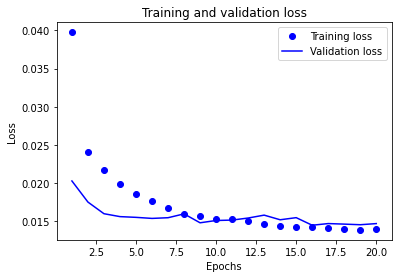

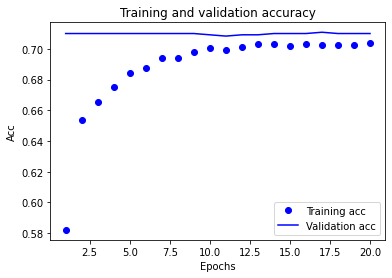

In [20]:
#MLP
model = Sequential()
model.add(layers.Dense(100,activation='relu',kernel_regularizer=regularizers.l2(0.000000001),input_shape=(X.shape[1],)))
model.add(layers.Dropout(0.8))
model.add(layers.Dense(100,activation='relu',kernel_regularizer=regularizers.l2(0.000000001)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2,activation='sigmoid'))
model.compile(optimizer='rmsprop',loss=['mse'],metrics=['accuracy'])
history=model.fit(X_train,y_train,batch_size=50,epochs=20,validation_data=(X_test,y_test),shuffle=True,verbose=True)
Y_pred = model.predict(X_test)
Get_score(Y_pred,y_test)

# visualizing the model
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [ ]:
for key in history.history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


## HMP

In [11]:
hmp_features = hmp.iloc[:,4:6079].values
ground_truth = hmp.iloc[:,2:4].values
X = hmp_features
y = ground_truth


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state =42)

In [154]:
Las =Lasso(alpha = 0.000001)
Las.fit(X_train,y_train)
y_pred = Las.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.297
The Spearman's correlation coefficient is: 0.117


In [159]:
ENet =ElasticNet(l1_ratio=0.0000001)
ENet.fit(X_train,y_train)
y_pred = ENet.predict(X_test)

Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.182
The Spearman's correlation coefficient is: 0.078


In [ ]:
#SVR-Short Term memorablity
Y_short = ground_truth[:,0]
X_train, X_test, Y_train_short, Y_test_short = train_test_split(X,Y_short, test_size=0.2, random_state=42)
modelSVR_short = SVR(C=0.1).fit(X_train,Y_train_short)
predictionsSVR_short = modelSVR_short.predict(X_test)
Get_score(predictionsSVR_short,Y_test_short)

The Spearman's correlation coefficient is: 0.296


In [ ]:
#SVR-Long Term memorablity
Y_long = ground_truth[:,1]
X_train, X_test,Y_train_long, Y_test_long = train_test_split(X,Y_long, test_size=0.2, random_state=42)
Y_test_long.shape
modelSVR_long = SVR(C=0.1).fit(X_train,Y_train_long)
predictionsSVR_long = modelSVR_long.predict(X_test)
Get_score(predictionsSVR_long,Y_test_long)

The Spearman's correlation coefficient is: 0.106


In [160]:
Rid.fit(X_train,y_train)
y_pred = Rid.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.208
The Spearman's correlation coefficient is: 0.090


In [ ]:


LMregressor.fit(X_train, y_train)
y_pred = LMregressor.predict(X_test)
Get_score(y_pred, y_test)

DTregressor.fit(X_train, y_train)
y_pred = DTregressor.predict(X_test)
Get_score(y_pred, y_test)

RFregressor.fit(X_train, y_train)
y_pred = RFregressor.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.036
The Spearman's correlation coefficient is: -0.004
The Spearman's correlation coefficient is: 0.101
The Spearman's correlation coefficient is: 0.013
The Spearman's correlation coefficient is: 0.298
The Spearman's correlation coefficient is: 0.121


In [ ]:
# save
joblib.dump(RFregressor, "/content/drive/MyDrive/CA684_Assignment_dao/random_forest_regressor.joblib")

['/content/drive/MyDrive/CA684_Assignment_dao/random_forest_regressor.joblib']

In [ ]:
# load, no need to initialize the loaded_rf
loaded_RFregressor = joblib.load("/content/drive/MyDrive/CA684_Assignment_dao/random_forest_regressor.joblib")

In [ ]:
y_pred =loaded_RFregressor.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.874
The Spearman's correlation coefficient is: 0.875


In [ ]:
predictions = np.asarray(y_pred)
np.savetext("predictions.csv", predictions, delimiter = ",")

In [13]:
model1 = Sequential()
model1.add(layers.Dense(256,activation='tanh',kernel_regularizer=regularizers.l2(0.000000001),input_shape=(X.shape[1],)))
model1.add(layers.Dropout(0.12))
model1.add(layers.Dense(64,activation='tanh',kernel_regularizer=regularizers.l2(0.000000001)))
model1.add(layers.Dropout(0.39))
model1.add(layers.Dense(2,activation='sigmoid'))
model1.compile(optimizer='rmsprop',loss=['mse'],metrics=['accuracy'])
history=model1.fit(X_train,y_train,batch_size=50,epochs=10,validation_data=(X_test,y_test),shuffle=True,verbose=True)
Y_pred = model1.predict(X_test)
Get_score(Y_pred,y_test)

Epoch 1/10
96/96 [==============================] - 5s 43ms/step - loss: 0.0296 - accuracy: 0.6898 - val_loss: 0.0139 - val_accuracy: 0.7100
Epoch 2/10
96/96 [==============================] - 4s 38ms/step - loss: 0.0143 - accuracy: 0.7017 - val_loss: 0.0137 - val_accuracy: 0.7100
Epoch 3/10
96/96 [==============================] - 4s 38ms/step - loss: 0.0141 - accuracy: 0.7142 - val_loss: 0.0140 - val_accuracy: 0.7100
Epoch 4/10
96/96 [==============================] - 4s 38ms/step - loss: 0.0137 - accuracy: 0.6959 - val_loss: 0.0136 - val_accuracy: 0.7100
Epoch 5/10
96/96 [==============================] - 4s 37ms/step - loss: 0.0142 - accuracy: 0.7092 - val_loss: 0.0137 - val_accuracy: 0.7100
Epoch 6/10
96/96 [==============================] - 4s 37ms/step - loss: 0.0139 - accuracy: 0.6925 - val_loss: 0.0137 - val_accuracy: 0.7100
Epoch 7/10
96/96 [==============================] - 4s 38ms/step - loss: 0.0141 - accuracy: 0.7219 - val_loss: 0.0144 - val_accuracy: 0.7100
Epoch 8/10
96

## COLORHIS

In [14]:
colorHis_features = colorHis.iloc[:,4:2308].values
ground_truth = colorHis.iloc[:,2:4].values
X = colorHis_features
y = ground_truth

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)

In [20]:
#Lasso
Las =Lasso(alpha = 0.01)
Las.fit(X_train,y_train)
y_pred = Las.predict(X_test)
Get_score(y_pred, y_test)
#Elastic Network
ENet =ElasticNet(l1_ratio=0.001)
ENet.fit(X_train,y_train)
y_pred = ENet.predict(X_test)
Get_score(y_pred, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.607065246989154, tolerance: 0.0031603040479166633
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.43419217574143, tolerance: 0.009935011935916671
  positive)


The Spearman's correlation coefficient is: 0.046
The Spearman's correlation coefficient is: 0.029


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.703681553782976, tolerance: 0.0031603040479166633
  positive)


The Spearman's correlation coefficient is: 0.044
The Spearman's correlation coefficient is: 0.028


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.419959341814643, tolerance: 0.009935011935916671
  positive)


In [17]:
#Ridge
Rid.fit(X_train,y_train)
y_pred = Rid.predict(X_test)
Get_score(y_pred, y_test)


#SVR-Short Term memorablity
Y_short = ground_truth[:,0]
X_train, X_test, Y_train_short, Y_test_short = train_test_split(X,Y_short, test_size=0.2, random_state=42)
modelSVR_short = SVR(C=0.1).fit(X_train,Y_train_short)
predictionsSVR_short = modelSVR_short.predict(X_test)
Get_score(predictionsSVR_short,Y_test_short)

#SVR-Long Term memorablity
Y_long = ground_truth[:,1]
X_train, X_test,Y_train_long, Y_test_long = train_test_split(X,Y_long, test_size=0.2, random_state=42)
Y_test_long.shape
modelSVR_long = SVR(C=0.1).fit(X_train,Y_train_long)
predictionsSVR_long = modelSVR_long.predict(X_test)
Get_score(predictionsSVR_long,Y_test_long)

The Spearman's correlation coefficient is: 0.044
The Spearman's correlation coefficient is: 0.024


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.7125943205942775, tolerance: 0.0031603040479166633
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.41769524199685, tolerance: 0.009935011935916671
  positive)


The Spearman's correlation coefficient is: 0.044
The Spearman's correlation coefficient is: 0.029


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.71261356894116, tolerance: 0.0031603040479166633
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.41773422748077, tolerance: 0.009935011935916671
  positive)


The Spearman's correlation coefficient is: 0.044
The Spearman's correlation coefficient is: 0.029
The Spearman's correlation coefficient is: 0.252
The Spearman's correlation coefficient is: 0.082


In [ ]:


LMregressor.fit(X_train, y_train)
y_pred = LMregressor.predict(X_test)
Get_score(y_pred, y_test)

DTregressor.fit(X_train, y_train)
y_pred = DTregressor.predict(X_test)
Get_score(y_pred, y_test)

RFregressor.fit(X_train, y_train)
y_pred = RFregressor.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.045
The Spearman's correlation coefficient is: 0.024
The Spearman's correlation coefficient is: 0.051
The Spearman's correlation coefficient is: 0.030
The Spearman's correlation coefficient is: 0.290
The Spearman's correlation coefficient is: 0.102


In [ ]:
# save
joblib.dump(RFregressor, "/content/drive/MyDrive/CA684_Assignment_dao/RFregressor_colorHis.joblib")

['/content/drive/MyDrive/CA684_Assignment_dao/RFregressor_colorHis.joblib']

In [ ]:
# load, no need to initialize the loaded_rf
loaded_RFregressor = joblib.load("/content/drive/MyDrive/CA684_Assignment_dao/RFregressor_colorHis.joblib")

In [ ]:
y_pred =loaded_RFregressor.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.290
The Spearman's correlation coefficient is: 0.102


In [16]:
#MLP
model1 = Sequential()
model1.add(layers.Dense(256,activation='tanh',kernel_regularizer=regularizers.l2(0.000000001),input_shape=(X.shape[1],)))
model1.add(layers.Dropout(0.12))
model1.add(layers.Dense(64,activation='tanh',kernel_regularizer=regularizers.l2(0.000000001)))
model1.add(layers.Dropout(0.39))
model1.add(layers.Dense(2,activation='sigmoid'))
model1.compile(optimizer='rmsprop',loss=['mse'],metrics=['accuracy'])
history=model1.fit(X_train,y_train,batch_size=50,epochs=10,validation_data=(X_test,y_test),shuffle=True,verbose=True)
Y_pred = model1.predict(X_test)
Get_score(Y_pred,y_test)

Epoch 1/10
96/96 [==============================] - 2s 19ms/step - loss: 0.0446 - accuracy: 0.5768 - val_loss: 0.0209 - val_accuracy: 0.7083
Epoch 2/10
96/96 [==============================] - 2s 17ms/step - loss: 0.0243 - accuracy: 0.6115 - val_loss: 0.0232 - val_accuracy: 0.5967
Epoch 3/10
96/96 [==============================] - 2s 17ms/step - loss: 0.0216 - accuracy: 0.6108 - val_loss: 0.0179 - val_accuracy: 0.7108
Epoch 4/10
96/96 [==============================] - 2s 17ms/step - loss: 0.0185 - accuracy: 0.6478 - val_loss: 0.0151 - val_accuracy: 0.7100
Epoch 5/10
96/96 [==============================] - 2s 17ms/step - loss: 0.0170 - accuracy: 0.6424 - val_loss: 0.0144 - val_accuracy: 0.7100
Epoch 6/10
96/96 [==============================] - 2s 17ms/step - loss: 0.0161 - accuracy: 0.7011 - val_loss: 0.0144 - val_accuracy: 0.7100
Epoch 7/10
96/96 [==============================] - 2s 16ms/step - loss: 0.0150 - accuracy: 0.6991 - val_loss: 0.0142 - val_accuracy: 0.7100
Epoch 8/10
96

## InceptionV3

In [21]:
inceptionV3_features = inceptionV3.iloc[:,4:3004].values
ground_truth = inceptionV3.iloc[:,2:4].values
X = inceptionV3_features
y = ground_truth

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20,random_state =42)

In [24]:
#Ridge
Rid.fit(X_train,y_train)
y_pred = Rid.predict(X_test)
Get_score(y_pred, y_test)
#Lasso
Las =Lasso(alpha = 0.000001)
Las.fit(X_train,y_train)
y_pred = Las.predict(X_test)
Get_score(y_pred, y_test)
#Elastic Network
ENet =ElasticNet(l1_ratio=0.0000001)
ENet.fit(X_train,y_train)
y_pred = ENet.predict(X_test)
Get_score(y_pred, y_test)



The Spearman's correlation coefficient is: 0.157
The Spearman's correlation coefficient is: 0.093


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.761346521175241, tolerance: 0.009935011935916671
  positive)


The Spearman's correlation coefficient is: 0.143
The Spearman's correlation coefficient is: 0.087
The Spearman's correlation coefficient is: 0.161
The Spearman's correlation coefficient is: 0.091


In [25]:
#SVR-Short Term memorablity
Y_short = ground_truth[:,0]
X_train, X_test, Y_train_short, Y_test_short = train_test_split(X,Y_short, test_size=0.2, random_state=42)
modelSVR_short = SVR(C=0.1).fit(X_train,Y_train_short)
predictionsSVR_short = modelSVR_short.predict(X_test)
Get_score(predictionsSVR_short,Y_test_short)

#SVR-Long Term memorablity
Y_long = ground_truth[:,1]
X_train, X_test,Y_train_long, Y_test_long = train_test_split(X,Y_long, test_size=0.2, random_state=42)
Y_test_long.shape
modelSVR_long = SVR(C=0.1).fit(X_train,Y_train_long)
predictionsSVR_long = modelSVR_long.predict(X_test)
Get_score(predictionsSVR_long,Y_test_long)

The Spearman's correlation coefficient is: 0.156
The Spearman's correlation coefficient is: 0.055


In [ ]:


LMregressor.fit(X_train, y_train)
y_pred = LMregressor.predict(X_test)
Get_score(y_pred, y_test)

DTregressor.fit(X_train, y_train)
y_pred = DTregressor.predict(X_test)
Get_score(y_pred, y_test)

RFregressor.fit(X_train, y_train)
y_pred = RFregressor.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.094
The Spearman's correlation coefficient is: 0.052
The Spearman's correlation coefficient is: 0.092
The Spearman's correlation coefficient is: 0.035
The Spearman's correlation coefficient is: 0.120
The Spearman's correlation coefficient is: 0.013


In [ ]:
# save
joblib.dump(RFregressor, "/content/drive/MyDrive/CA684_Assignment_dao/RFregressor_inceptionv3.joblib")

['/content/drive/MyDrive/CA684_Assignment_dao/RFregressor_inceptionv3.joblib']

In [ ]:
# load, no need to initialize the loaded_rf
loaded_RFregressor_inceptionv3 = joblib.load("/content/drive/MyDrive/CA684_Assignment_dao/RFregressor_inceptionv3.joblib")

In [ ]:
y_pred =loaded_RFregressor_inceptionv3.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.120
The Spearman's correlation coefficient is: 0.013


In [ ]:
#MLP
model1 = Sequential()
model1.add(layers.Dense(100,activation='relu',kernel_regularizer=regularizers.l2(0.000000001),input_shape=(X.shape[1],)))
model1.add(layers.Dropout(0.8))
model1.add(layers.Dense(100,activation='relu',kernel_regularizer=regularizers.l2(0.000000001)))
model1.add(layers.Dropout(0.2))
model1.add(layers.Dense(2,activation='sigmoid'))
model1.compile(optimizer='rmsprop',loss=['mse'],metrics=['accuracy'])
history=model1.fit(X_train,y_train,batch_size=50,epochs=10,validation_data=(X_test,y_test),shuffle=True,verbose=True)
Y_pred = model1.predict(X_test)
Get_score(Y_pred,y_test)

Epoch 1/10
96/96 [==============================] - 1s 9ms/step - loss: 0.0476 - accuracy: 0.5419 - val_loss: 0.0143 - val_accuracy: 0.7100
Epoch 2/10
96/96 [==============================] - 1s 8ms/step - loss: 0.0159 - accuracy: 0.6916 - val_loss: 0.0139 - val_accuracy: 0.7100
Epoch 3/10
96/96 [==============================] - 1s 8ms/step - loss: 0.0151 - accuracy: 0.6965 - val_loss: 0.0140 - val_accuracy: 0.7100
Epoch 4/10
96/96 [==============================] - 1s 8ms/step - loss: 0.0145 - accuracy: 0.7086 - val_loss: 0.0138 - val_accuracy: 0.7100
Epoch 5/10
96/96 [==============================] - 1s 8ms/step - loss: 0.0148 - accuracy: 0.7007 - val_loss: 0.0138 - val_accuracy: 0.7100
Epoch 6/10
96/96 [==============================] - 1s 7ms/step - loss: 0.0141 - accuracy: 0.7050 - val_loss: 0.0138 - val_accuracy: 0.7100
Epoch 7/10
96/96 [==============================] - 1s 7ms/step - loss: 0.0141 - accuracy: 0.6974 - val_loss: 0.0138 - val_accuracy: 0.7100
Epoch 8/10
96/96 [==

In [26]:
#MLP
model1 = Sequential()
model1.add(layers.Dense(256,activation='tanh',kernel_regularizer=regularizers.l2(0.000000001),input_shape=(X.shape[1],)))
model1.add(layers.Dropout(0.12))
model1.add(layers.Dense(64,activation='tanh',kernel_regularizer=regularizers.l2(0.000000001)))
model1.add(layers.Dropout(0.39))
model1.add(layers.Dense(2,activation='sigmoid'))
model1.compile(optimizer='rmsprop',loss=['mse'],metrics=['accuracy'])
history=model1.fit(X_train,y_train,batch_size=50,epochs=10,validation_data=(X_test,y_test),shuffle=True,verbose=True)
Y_pred = model1.predict(X_test)
Get_score(Y_pred,y_test)

Epoch 1/10
96/96 [==============================] - 3s 25ms/step - loss: 0.0307 - accuracy: 0.6572 - val_loss: 0.0146 - val_accuracy: 0.7100
Epoch 2/10
96/96 [==============================] - 2s 22ms/step - loss: 0.0149 - accuracy: 0.6965 - val_loss: 0.0142 - val_accuracy: 0.7100
Epoch 3/10
96/96 [==============================] - 2s 22ms/step - loss: 0.0141 - accuracy: 0.6865 - val_loss: 0.0147 - val_accuracy: 0.7100
Epoch 4/10
96/96 [==============================] - 2s 22ms/step - loss: 0.0141 - accuracy: 0.7070 - val_loss: 0.0146 - val_accuracy: 0.7100
Epoch 5/10
96/96 [==============================] - 2s 22ms/step - loss: 0.0142 - accuracy: 0.6984 - val_loss: 0.0146 - val_accuracy: 0.7100
Epoch 6/10
96/96 [==============================] - 2s 22ms/step - loss: 0.0143 - accuracy: 0.7047 - val_loss: 0.0141 - val_accuracy: 0.7100
Epoch 7/10
96/96 [==============================] - 2s 22ms/step - loss: 0.0144 - accuracy: 0.7030 - val_loss: 0.0143 - val_accuracy: 0.7100
Epoch 8/10
96

##Aesthetic

In [7]:
ground_truth = pd.read_csv('Ground-truth/ground-truth.csv')
ground_truth = ground_truth.drop(['nb_short-term_annotations', 'nb_long-term_annotations'], axis=1)

In [28]:
aesthetic_median

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108
0,video663.webm,0.058507,0.734303,0.554292,0.600793,0.347501,0.533896,61.804137,0.068871,0.000272,2.0,18.0,0.05,0.50,0.851601,18.0,0.000000,0.000000,0.000000,0.003153,0.003254,0.000000,0.003254,0.003254,0.003254,9.0,0.328731,0.294457,58.0,216.0,0.726790,0.0,0.0,0.029277,0.009930,0.003525,7.341380,6.621001,5.685807,0.007023,...,0.061699,0.044219,0.040851,0.052379,0.045062,0.754122,0.623777,0.744723,0.697886,0.739015,0.640387,0.159245,0.287039,0.321257,0.307690,1.131822,0.302131,0.478332,0.234689,0.234689,0.464428,0.598327,0.884759,0.437961,0.898943,0.528950,0.139639,0.082726,0.006701,0.002926,-0.007621,-0.000055,0.817253,0.022315,0.138616,0.829646,0.0,0.429150,-0.447410,0.108491
1,video6633.webm,0.581810,0.194872,0.531678,0.125891,0.480966,0.358678,52.473407,0.604938,0.000302,2.0,18.0,0.05,0.50,0.772727,18.0,0.276161,0.949043,0.786576,0.864610,1.459549,2.037820,2.010496,3.439723,5.247894,9.0,0.476793,0.391343,99.0,154.0,0.352407,0.0,0.0,0.020502,0.014638,0.005407,5.300602,4.868283,4.798607,-0.010021,...,0.607306,0.381004,0.340933,0.602290,0.574308,0.190684,0.242257,0.262524,0.089257,0.117701,0.594114,0.045198,0.073597,0.484025,0.442133,1.597913,0.119987,0.192165,3.103221,3.103221,0.473655,0.694643,0.952657,0.505598,0.481609,0.039222,0.176849,0.040903,0.001147,0.002180,-0.001669,-0.000008,0.877948,0.280758,0.229451,1.477636,0.0,0.391471,0.060211,0.338636
2,video6635.webm,0.604572,0.657199,0.465797,0.526192,0.323581,0.476609,56.950678,0.600000,0.025879,2.0,17.0,0.05,0.50,0.606219,18.0,0.000084,0.000349,0.000888,0.133072,0.000521,0.000877,0.153781,0.154507,0.154557,9.0,0.314131,0.280397,66.0,173.0,0.676752,0.0,0.0,0.032379,0.014033,0.005080,6.138215,6.817259,7.249521,-0.032182,...,0.606272,0.596026,0.602340,0.589654,0.592583,0.739536,0.272226,0.559406,0.297302,0.327257,0.403357,0.644141,0.670140,0.676132,0.672393,0.727653,1.673944,1.639132,0.460414,0.460414,0.505202,0.569160,0.704965,0.505761,0.204184,0.675914,0.169505,0.019740,0.025946,0.000249,0.000074,-0.000005,0.103966,0.046547,0.519998,1.098700,0.0,0.265116,0.340027,0.035195
3,video6637.webm,0.141382,0.218025,0.341507,0.124468,0.306108,0.481848,51.203502,0.166667,0.000389,3.0,16.0,0.10,0.50,0.528233,17.0,0.211523,0.150342,0.366948,1.259084,1.238053,0.520253,1.227052,1.323680,1.774546,9.0,0.311975,0.299320,55.0,104.0,0.519861,0.0,0.0,0.034262,0.017544,0.006136,6.350336,6.256131,6.203816,0.010258,...,0.133742,0.164098,0.113424,0.124538,0.154363,0.204238,0.261588,0.137761,0.281860,0.325721,0.387833,0.223612,0.389716,0.271048,0.233768,1.064785,0.604303,1.090317,0.537341,0.537341,0.586517,0.342995,0.446831,0.599706,0.279681,0.105633,0.164282,0.060408,0.010828,-0.023740,0.001264,0.000184,0.046312,0.050476,0.189169,0.487030,0.0,0.273047,0.151776,0.441400
4,video6634.webm,0.168417,0.089344,0.541439,0.153814,0.518419,0.240795,50.625188,0.125000,0.000553,2.0,17.0,0.05,0.50,0.901786,17.0,0.172053,0.397873,0.736124,2.634164,2.302000,0.810022,1.935664,2.644606,3.099307,9.0,0.522239,0.462534,79.0,202.0,0.650309,0.0,0.0,0.045983,0.022741,0.008003,7.224600,7.294450,7.324708,0.011352,...,0.195038,0.133063,0.302486,0.266077,0.143957,0.097494,0.080860,0.054758,0.078787,0.076744,0.320708,0.800914,0.659215,0.654679,0.649544,0.924679,2.324563,1.923246,1.860414,1.860414,0.696142,0.258678,0.932650,0.419849,0.602226,0.914479,0.124725,0.090859,0.001478,0.003772,-0.004476,-0.000000,0.000000,0.169706,0.044193,1.401191,0.0,0.299827,0.181719,0.402697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [8]:
aesthetic_GT = pd.merge(ground_truth, aesthetic, right_on='key_0', left_on='video')

In [9]:
aesthetic_mean_GT = pd.merge(ground_truth, aesthetic_mean, right_on='Unnamed: 0', left_on='video')
aesthetic_median_GT = pd.merge(ground_truth, aesthetic_median, right_on='Unnamed: 0', left_on='video')

In [ ]:
aesthetic_mean_GT.head()

,video,short-term_memorability,long-term_memorability,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,...,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108
0,video3.webm,0.924,0.846,video3.webm,0.183890,0.713733,0.202302,0.610132,0.124278,0.691408,54.980466,0.098504,0.000973,2.0,17.000000,0.050000,0.500000,0.540571,17.000000,0.007051,0.010864,0.020811,0.750127,1.947558,0.024482,1.940952,1.953498,1.969214,9.000000,0.123305,0.083319,40.200000,119.133333,0.736961,0.0,0.0,0.018839,0.019887,0.008012,6.306582,...,0.191268,0.235910,0.081830,0.054301,0.050267,0.711456,0.648913,0.831294,0.872862,0.908399,0.172397,0.237053,0.296888,0.158871,0.157050,0.309982,0.453621,0.535900,2.607416,2.575026,0.451880,0.592427,0.546418,0.543654,0.483560,0.141647,0.126999,0.084872,0.067334,0.005117,0.001727,-0.002716,0.290079,0.295183,0.352099,0.570387,0.0,3.787912,0.236836,0.748159
1,video4.webm,0.923,0.667,video4.webm,0.147255,0.550718,0.460299,0.424981,0.341784,0.397867,47.395202,0.119074,0.002255,2.0,15.866667,0.050000,0.500000,0.826289,17.133333,0.776495,0.207868,2.450325,2.881214,1.161807,5.660029,2.198159,1.838155,9.627379,8.666667,0.353321,0.293568,92.800000,236.066667,0.607066,0.0,0.0,0.026227,0.023199,0.008717,7.569950,...,0.122846,0.282208,0.270204,0.227854,0.191722,0.580534,0.473213,0.429231,0.452448,0.615249,0.491907,0.295810,0.305050,0.258353,0.235310,1.118414,0.657158,0.676696,3.031024,3.031024,0.511390,0.419739,0.478227,0.504535,0.414802,0.297049,0.161513,0.015492,0.009617,0.001029,-0.000572,-0.000242,0.700697,0.302694,0.378382,0.795025,0.0,0.951803,-0.682860,-2.001414
2,video6.webm,0.863,0.700,video6.webm,0.063933,0.826933,0.214129,0.719341,0.130606,0.720948,60.477196,0.069356,0.000439,1.4,18.000000,0.020000,0.500000,0.924190,18.000000,0.001637,0.010074,0.014489,0.500980,0.502217,0.014097,0.493062,0.506466,0.511235,9.000000,0.123966,0.077253,31.066667,115.000000,0.754313,0.0,0.0,0.011761,0.010903,0.004124,6.834009,...,0.062272,0.064400,0.067329,0.065623,0.064443,0.782440,0.881908,0.791506,0.923454,0.824238,0.329253,0.095038,0.231571,0.060834,0.141011,0.570618,0.162258,0.418913,0.169017,0.169017,0.448084,0.501749,0.464952,0.311662,0.657265,0.799060,0.103765,0.091687,0.086960,0.005920,0.001647,0.002375,0.477762,0.018579,0.187449,0.502680,0.0,0.457098,-0.542637,0.395342
3,video8.webm,0.922,0.818,video8.webm,0.367527,0.133869,0.746074,0.169317,0.696747,0.461253,48.238377,0.578151,0.008423,3.0,13.600000,0.463333,0.500000,0.562964,16.133333,6.825503,0.197415,20.507375,20.522032,1.665291,39.529472,9.047156,2.007109,60.369204,8.000000,0.699659,0.689977,60.533333,161.200000,0.465305,0.0,0.0,0.033552,0.014568,0.005651,5.468727,...,0.494286,0.097856,0.167152,0.200255,0.130056,0.108473,0.309089,0.452338,0.317301,0.374262,0.770160,0.720509,0.698576,0.742600,0.696178,2.193078,1.744370,1.548269,3.599255,3.599255,0.356183,0.746952,0.572307,0.504349,0.466511,0.504178,0.130575,0.067780,0.047460,-0.000178,0.000530,0.000377,0.975746,0.400644,0.484409,0.970943,0.0,0.463811,1.180469,2.136393
4,video10.webm,0.950,0.900,video10.webm,0.402878,0.389358,0.564687,0.400378,0.471548,0.212616,39.483275,0.583333,0.040655,6.8,8.066667,0.500000,0.413333,0.239331,8.600000,3.070592,1.557911,8.884794,9.461271,6.350437,23.912039,8.909535,10.611212,42.646402,7.400000,0.464560,0.381512,95.466667,249.133333,0.642852,0.0,0.0,0.046507,0.048813,0.018281,7.634885,...,0.317891,0.596301,0.728286,0.683629,0.478286,0.339076,0.558744,0.498319,0.473862,0.498463,0.643468,0.368442,0.322318,0.369717,0.314763,1.608512,0.835410,0.762240,5.184340,4.828543,0.569684,0.300755,0.490445,0.524774,0.348081,0.609754,0.158110,0.073119,0.022454,-0.006075,0.008432,0.000139,0.150006,0.442870,0.360719,1.436340,0.0,-1.295210,-0.036251,1.235213


### Aesthetic Mean

In [10]:
#aesthetic mean
aesthetic_mean_features = aesthetic_mean_GT.iloc[:,4:113].values
ground_truth = aesthetic_mean_GT.iloc[:,1:3].values
X = aesthetic_mean_features
y = ground_truth

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)

In [ ]:
Rid.fit(X_train,y_train)
y_pred = Rid.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.272
The Spearman's correlation coefficient is: 0.118


In [33]:

#Lasso
Las =Lasso(alpha = 0.000001)
Las.fit(X_train,y_train)
y_pred = Las.predict(X_test)
Get_score(y_pred, y_test)
#Elastic Network
ENet =ElasticNet(l1_ratio=0.0000001)
ENet.fit(X_train,y_train)
y_pred = ENet.predict(X_test)
Get_score(y_pred, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.255828284566835, tolerance: 0.0031603040479166646
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46.53454936456654, tolerance: 0.009935011935916671
  positive)


The Spearman's correlation coefficient is: 0.280
The Spearman's correlation coefficient is: 0.123
The Spearman's correlation coefficient is: 0.230
The Spearman's correlation coefficient is: 0.090


In [ ]:
#SVR-Short Term memorablity
Y_short = ground_truth[:,0]
X_train, X_test, Y_train_short, Y_test_short = train_test_split(X,Y_short, test_size=0.2, random_state=42)
modelSVR_short = SVR(C=0.1).fit(X_train,Y_train_short)
predictionsSVR_short = modelSVR_short.predict(X_test)
Get_score(predictionsSVR_short,Y_test_short)

The Spearman's correlation coefficient is: 0.182


In [ ]:
#SVR-Long Term memorablity
Y_long = ground_truth[:,1]
X_train, X_test,Y_train_long, Y_test_long = train_test_split(X,Y_long, test_size=0.2, random_state=42)
Y_test_long.shape
modelSVR_long = SVR(C=0.1).fit(X_train,Y_train_long)
predictionsSVR_long = modelSVR_long.predict(X_test)
Get_score(predictionsSVR_long,Y_test_long)

The Spearman's correlation coefficient is: 0.087


In [ ]:
#aesthetic mean
LMregressor.fit(X_train, y_train)
y_pred = LMregressor.predict(X_test)
Get_score(y_pred, y_test)


DTregressor.fit(X_train, y_train)
y_pred = DTregressor.predict(X_test)
Get_score(y_pred, y_test)

RFregressor.fit(X_train, y_train)
y_pred = RFregressor.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.283
The Spearman's correlation coefficient is: 0.124
The Spearman's correlation coefficient is: 0.095
The Spearman's correlation coefficient is: 0.049
The Spearman's correlation coefficient is: 0.315
The Spearman's correlation coefficient is: 0.133


In [43]:
#MLP
model1 = Sequential()
model1.add(layers.Dense(256,activation='tanh',kernel_regularizer=regularizers.l2(0.000000001),input_shape=(X.shape[1],)))
model1.add(layers.Dropout(0.12))
model1.add(layers.Dense(64,activation='tanh',kernel_regularizer=regularizers.l2(0.000000001)))
model1.add(layers.Dropout(0.39))
model1.add(layers.Dense(2,activation='sigmoid'))
model1.compile(optimizer='rmsprop',loss=['mse'],metrics=['accuracy'])
history=model1.fit(X_train,y_train,batch_size=50,epochs=10,validation_data=(X_test,y_test),shuffle=True,verbose=True)
Y_pred = model1.predict(X_test)
Get_score(Y_pred,y_test)

Epoch 1/10
96/96 [==============================] - 1s 6ms/step - loss: 0.0378 - accuracy: 0.5728 - val_loss: 0.0186 - val_accuracy: 0.7100
Epoch 2/10
96/96 [==============================] - 0s 3ms/step - loss: 0.0262 - accuracy: 0.5857 - val_loss: 0.0232 - val_accuracy: 0.6008
Epoch 3/10
96/96 [==============================] - 0s 4ms/step - loss: 0.0242 - accuracy: 0.5740 - val_loss: 0.0165 - val_accuracy: 0.7083
Epoch 4/10
96/96 [==============================] - 0s 3ms/step - loss: 0.0209 - accuracy: 0.5939 - val_loss: 0.0162 - val_accuracy: 0.7092
Epoch 5/10
96/96 [==============================] - 0s 3ms/step - loss: 0.0183 - accuracy: 0.6211 - val_loss: 0.0147 - val_accuracy: 0.7092
Epoch 6/10
96/96 [==============================] - 0s 3ms/step - loss: 0.0174 - accuracy: 0.6603 - val_loss: 0.0144 - val_accuracy: 0.7092
Epoch 7/10
96/96 [==============================] - 0s 3ms/step - loss: 0.0161 - accuracy: 0.6803 - val_loss: 0.0152 - val_accuracy: 0.7092
Epoch 8/10
96/96 [==

### Aesthetic Median

In [11]:
#aesthetic median
aesthetic_median_features = aesthetic_median_GT.iloc[:,4:113].values
ground_truth = aesthetic_median_GT.iloc[:,1:3].values
X = aesthetic_median_features
y = ground_truth

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)

In [36]:

#Lasso
Las =Lasso(alpha = 0.000001)
Las.fit(X_train,y_train)
y_pred = Las.predict(X_test)
Get_score(y_pred, y_test)
#Elastic Network
ENet =ElasticNet(l1_ratio=0.0000001)
ENet.fit(X_train,y_train)
y_pred = ENet.predict(X_test)
Get_score(y_pred, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.066694540400889, tolerance: 0.0031603040479166646
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.35453646790744, tolerance: 0.009935011935916671
  positive)


The Spearman's correlation coefficient is: 0.268
The Spearman's correlation coefficient is: 0.113
The Spearman's correlation coefficient is: 0.231
The Spearman's correlation coefficient is: 0.091


In [ ]:
Rid.fit(X_train,y_train)
y_pred = Rid.predict(X_test)
Get_score(y_pred, y_test)
#SVR-Short Term memorablity
Y_short = ground_truth[:,0]
X_train, X_test, Y_train_short, Y_test_short = train_test_split(X,Y_short, test_size=0.2, random_state=42)
modelSVR_short = SVR(C=0.1).fit(X_train,Y_train_short)
predictionsSVR_short = modelSVR_short.predict(X_test)
Get_score(predictionsSVR_short,Y_test_short)

#SVR-Long Term memorablity
Y_long = ground_truth[:,1]
X_train, X_test,Y_train_long, Y_test_long = train_test_split(X,Y_long, test_size=0.2, random_state=42)
Y_test_long.shape
modelSVR_long = SVR(C=0.1).fit(X_train,Y_train_long)
predictionsSVR_long = modelSVR_long.predict(X_test)
Get_score(predictionsSVR_long,Y_test_long)

LMregressor.fit(X_train, y_train)
y_pred = LMregressor.predict(X_test)
Get_score(y_pred, y_test)

DTregressor.fit(X_train, y_train)
y_pred = DTregressor.predict(X_test)
Get_score(y_pred, y_test)

RFregressor.fit(X_train, y_train)
y_pred = RFregressor.predict(X_test)
Get_score(y_pred, y_test)


The Spearman's correlation coefficient is: 0.272
The Spearman's correlation coefficient is: 0.118
The Spearman's correlation coefficient is: 0.171
The Spearman's correlation coefficient is: 0.096
The Spearman's correlation coefficient is: 0.271
The Spearman's correlation coefficient is: 0.111
The Spearman's correlation coefficient is: 0.137
The Spearman's correlation coefficient is: 0.003
The Spearman's correlation coefficient is: 0.318
The Spearman's correlation coefficient is: 0.113


In [46]:
#MLP
model1 = Sequential()
model1.add(layers.Dense(256,activation='tanh',kernel_regularizer=regularizers.l2(0.000000001),input_shape=(X.shape[1],)))
model1.add(layers.Dropout(0.12))
model1.add(layers.Dense(64,activation='tanh',kernel_regularizer=regularizers.l2(0.000000001)))
model1.add(layers.Dropout(0.39))
model1.add(layers.Dense(2,activation='sigmoid'))
model1.compile(optimizer='rmsprop',loss=['mse'],metrics=['accuracy'])
history=model1.fit(X_train,y_train,batch_size=50,epochs=10,validation_data=(X_test,y_test),shuffle=True,verbose=True)
Y_pred = model1.predict(X_test)
Get_score(Y_pred,y_test)

Epoch 1/10
96/96 [==============================] - 1s 6ms/step - loss: 0.0331 - accuracy: 0.6058 - val_loss: 0.0230 - val_accuracy: 0.6400
Epoch 2/10
96/96 [==============================] - 0s 4ms/step - loss: 0.0249 - accuracy: 0.6029 - val_loss: 0.0200 - val_accuracy: 0.5258
Epoch 3/10
96/96 [==============================] - 0s 4ms/step - loss: 0.0232 - accuracy: 0.6192 - val_loss: 0.0186 - val_accuracy: 0.7100
Epoch 4/10
96/96 [==============================] - 0s 3ms/step - loss: 0.0196 - accuracy: 0.6313 - val_loss: 0.0189 - val_accuracy: 0.7075
Epoch 5/10
96/96 [==============================] - 0s 4ms/step - loss: 0.0178 - accuracy: 0.6298 - val_loss: 0.0142 - val_accuracy: 0.7100
Epoch 6/10
96/96 [==============================] - 0s 3ms/step - loss: 0.0161 - accuracy: 0.6711 - val_loss: 0.0147 - val_accuracy: 0.7100
Epoch 7/10
96/96 [==============================] - 0s 4ms/step - loss: 0.0150 - accuracy: 0.6849 - val_loss: 0.0147 - val_accuracy: 0.7100
Epoch 8/10
96/96 [==

### concat mean and median

In [12]:
aesthetic_features = aesthetic_GT.iloc[:,5:223].values
ground_truth = aesthetic_GT.iloc[:,1:3].values
X = aesthetic_features
y = ground_truth

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)

In [39]:

#Lasso
Las =Lasso(alpha = 0.000001)
Las.fit(X_train,y_train)
y_pred = Las.predict(X_test)
Get_score(y_pred, y_test)
#Elastic Network
ENet =ElasticNet(l1_ratio=0.0000001)
ENet.fit(X_train,y_train)
y_pred = ENet.predict(X_test)
Get_score(y_pred, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.709487447335155, tolerance: 0.0031603040479166646
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46.57683940705527, tolerance: 0.009935011935916671
  positive)


The Spearman's correlation coefficient is: 0.261
The Spearman's correlation coefficient is: 0.109


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.921196066499444, tolerance: 0.0031603040479166646
  positive)


The Spearman's correlation coefficient is: 0.244
The Spearman's correlation coefficient is: 0.093


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47.3201674742256, tolerance: 0.009935011935916671
  positive)


In [ ]:
Rid.fit(X_train,y_train)
y_pred = Rid.predict(X_test)
Get_score(y_pred, y_test)
#SVR-Short Term memorablity
Y_short = ground_truth[:,0]
X_train, X_test, Y_train_short, Y_test_short = train_test_split(X,Y_short, test_size=0.2, random_state=42)
modelSVR_short = SVR(C=0.1).fit(X_train,Y_train_short)
predictionsSVR_short = modelSVR_short.predict(X_test)
Get_score(predictionsSVR_short,Y_test_short)

#SVR-Long Term memorablity
Y_long = ground_truth[:,1]
X_train, X_test,Y_train_long, Y_test_long = train_test_split(X,Y_long, test_size=0.2, random_state=42)
Y_test_long.shape
modelSVR_long = SVR(C=0.1).fit(X_train,Y_train_long)
predictionsSVR_long = modelSVR_long.predict(X_test)
Get_score(predictionsSVR_long,Y_test_long)

LMregressor.fit(X_train, y_train)
y_pred = LMregressor.predict(X_test)
Get_score(y_pred, y_test)

DTregressor.fit(X_train, y_train)
y_pred = DTregressor.predict(X_test)
Get_score(y_pred, y_test)

RFregressor.fit(X_train, y_train)
y_pred = RFregressor.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.261
The Spearman's correlation coefficient is: 0.112
The Spearman's correlation coefficient is: 0.177
The Spearman's correlation coefficient is: 0.093
The Spearman's correlation coefficient is: 0.266
The Spearman's correlation coefficient is: 0.114
The Spearman's correlation coefficient is: 0.118
The Spearman's correlation coefficient is: 0.039
The Spearman's correlation coefficient is: 0.318
The Spearman's correlation coefficient is: 0.118


In [ ]:
# save
joblib.dump(RFregressor, "/content/drive/MyDrive/CA684_Assignment_dao/RFregressor_aesthetic.joblib")
# load, no need to initialize the loaded_rf
loaded_RFregressor_aesthetic = joblib.load("/content/drive/MyDrive/CA684_Assignment_dao/RFregressor_aesthetic.joblib")
y_pred =loaded_RFregressor_aesthetic.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.318
The Spearman's correlation coefficient is: 0.118


In [ ]:
y_test.shape

(1200, 2)

In [50]:
#MLP
model1 = Sequential()
model1.add(layers.Dense(256,activation='tanh',kernel_regularizer=regularizers.l2(0.000000001),input_shape=(X.shape[1],)))
model1.add(layers.Dropout(0.12))
model1.add(layers.Dense(64,activation='tanh',kernel_regularizer=regularizers.l2(0.000000001)))
model1.add(layers.Dropout(0.39))
model1.add(layers.Dense(2,activation='sigmoid'))
model1.compile(optimizer='rmsprop',loss=['mse'],metrics=['accuracy'])
history=model1.fit(X_train,y_train,batch_size=50,epochs=10,validation_data=(X_test,y_test),shuffle=True,verbose=True)
Y_pred = model1.predict(X_test)
Get_score(Y_pred,y_test)

Epoch 1/10
96/96 [==============================] - 1s 6ms/step - loss: 0.0318 - accuracy: 0.5573 - val_loss: 0.0181 - val_accuracy: 0.6600
Epoch 2/10
96/96 [==============================] - 0s 5ms/step - loss: 0.0259 - accuracy: 0.5520 - val_loss: 0.0171 - val_accuracy: 0.7075
Epoch 3/10
96/96 [==============================] - 0s 5ms/step - loss: 0.0233 - accuracy: 0.5774 - val_loss: 0.0158 - val_accuracy: 0.7092
Epoch 4/10
96/96 [==============================] - 0s 5ms/step - loss: 0.0197 - accuracy: 0.6041 - val_loss: 0.0156 - val_accuracy: 0.6667
Epoch 5/10
96/96 [==============================] - 0s 5ms/step - loss: 0.0181 - accuracy: 0.6338 - val_loss: 0.0145 - val_accuracy: 0.7100
Epoch 6/10
96/96 [==============================] - 0s 5ms/step - loss: 0.0155 - accuracy: 0.6678 - val_loss: 0.0145 - val_accuracy: 0.7100
Epoch 7/10
96/96 [==============================] - 0s 5ms/step - loss: 0.0160 - accuracy: 0.6798 - val_loss: 0.0149 - val_accuracy: 0.7100
Epoch 8/10
96/96 [==

In [ ]:
#MLP
model = Sequential()
model.add(layers.Dense(100,activation='relu',kernel_regularizer=regularizers.l2(0.00001),input_shape=(X.shape[1],)))
model.add(layers.Dropout(0.8))
#model.add(layers.Dense(100,activation='relu',kernel_regularizer=regularizers.l2(0.000001)))
#model.add(layers.Dropout(0.2))
model.add(layers.Dense(2,activation='sigmoid'))
model.compile(optimizer='rmsprop',loss=['mse'],metrics=['accuracy'])
history=model.fit(X_train,y_train,batch_size=50,epochs=10,validation_data=(X_test,y_test),shuffle=True,verbose=True)
Y_pred = model.predict(X_test)
Get_score(Y_pred,y_test)

## LBP

In [13]:
lbp_features = lbp.iloc[:,4:370].values
ground_truth = lbp.iloc[:,2:4].values
X = lbp_features
y = ground_truth

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)

In [58]:
#Lasso
Las =Lasso(alpha = 0.000001)
Las.fit(X_train,y_train)
y_pred = Las.predict(X_test)
Get_score(y_pred, y_test)
#Elastic Network
ENet =ElasticNet(l1_ratio=0.0000001)
ENet.fit(X_train,y_train)
y_pred = ENet.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.254
The Spearman's correlation coefficient is: 0.058
The Spearman's correlation coefficient is: 0.178
The Spearman's correlation coefficient is: 0.059


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03512870139753943, tolerance: 0.010072100437479175
  positive)


In [12]:
Rid.fit(X_train,y_train)
y_pred = Rid.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.190
The Spearman's correlation coefficient is: 0.066


In [13]:
#SVR-Short Term memorablity
Y_short = ground_truth[:,0]
X_train, X_test, Y_train_short, Y_test_short = train_test_split(X,Y_short, test_size=0.2, random_state=42)
modelSVR_short = SVR(C=0.1).fit(X_train,Y_train_short)
predictionsSVR_short = modelSVR_short.predict(X_test)
Get_score(predictionsSVR_short,Y_test_short)

The Spearman's correlation coefficient is: 0.220


In [14]:
#SVR-Long Term memorablity
Y_long = ground_truth[:,1]
X_train, X_test,Y_train_long, Y_test_long = train_test_split(X,Y_long, test_size=0.2, random_state=42)
Y_test_long.shape
modelSVR_long = SVR(C=0.1).fit(X_train,Y_train_long)
predictionsSVR_long = modelSVR_long.predict(X_test)
Get_score(predictionsSVR_long,Y_test_long)

The Spearman's correlation coefficient is: 0.079


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)

LMregressor.fit(X_train, y_train)
y_pred = LMregressor.predict(X_test)
Get_score(y_pred, y_test)

DTregressor.fit(X_train, y_train)
y_pred = DTregressor.predict(X_test)
Get_score(y_pred, y_test)

RFregressor.fit(X_train, y_train)
y_pred = RFregressor.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.177
The Spearman's correlation coefficient is: 0.048
The Spearman's correlation coefficient is: 0.111
The Spearman's correlation coefficient is: 0.025
The Spearman's correlation coefficient is: 0.296
The Spearman's correlation coefficient is: 0.103


In [ ]:
# save
joblib.dump(RFregressor, "/content/drive/MyDrive/CA684_Assignment_dao/RFregressor_lbp.joblib")

['/content/drive/MyDrive/CA684_Assignment_dao/RFregressor_lbp.joblib']

In [ ]:
# load, no need to initialize the loaded_rf
loaded_RFregressor_lbp = joblib.load("/content/drive/MyDrive/CA684_Assignment_dao/RFregressor_lbp.joblib")

In [ ]:
y_pred =loaded_RFregressor_lbp.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.300
The Spearman's correlation coefficient is: 0.092


In [ ]:
#Recurrent Neural Network
model = Sequential()
model.add(layers.Dense(100,activation='relu',kernel_regularizer=regularizers.l2(0.000000001),input_shape=(X.shape[1],)))
model.add(layers.Dropout(0.8))
model.add(layers.Dense(100,activation='relu',kernel_regularizer=regularizers.l2(0.000000001)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2,activation='sigmoid'))
model.compile(optimizer='rmsprop',loss=['mse'],metrics=['accuracy'])
history=model.fit(X_train,y_train,batch_size=50,epochs=10,validation_data=(X_test,y_test),shuffle=True,verbose=True)
Y_pred = model.predict(X_test)
Get_score(Y_pred,y_test)

Epoch 1/10
96/96 [==============================] - 1s 4ms/step - loss: 0.0433 - accuracy: 0.7055 - val_loss: 0.0135 - val_accuracy: 0.6908
Epoch 2/10
96/96 [==============================] - 0s 2ms/step - loss: 0.0163 - accuracy: 0.7129 - val_loss: 0.0137 - val_accuracy: 0.6908
Epoch 3/10
96/96 [==============================] - 0s 3ms/step - loss: 0.0152 - accuracy: 0.7055 - val_loss: 0.0134 - val_accuracy: 0.6908
Epoch 4/10
96/96 [==============================] - 0s 3ms/step - loss: 0.0147 - accuracy: 0.7088 - val_loss: 0.0134 - val_accuracy: 0.6908
Epoch 5/10
96/96 [==============================] - 0s 3ms/step - loss: 0.0148 - accuracy: 0.7070 - val_loss: 0.0134 - val_accuracy: 0.6908
Epoch 6/10
96/96 [==============================] - 0s 3ms/step - loss: 0.0138 - accuracy: 0.7233 - val_loss: 0.0134 - val_accuracy: 0.6908
Epoch 7/10
96/96 [==============================] - 0s 3ms/step - loss: 0.0138 - accuracy: 0.7096 - val_loss: 0.0134 - val_accuracy: 0.6908
Epoch 8/10
96/96 [==

# Section 3.2: Prediction models using single features preprocessed with PCA

## HMP

In [86]:
pca_hmp = PCA(n_components=45)
principalComponents_hmp = pca_hmp.fit_transform(hmp_features)
principal_hmp_Df = pd.DataFrame(data = principalComponents_hmp)
#principal_hmp_Df = pd.DataFrame(data = principalComponents_hmp
#             , columns = ['1', '2','3',"4","5","6","7","8","9","10"])


In [ ]:
principal_hmp_Df.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44
5995,-0.030595,-0.018709,0.009104,-0.000299,0.000544,-0.003411,0.008445,-0.002875,0.010175,0.001663,-0.000918,-0.000688,-0.000023,-0.000859,-0.001635,0.004711,0.002699,0.001372,0.002783,0.000358,-0.001575,0.000487,0.001660,-0.000126,0.001607,-0.002046,0.000796,-0.001380,0.000053,0.001487,0.000671,0.001145,0.000118,-0.003013,0.003078,-0.001193,-0.001496,-0.001116,-0.001847,0.000316,-0.000168,-0.000957,0.000461,-0.000040,0.000767
5996,-0.043371,-0.003090,-0.018355,-0.010504,-0.003033,-0.006135,0.011870,-0.006983,0.015289,-0.004084,0.002042,-0.006398,0.000743,0.004636,0.004975,0.004817,-0.008399,-0.001763,-0.001381,0.003625,-0.002624,0.000378,-0.000919,0.001615,0.000561,0.000448,-0.000124,-0.002237,0.001606,-0.000354,-0.000068,-0.001038,-0.000650,-0.002028,0.000351,-0.001166,-0.000108,-0.001230,-0.001751,-0.001857,0.001295,-0.001391,-0.000611,-0.001595,0.000863
5997,-0.002730,-0.007311,0.019517,0.002258,-0.004346,-0.004780,-0.005941,-0.000608,-0.003460,-0.003260,-0.002626,0.001796,0.000731,-0.004310,-0.002444,-0.002842,-0.000662,-0.001048,-0.002766,-0.000436,0.003164,0.002058,-0.000969,0.003454,0.000629,-0.001606,-0.000850,0.005170,0.002158,-0.001499,0.000918,0.001171,0.001240,-0.003490,0.000840,-0.000824,-0.000873,0.000752,-0.001440,0.001037,-0.000353,-0.000262,-0.000780,-0.000128,-0.001139
5998,-0.018289,0.048733,-0.025244,0.000141,0.023396,0.011176,-0.009362,-0.005559,0.010465,0.005175,-0.004328,-0.002238,0.015623,-0.002679,0.000144,0.000899,-0.002270,-0.003333,0.001619,0.005492,0.002005,-0.002626,-0.003679,-0.001901,-0.004742,0.001129,0.001147,0.002431,-0.000565,0.000741,0.000109,0.000295,-0.001372,-0.000699,-0.001918,-0.001144,0.001202,0.001419,0.000599,0.004157,-0.001971,0.001879,0.001960,-0.002382,-0.000364
5999,0.021012,-0.015977,0.013754,0.001942,-0.006842,0.002391,-0.004530,-0.011003,-0.000204,-0.003665,-0.001365,0.005120,-0.002890,-0.002133,0.002678,0.001851,-0.000078,-0.000712,-0.005511,-0.004625,0.000141,0.001398,-0.000009,-0.001412,-0.000110,-0.000791,0.000668,0.004670,-0.000825,-0.000163,-0.000329,0.002189,-0.002393,-0.001166,-0.001040,0.001427,0.000318,0.001323,0.000016,-0.001785,0.001109,-0.000839,0.000957,-0.000303,-0.000399


In [ ]:
print('Explained variation per principal component: {}'.format(pca_hmp.explained_variance_ratio_))

In [ ]:
pca = PCA(0.95)

In [ ]:
pca.fit(colorHis_features)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
pca.n_components_

239

In [89]:
principal_hmp_Df.shape

(6000, 45)

In [ ]:
hmp_features = principal_hmp_Df.values
ground_truth = hmp.iloc[:,2:4].values
X = hmp_features
y = ground_truth

In [ ]:
#hmp_pca, pca = PCA(0.99)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state =42)
LMregressor.fit(X_train, y_train)
y_pred = LMregressor.predict(X_test)
Get_score(y_pred, y_test)

DTregressor.fit(X_train, y_train)
y_pred = DTregressor.predict(X_test)
Get_score(y_pred, y_test)

RFregressor.fit(X_train, y_train)
y_pred = RFregressor.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.274
The Spearman's correlation coefficient is: 0.111
The Spearman's correlation coefficient is: 0.087
The Spearman's correlation coefficient is: 0.041
The Spearman's correlation coefficient is: 0.316
The Spearman's correlation coefficient is: 0.071


In [ ]:
hmp.iloc[:,1:2]

In [88]:
hmp_GT = hmp.iloc[:,1:2]
pca_hmp = pd.concat([hmp_GT, principal_hmp_Df], axis=1)

In [ ]:
pca_hmp

## colorHis

In [ ]:
pca = PCA(0.99)
pca.fit(colorHis_features)
pca.n_components_

644

In [ ]:
#pca = PCA(0.95)
pca_colorHis = PCA(n_components=644)
principalComponents_colorHis = pca_colorHis.fit_transform(colorHis_features)
principal_colorHis_Df = pd.DataFrame(data = principalComponents_colorHis)

In [ ]:
colorHis_pca_features = principal_colorHis_Df.values
ground_truth = hmp.iloc[:,2:4].values
X = colorHis_pca_features
y = ground_truth

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state =42)
LMregressor.fit(X_train, y_train)
y_pred = LMregressor.predict(X_test)
Get_score(y_pred, y_test)

DTregressor.fit(X_train, y_train)
y_pred = DTregressor.predict(X_test)
Get_score(y_pred, y_test)

RFregressor.fit(X_train, y_train)
y_pred = RFregressor.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.139
The Spearman's correlation coefficient is: 0.039
The Spearman's correlation coefficient is: 0.009
The Spearman's correlation coefficient is: 0.025
The Spearman's correlation coefficient is: 0.161
The Spearman's correlation coefficient is: 0.065


In [ ]:
colorHis_GT = colorHis.iloc[:,1:2]
pca_colorHis = pd.concat([colorHis_GT, principal_colorHis_Df], axis=1)

In [ ]:
pca_colorHis

,video,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349
0,video3.webm,564816.814528,-531353.142952,221874.235287,-427061.546257,-73505.161409,261608.665408,219782.407072,-147769.432757,378872.301407,-326162.030731,285758.590188,-69840.903923,195313.813452,75750.693264,-34295.649496,-171648.149774,-13367.739525,23447.313701,136804.808536,66054.003552,226256.652573,-69141.539528,330180.625068,413978.223977,-5559.356767,-1830.077432,102557.501796,-130216.685218,83936.979570,54272.787693,6508.333006,18922.742337,-38381.467126,7989.165249,-78489.422381,-2660.586861,26409.391676,-71159.948444,-22457.456032,...,1049.446936,-5253.196241,-4974.309957,2182.025925,14244.978533,8272.826748,-15890.756787,4642.592369,6070.899120,-1176.409378,1080.718053,930.555265,7746.813934,-4.889106,-19609.127041,-8912.121274,-7426.622983,-17673.117469,7135.188974,-7614.330536,-2735.365092,2866.530727,-2549.686149,-3852.269395,-8430.767835,12596.068737,10130.337850,-15107.187538,-4806.652287,4422.481351,-5034.009800,3754.882906,10361.200659,4119.267910,-7990.040089,-8963.364021,3568.600659,-12500.556606,-10835.116522,9277.674537
1,video4.webm,-9111.642618,-64229.567936,-42201.139140,144540.220353,83490.041531,35854.746887,16856.436534,17153.688529,1879.494057,10635.715747,-26598.550789,44673.603376,32584.521657,-58888.338719,-120526.134910,-47225.892630,83029.224917,-26617.547117,-27756.799577,13951.241084,-6963.000828,-31158.553560,12553.035078,-12220.232733,-23907.670549,13446.432669,1987.764090,-21499.070858,14813.192897,24035.670172,-8894.853704,-34588.676376,3126.602363,-5383.119309,15515.800968,-38287.859427,48284.464291,39596.982252,22852.581166,...,-3455.494895,-1232.077061,3008.164949,-2157.081290,3536.217177,466.378117,-3292.886952,3845.386775,1145.709557,2714.180162,146.473442,2483.700700,-905.366971,3259.266735,-3587.874318,4823.213323,-2054.851435,-1401.659900,1091.193584,-2761.336880,552.906321,3563.627894,-290.339707,1911.342059,2576.462695,1854.530468,747.399197,-630.031590,-1781.147163,-4124.003651,-1075.406813,-1601.137687,-1233.059556,-1502.808458,-1680.658145,-1438.797156,808.268174,-2233.707488,-2685.128884,-2889.517012
2,video6.webm,803290.639636,-377030.332729,125837.476904,-189254.904452,-106311.459556,421312.397426,-172799.843569,61419.149650,-104660.535172,-2076.793037,8857.021697,-33051.273530,6052.606640,-4443.212187,32902.832064,-86765.981827,51892.249843,-46671.612778,-84446.554877,-72554.764811,-40148.926478,140561.717394,-51715.761045,11547.457082,15042.484871,26094.736404,-22724.640190,33058.838299,-68871.627810,-9247.381639,-983.965414,-34228.526406,50074.771940,-15574.894600,20694.758174,-18626.581359,20025.781578,-92983.150351,-22823.399054,...,-1433.260016,-9493.096138,415.037494,-1120.220862,10617.511200,12296.412894,13837.823177,27577.847425,10594.391663,10895.003345,14138.967301,-14486.966619,-4070.866270,9658.424441,1825.306963,-14569.639075,1084.816403,-942.397586,6503.510053,7030.530144,2224.553678,4514.507004,-1739.586077,10948.359065,51.443849,-4.101276,-14098.292192,-7398.985984,5301.028023,1390.020260,-2161.397743,-1353.002562,-1570.303358,-2710.843815,-6701.893603,6813.835679,-1286.594772,1500.815978,7239.811277,6974.231718
3,video8.webm,-143902.715331,281549.196444,-93975.282757,-320249.064866,-165006.304400,-97636.397152,-8999.902648,-24559.320642,-201857.103548,-260506.030615,-19878.508898,110639.623109,-166178.698632,175314.364860,-35475.628807,39167.284890,-76177.593914,25240.954160,-92337.522317,-103238.211579,165806.723793,56343.267001,142350.924416,-124383.530598,-44191.224602,-6295.444411,57739.582373,39999.040425,-52013.229491,-21360.124813,-89954.180267,21866.692959,15522.712689,-190207.214491,-51442.654082,54658.989377,15873.768389,-154271.192590,133275.078381,...,15292.901422,

## inceptionv3

In [ ]:
pca = PCA(0.95)
pca.fit(inceptionV3_features)
pca.n_components_

49

In [ ]:
#pca = PCA(0.99)
pca_inceptionv3 = PCA(n_components=49)
principalComponents_inceptionv3 = pca_inceptionv3.fit_transform(inceptionV3_features)
principal_inceptionv3_Df = pd.DataFrame(data = principalComponents_inceptionv3)

In [ ]:


inceptionv3_pca_features = principal_inceptionv3_Df.values
ground_truth = inceptionV3.iloc[:,2:4].values
X = inceptionv3_pca_features
y = ground_truth

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state =42)
LMregressor.fit(X_train, y_train)
y_pred = LMregressor.predict(X_test)
Get_score(y_pred, y_test)

DTregressor.fit(X_train, y_train)
y_pred = DTregressor.predict(X_test)
Get_score(y_pred, y_test)

RFregressor.fit(X_train, y_train)
y_pred = RFregressor.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.161
The Spearman's correlation coefficient is: 0.093
The Spearman's correlation coefficient is: 0.063
The Spearman's correlation coefficient is: 0.033
The Spearman's correlation coefficient is: 0.123
The Spearman's correlation coefficient is: 0.021


In [ ]:
inceptionv3_GT = inceptionV3.iloc[:,1:2]
pca_inceptionv3 = pd.concat([inceptionv3_GT, principal_inceptionv3_Df], axis=1)

In [ ]:
pca_inceptionv3

,video,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48
0,video3.webm,0.701507,1.039118,-0.335798,-0.252626,0.186145,0.036385,0.299080,0.035961,0.199692,-0.020499,-0.190596,-0.110394,-0.013310,0.094833,0.040583,0.015916,0.048159,-0.053944,-0.061057,-0.021244,-0.048880,0.004970,0.144183,0.023328,-0.040575,-0.036469,-0.057455,-0.002460,-0.008958,0.011929,-0.028499,0.011444,0.000122,-0.001644,-0.006615,0.011598,-0.011085,-0.003784,0.001956,0.005600,0.003624,-0.002286,-0.005396,-0.002014,0.005881,-0.000751,0.000260,-0.000550,0.004968
1,video4.webm,-1.063239,-0.018159,-0.128562,0.013962,0.018241,-0.022132,-0.003807,-0.017729,0.006366,-0.008656,0.002760,-0.000649,0.009012,-0.001798,0.004564,0.003000,0.001376,-0.004783,0.006669,0.000999,-0.000316,0.000234,-0.001285,0.002115,0.000567,0.002113,0.001510,-0.000574,-0.000648,0.000795,0.000947,0.001033,-0.000288,0.000458,0.000111,0.000052,0.000959,0.000481,0.000323,-0.000093,0.002052,-0.000995,-0.000677,-0.001860,-0.000878,-0.002144,-0.000552,-0.000222,-0.000859
2,video6.webm,0.184238,0.594030,-0.135187,-0.442995,-0.052589,-0.028637,0.437984,-0.139566,-0.294688,0.026275,-0.110608,0.371516,-0.081142,-0.021146,-0.053741,-0.075848,-0.031904,-0.004495,-0.010361,-0.021735,0.073769,-0.019677,0.002046,0.015035,0.027311,-0.005887,-0.027424,-0.078037,-0.026707,0.009455,-0.067319,0.001873,0.031743,-0.017306,0.079998,-0.022929,0.031417,-0.017506,-0.046922,0.005660,-0.016660,0.002226,0.023086,-0.015778,0.007842,0.004382,0.001544,0.006259,-0.009929
3,video8.webm,0.981972,1.285431,-0.458336,0.019193,-0.006974,0.055270,-0.007786,-0.048228,0.007359,-0.025646,0.015914,0.007533,0.012056,0.007520,0.005445,-0.001605,-0.000199,0.006520,-0.004933,-0.001056,0.008125,-0.000528,0.003771,-0.011378,0.000935,0.004458,-0.000699,0.000673,-0.001570,0.001490,-0.005411,0.002186,0.000787,0.001805,0.000810,0.001941,0.001706,0.001757,0.002301,-0.000549,-0.001321,-0.002485,0.000080,0.002459,0.001997,-0.000217,0.002159,-0.000852,0.000112
4,video10.webm,1.092919,-1.157865,-0.348533,0.007008,-0.004236,0.001841,-0.006874,-0.030823,0.017659,-0.028068,0.004340,0.001066,0.006799,-0.008121,0.007562,0.003866,-0.001338,0.000725,-0.001100,-0.004107,-0.001923,-0.002430,-0.001709,-0.002160,-0.000467,-0.002439,0.002450,0.002975,-0.007847,-0.002034,-0.000091,0.000268,0.000839,-0.000876,-0.000963,0.003753,0.003092,0.000093,0.002104,-0.000130,0.001886,0.000259,0.000771,0.000205,0.000869,0.002668,-0.002127,0.002674,0.000750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,video7488.webm,-1.050961,-0.024526,-0.129517,0.016167,0.033493,-0.022568,-0.003605,-0.020177,0.001205,-0.008684,0.003078,-0.002989,0.009402,-0.001638,0.004543,0.003301,0.001276,-0.004771,0.006611,0.000891,-0.000553,0.000169,-0.001496,0.002071,0.000484,0.002075,0.001509,-0.000585,-0.000586,0.000838,0.001099,0.000951,-0.000277,0.000529,-0.000034,0.000176,0.000917,0.000331,0.000398,-0.000141,0.002063,-0.000951,-0.000883,-0.001768,-0.001013,-0.002113,-0.000520,-0.000195,-0.000978
5996,video7489.webm,0.512159,0.117243,0.920394,-0.035429,-0.038913,-0.795567,-0.075423,-0.398666,0.191259,-0.132530,0.190085,-0.028421,0.005232,-0.056904,-0.041141,-0.420325,0.273290,-0.717704,0.097645,-0.099899,-0.301122,-0.201972,0.004049,-0.125405,0.026840,0.009202,0.195328,0.111268,-0.015736,-0.021665,0.093697,-0.184470,-0.104623,0.185482,0.045389,-0.143342,-0.034453,0.515886,-0.381252,-0.104663,-0.037267,0.100622,-0.007828,-0.037039,-0.039586,-0.001698,0.026528,0.015665,-0.011977
5997,video7491.webm,-1.062744,-0.018423,-0.128605,0.014590,0.017846,-0.022136,-0.003583,-0.017661,0.006521,-0.008649,0.002838,-0.000594,0.009004,-0.001811,0.004560,0.002990,0.001363,-0.004774,0.006673,0.000998,-0.000314,0.000230,-0.001279,0.002114,0.000564,0.002109,0.001505,-0.000

## LBP

In [ ]:
pca = PCA(0.9999)
pca.fit(lbp_features)
pca.n_components_

43

In [ ]:
#pca = PCA(0.9999)
pca_lbp = PCA(n_components=43)
principalComponents_lbp = pca_lbp.fit_transform(lbp_features)
principal_lbp_Df = pd.DataFrame(data = principalComponents_lbp)

lbp_pca_features = principal_lbp_Df.values
ground_truth = lbp.iloc[:,2:4].values
X = lbp_pca_features
y = ground_truth

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state =42)
LMregressor.fit(X_train, y_train)
y_pred = LMregressor.predict(X_test)
Get_score(y_pred, y_test)

DTregressor.fit(X_train, y_train)
y_pred = DTregressor.predict(X_test)
Get_score(y_pred, y_test)

RFregressor.fit(X_train, y_train)
y_pred = RFregressor.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.252
The Spearman's correlation coefficient is: 0.045
The Spearman's correlation coefficient is: 0.028
The Spearman's correlation coefficient is: -0.014
The Spearman's correlation coefficient is: 0.256
The Spearman's correlation coefficient is: 0.089


## C3D

In [ ]:
pca = PCA(0.95)
pca.fit(c3d_features)
pca.n_components_

44

In [ ]:
#pca = PCA(0.99)
pca_c3d = PCA(n_components=44)
principalComponents_c3d = pca_c3d.fit_transform(c3d_features)
principal_c3d_Df = pd.DataFrame(data = principalComponents_c3d)

c3d_pca_features = principal_c3d_Df.values
ground_truth = c3d.iloc[:,2:4].values
X = c3d_pca_features
y = ground_truth

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state =42)
LMregressor.fit(X_train, y_train)
y_pred = LMregressor.predict(X_test)
Get_score(y_pred, y_test)

DTregressor.fit(X_train, y_train)
y_pred = DTregressor.predict(X_test)
Get_score(y_pred, y_test)

RFregressor.fit(X_train, y_train)
y_pred = RFregressor.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.280
The Spearman's correlation coefficient is: 0.123
The Spearman's correlation coefficient is: 0.104
The Spearman's correlation coefficient is: -0.022
The Spearman's correlation coefficient is: 0.257
The Spearman's correlation coefficient is: 0.083


## Aesthetic

In [ ]:
pca = PCA(0.99)
pca.fit(aesthetic_features)
pca.n_components_

6

In [ ]:
#pca = PCA(0.99)
pca_aesthetic = PCA(n_components=100)
principalComponents_aesthetic = pca_aesthetic.fit_transform(aesthetic_features)
principal_aesthetic_Df = pd.DataFrame(data = principalComponents_aesthetic)

aesthetic_pca_features = principal_aesthetic_Df.values
ground_truth = aesthetic_GT.iloc[:,1:3].values
X = aesthetic_pca_features
y = ground_truth

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state =42)
LMregressor.fit(X_train, y_train)
y_pred = LMregressor.predict(X_test)
Get_score(y_pred, y_test)

DTregressor.fit(X_train, y_train)
y_pred = DTregressor.predict(X_test)
Get_score(y_pred, y_test)

RFregressor.fit(X_train, y_train)
y_pred = RFregressor.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.256
The Spearman's correlation coefficient is: 0.110
The Spearman's correlation coefficient is: 0.052
The Spearman's correlation coefficient is: 0.034
The Spearman's correlation coefficient is: 0.241
The Spearman's correlation coefficient is: 0.086


# Section 3.3: Prediction models using multi features

## c3d and aesthetic

In [59]:
aesthetic

,Unnamed: 0,key_0,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,14_x,15_x,16_x,17_x,18_x,19_x,20_x,21_x,22_x,23_x,24_x,25_x,26_x,27_x,28_x,29_x,30_x,31_x,32_x,33_x,34_x,35_x,36_x,37_x,...,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y,96_y,97_y,98_y,99_y,100_y,101_y,102_y,103_y,104_y,105_y,106_y,107_y,108_y
0,0,video6634.webm,0.166261,0.089242,0.541815,0.164787,0.518573,0.240568,50.685434,0.122768,0.000552,1.666667,16.933333,0.033333,0.500000,0.888510,16.933333,0.140586,0.405289,0.812460,3.064148,2.829154,0.851865,2.161843,3.169809,3.598122,9.0,0.522258,0.462321,79.200000,201.933333,0.648846,0.0,0.0,0.046016,0.022786,0.008002,7.209954,7.291481,7.327088,...,0.195038,0.133063,0.302486,0.266077,0.143957,0.097494,0.080860,0.054758,0.078787,0.076744,0.320708,0.800914,0.659215,0.654679,0.649544,0.924679,2.324563,1.923246,1.860414,1.860414,0.696142,0.258678,0.932650,0.419849,0.602226,0.914479,0.124725,0.090859,0.001478,0.003772,-0.004476,-0.000000,0.000000,0.169706,0.044193,1.401191,0.0,0.299827,0.181719,0.402697
1,1,video6637.webm,0.141519,0.217488,0.341816,0.124167,0.306166,0.481786,51.204843,0.166667,0.000386,3.400000,15.866667,0.120000,0.500000,0.530108,17.000000,0.219692,0.151126,0.384879,1.277549,1.253723,0.539749,1.233644,1.336028,1.800648,9.0,0.312216,0.299380,55.933333,104.733333,0.523558,0.0,0.0,0.034579,0.017541,0.006139,6.351684,6.257021,6.202411,...,0.133742,0.164098,0.113424,0.124538,0.154363,0.204238,0.261588,0.137761,0.281860,0.325721,0.387833,0.223612,0.389716,0.271048,0.233768,1.064785,0.604303,1.090317,0.537341,0.537341,0.586517,0.342995,0.446831,0.599706,0.279681,0.105633,0.164282,0.060408,0.010828,-0.023740,0.001264,0.000184,0.046312,0.050476,0.189169,0.487030,0.0,0.273047,0.151776,0.441400
2,2,video6635.webm,0.605602,0.600068,0.475595,0.475191,0.343891,0.447864,55.112177,0.604009,0.024055,2.000000,17.200000,0.050000,0.500000,0.619956,17.933333,0.004683,0.012334,0.017763,0.184928,0.018608,0.032639,0.242891,0.259496,0.287538,9.0,0.333978,0.300974,69.600000,176.666667,0.683681,0.0,0.0,0.032537,0.013965,0.005032,6.360526,6.901802,7.187872,...,0.606272,0.596026,0.602340,0.589654,0.592583,0.739536,0.272226,0.559406,0.297302,0.327257,0.403357,0.644141,0.670140,0.676132,0.672393,0.727653,1.673944,1.639132,0.460414,0.460414,0.505202,0.569160,0.704965,0.505761,0.204184,0.675914,0.169505,0.019740,0.025946,0.000249,0.000074,-0.000005,0.103966,0.046547,0.519998,1.098700,0.0,0.265116,0.340027,0.035195
3,3,video6639.webm,0.418386,0.452293,0.383582,0.314163,0.288313,0.475355,46.036807,0.591064,0.009339,3.666667,15.000000,0.483333,0.500000,0.535304,15.000000,0.630672,0.132177,6.487194,6.519647,1.087114,31.380920,4.576199,1.830507,58.897726,8.0,0.274142,0.251217,54.333333,156.000000,0.633121,0.0,0.0,0.023875,0.014761,0.005635,6.671378,6.102117,6.219481,...,0.516478,0.023978,0.596450,0.048408,0.063572,0.382774,0.753749,0.340399,0.491205,0.756492,0.331911,0.598037,0.395422,0.588453,0.190476,0.797264,0.926107,0.971228,6.442132,5.777010,0.436074,0.744431,0.927190,0.567362,0.266121,0.167137,0.158560,0.035773,0.002248,-0.000147,0.000679,-0.000009,0.996366,0.492007,0.418422,0.885331,0.0,0.144959,0.220941,0.589551
4,4,video6640.webm,0.465803,0.177464,0.444867,0.167793,0.407242,0.310335,48.796714,0.616718,0.021061,5.533333,6.133333,0.500000,0.500000,0.321781,10.200000,11.651661,2.627624,19.899182,19.724143,9.249388,35.941322,8.144958,12.921792,52.565816,7.0,0.404690,0.328556,95.666667,224.800000,0.725183,0.0,0.0,0.045907,0.050136,0.018658,7.570640,7.462456,7.432370,...,0.446816,0.507116,0.554285,0.481258,0.354593,0.184571,0.175045,0.161106,0.231038,0.163807,0.212275,0.686806,0.244335,0.250935,0.667166,0.565010,1.877899,0.673212,2.239695,2.239695,0.295345,0.774636,0.804240,0.476075,0.504578,0.886821,0.110585,0.103960,0.009429,0.002362,-0.000744,-0.000091,0.000000,0.227238,0.083735,1.350281,0.0,-1.108870,0.082465,0.491617
...,...,...,...,..

In [16]:
aesthetic=aesthetic.iloc[:,1:220]
c3d_aesthetic = pd.merge(c3d, aesthetic, right_on='key_0', left_on='video')
c3d_aesthetic=c3d_aesthetic.drop(['key_0'], axis =1)
c3d_aesthetic

,Unnamed: 0,video,short-term_memorability,long-term_memorability,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,...,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y,96_y,97_y,98_y,99_y,100_y,101_y,102_y,103_y,104_y,105_y,106_y,107_y,108_y
0,0,video3.webm,0.924,0.846,0.020249,0.001578,0.000826,0.000945,6.279000e-05,0.000003,1.161820e-03,0.000097,0.000022,1.033000e-05,0.000337,6.363100e-04,1.111700e-04,0.001008,3.610000e-06,0.000631,3.905000e-05,0.000041,9.125000e-05,0.000303,1.541000e-05,3.197000e-05,5.221000e-05,6.155000e-05,0.017465,6.658100e-04,0.000065,0.000054,2.731800e-04,1.385880e-03,0.000003,0.001356,0.000517,2.426120e-03,2.719140e-03,2.770000e-06,...,0.213352,0.095509,0.087230,0.033329,0.056038,0.662861,0.771214,0.829652,0.924071,0.927459,0.077285,0.360043,0.328821,0.143918,0.189463,0.120016,0.679751,0.598540,2.230930,2.230930,0.369616,0.704061,0.598133,0.495474,0.609570,0.048284,0.136023,0.080460,0.069851,0.009017,-0.002154,-0.000850,0.000000,0.260845,0.294153,0.575061,0.0,0.129661,0.412381,0.788761
1,1,video4.webm,0.923,0.667,0.000118,0.000891,0.000188,0.000045,6.330000e-05,0.000002,6.406100e-04,0.000011,0.000017,1.396000e-05,0.000336,4.080540e-03,5.900000e-07,0.000411,2.570000e-06,0.000243,6.600000e-07,0.000002,5.352600e-04,0.000278,4.804000e-05,1.152880e-03,2.792000e-05,4.034000e-05,0.022276,4.529320e-03,0.000020,0.000029,4.501000e-05,6.043553e-02,0.000039,0.027208,0.000074,2.719000e-05,6.225100e-04,2.609600e-04,...,0.117375,0.251914,0.313148,0.154196,0.159286,0.569429,0.512815,0.251813,0.315495,0.621390,0.506164,0.243233,0.236492,0.225829,0.175110,1.155411,0.626569,0.629879,3.518818,3.518818,0.516974,0.499703,0.529186,0.508357,0.452106,0.088257,0.156600,0.005414,0.011766,0.001006,0.000007,-0.000399,0.920270,0.337932,0.382134,0.943198,0.0,0.692224,0.762354,-0.561793
2,2,video6.webm,0.863,0.700,0.011765,0.000746,0.000784,0.000013,6.810000e-06,0.000028,4.069000e-05,0.000014,0.000041,8.288000e-05,0.000048,7.962000e-05,1.066610e-03,0.000958,1.143000e-05,0.000070,2.992000e-05,0.000038,3.073000e-05,0.000008,9.700000e-07,2.905050e-03,1.849000e-05,1.347000e-05,0.000192,4.972000e-05,0.000532,0.000027,5.094000e-05,1.000000e-05,0.000005,0.000029,0.000033,3.260172e-02,3.366000e-05,7.100000e-07,...,0.061944,0.064526,0.068016,0.063560,0.067906,0.782612,0.915448,0.742627,0.929079,0.819570,0.325139,0.053818,0.292247,0.062686,0.096624,0.567694,0.083037,0.532664,0.172798,0.172798,0.444921,0.491387,0.482771,0.297088,0.630684,0.874500,0.098737,0.093660,0.086411,0.006172,0.002896,0.002309,0.374684,0.019155,0.187358,0.512601,0.0,0.438261,-0.219560,0.276687
3,3,video8.webm,0.922,0.818,0.000223,0.000165,0.000007,0.000016,5.340000e-06,0.000014,1.536000e-04,0.000008,0.000004,9.300000e-06,0.001057,1.255400e-04,3.404000e-05,0.000004,5.560000e-06,0.000012,1.940000e-06,0.000003,1.758540e-03,0.000005,8.330000e-06,2.721000e-05,3.200000e-07,1.017000e-05,0.000137,6.290000e-06,0.000005,0.000008,8.400000e-06,6.108600e-04,0.000166,0.583214,0.000004,2.100000e-07,1.570000e-06,2.136000e-05,...,0.529747,0.097027,0.134220,0.117635,0.103768,0.103688,0.097834,0.355580,0.288330,0.208370,0.767993,0.706242,0.697557,0.698124,0.669603,2.198174,1.995827,1.771978,3.649645,3.649645,0.327396,0.825431,0.583132,0.503702,0.495120,0.495396,0.121759,0.087158,0.083780,-0.000375,0.000568,0.000514,0.970656,0.435550,0.431595,1.142377,0.0,0.424483,0.326030,0.688481
4,4,video10.webm,0.950,0.900,0.000090,0.000615,0.003436,0.001281,3.551400e-03,0.000313,4.187000e-05,0.000018,0.000157,1.171300e-04,0.000256,1.159400e-04,3.234800e-04,0.009888,1.050000e-06,0.000576,3.004000e-05,0.000008,2.028870e-03,0.000016,7.690000e-06,7.324250e-03,2.863000e-05,1.500000e-05,0.035220,1.526400e-04,0.001053,0.000031,2.615000e-05,1.376010e-03,0.000215,0.001759,0.000013,1.698540e-03,2.481900e-04,1.754577e-02,...,0.350875,0.599704,0.724789,0.625646,0.501627,0.327160,0.5

In [24]:
c3d_aesthetic_feature = c3d_aesthetic.iloc[:,4:323].values
ground_truth = c3d_aesthetic.iloc[:,2:4].values
X = c3d_aesthetic_feature
y = ground_truth

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state =42)

In [66]:
Las =Lasso(alpha = 0.0001)
Las.fit(X_train,y_train)
y_pred = Las.predict(X_test)
Get_score(y_pred, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.008932213452638, tolerance: 0.0031603040479166633
  positive)


The Spearman's correlation coefficient is: 0.314
The Spearman's correlation coefficient is: 0.135


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.734730604262396, tolerance: 0.009935011935916671
  positive)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state =42)

LMregressor.fit(X_train, y_train)
y_pred = LMregressor.predict(X_test)
Get_score(y_pred, y_test)

DTregressor.fit(X_train, y_train)
y_pred = DTregressor.predict(X_test)
Get_score(y_pred, y_test)

RFregressor.fit(X_train, y_train)
y_pred = RFregressor.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.311
The Spearman's correlation coefficient is: 0.109
The Spearman's correlation coefficient is: 0.074
The Spearman's correlation coefficient is: 0.029
The Spearman's correlation coefficient is: 0.339
The Spearman's correlation coefficient is: 0.146


In [ ]:
# save
joblib.dump(RFregressor, "/content/drive/MyDrive/CA684_Assignment_dao/RFregressor_c3d_aesthetic.joblib")

['/content/drive/MyDrive/CA684_Assignment_dao/RFregressor_c3d_aesthetic.joblib']

In [ ]:
# load, no need to initialize the loaded_rf
loaded_RFregressor_2 = joblib.load("/content/drive/MyDrive/CA684_Assignment_dao/RFregressor_c3d_aesthetic.joblib")
y_pred =loaded_RFregressor_2.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.339
The Spearman's correlation coefficient is: 0.146


In [26]:
# load, no need to initialize the loaded_rf
loaded_RFregressor_2 = joblib.load("/content/drive/MyDrive/CA684_Assignment_dao/RFregressor_c3d_aesthetic.joblib")
y_pred =loaded_RFregressor_2.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.339
The Spearman's correlation coefficient is: 0.146


In [74]:
#MLP
model1 = Sequential()
model1.add(layers.Dense(256,activation='tanh',kernel_regularizer=regularizers.l2(0.00001),input_shape=(X.shape[1],)))
model1.add(layers.Dropout(0.12))
model1.add(layers.Dense(64,activation='tanh',kernel_regularizer=regularizers.l2(0.00001)))
model1.add(layers.Dropout(0.39))
model1.add(layers.Dense(2,activation='sigmoid'))
model1.compile(optimizer='rmsprop',loss=['mse'],metrics=['accuracy'])
history=model1.fit(X_train,y_train,batch_size=50,epochs=10,validation_data=(X_test,y_test),shuffle=True,verbose=True)
Y_pred = model1.predict(X_test)
Get_score(Y_pred,y_test)

Epoch 1/10
96/96 [==============================] - 1s 8ms/step - loss: 0.0382 - accuracy: 0.5384 - val_loss: 0.0232 - val_accuracy: 0.6375
Epoch 2/10
96/96 [==============================] - 1s 6ms/step - loss: 0.0270 - accuracy: 0.5316 - val_loss: 0.0230 - val_accuracy: 0.6333
Epoch 3/10
96/96 [==============================] - 1s 6ms/step - loss: 0.0246 - accuracy: 0.5887 - val_loss: 0.0192 - val_accuracy: 0.5900
Epoch 4/10
96/96 [==============================] - 1s 6ms/step - loss: 0.0215 - accuracy: 0.5855 - val_loss: 0.0161 - val_accuracy: 0.6942
Epoch 5/10
96/96 [==============================] - 1s 6ms/step - loss: 0.0199 - accuracy: 0.6267 - val_loss: 0.0163 - val_accuracy: 0.7100
Epoch 6/10
96/96 [==============================] - 1s 5ms/step - loss: 0.0178 - accuracy: 0.6511 - val_loss: 0.0151 - val_accuracy: 0.7100
Epoch 7/10
96/96 [==============================] - 1s 6ms/step - loss: 0.0165 - accuracy: 0.6764 - val_loss: 0.0154 - val_accuracy: 0.7100
Epoch 8/10
96/96 [==

## c3d, aesthetic and Lbp

In [14]:
lbp1 =lbp.drop(['Unnamed: 0','short-term_memorability','long-term_memorability'], axis =1)
lbp1

,video,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,14_x,15_x,16_x,17_x,18_x,19_x,20_x,21_x,22_x,23_x,24_x,25_x,26_x,27_x,28_x,29_x,30_x,31_x,32_x,33_x,34_x,35_x,36_x,37_x,38_x,...,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121
0,video1429.webm,0.003329,0.000602,0.000528,0.000432,0.000681,0.000427,0.000426,0.000432,0.000479,0.000546,0.000573,0.000530,0.000470,0.000582,0.000591,0.000646,0.000717,0.000724,0.000709,0.000650,0.001174,0.001060,0.000726,0.001033,0.000939,0.000932,0.000884,0.000945,0.000962,0.001016,0.001285,0.001115,0.001371,0.001571,0.001529,0.001573,0.001512,0.001725,0.001945,...,0.002565,0.002975,0.002127,0.003951,0.002026,0.003610,0.002388,0.001740,0.002661,0.003210,0.001741,0.002099,0.002292,0.003047,0.002339,0.003244,0.002102,0.001682,0.002271,0.003693,0.001874,0.002147,0.002452,0.004276,0.003046,0.003063,0.005987,0.003989,0.003367,0.003516,0.002894,0.005374,0.004710,0.003952,0.005073,0.004332,0.003812,0.002325,0.215641,0.314568
1,video1697.webm,0.011111,0.002957,0.002451,0.002093,0.001773,0.001349,0.001262,0.001288,0.001200,0.001352,0.001260,0.001160,0.001019,0.001082,0.001019,0.001030,0.001022,0.001060,0.001056,0.001031,0.001362,0.001240,0.001005,0.001170,0.001142,0.001129,0.001151,0.001171,0.001218,0.001298,0.001470,0.001451,0.001576,0.001696,0.001736,0.001753,0.001829,0.001923,0.002083,...,0.002388,0.002521,0.002015,0.002469,0.001857,0.002297,0.001910,0.001603,0.002069,0.001819,0.001522,0.001709,0.001689,0.001771,0.001614,0.002054,0.001600,0.001353,0.001564,0.001876,0.001374,0.001616,0.001667,0.001981,0.001689,0.001636,0.002606,0.002008,0.001797,0.001956,0.001809,0.003008,0.003059,0.003265,0.005176,0.006421,0.005707,0.003899,0.075379,0.465656
2,video1800.webm,0.010787,0.002065,0.002225,0.002228,0.002421,0.002432,0.002457,0.002522,0.002424,0.002532,0.002235,0.001977,0.001613,0.001595,0.001457,0.001414,0.001258,0.001173,0.001123,0.001075,0.001139,0.001215,0.001168,0.001307,0.001276,0.001258,0.001274,0.001264,0.001288,0.001316,0.001320,0.001301,0.001350,0.001412,0.001432,0.001417,0.001503,0.001540,0.001655,...,0.001617,0.001557,0.001352,0.001910,0.001253,0.001604,0.001411,0.001167,0.001342,0.001539,0.001183,0.001182,0.001329,0.001531,0.001372,0.001709,0.001493,0.001383,0.001580,0.001995,0.001518,0.001812,0.001696,0.002276,0.002179,0.002441,0.002834,0.002860,0.002948,0.003408,0.003023,0.003803,0.003797,0.004427,0.005748,0.006664,0.005605,0.003207,0.078224,0.529943
3,video1914.webm,0.017823,0.002777,0.002724,0.002469,0.002440,0.002347,0.002197,0.002247,0.002269,0.002213,0.002310,0.002206,0.002107,0.001941,0.001909,0.001742,0.001761,0.001703,0.001656,0.001655,0.001553,0.001620,0.001539,0.001553,0.001538,0.001518,0.001442,0.001461,0.001496,0.001473,0.001500,0.001524,0.001571,0.001613,0.001581,0.001598,0.001631,0.001718,0.001821,...,0.002272,0.002279,0.002008,0.002220,0.001870,0.001850,0.001792,0.001745,0.001783,0.001712,0.001670,0.001724,0.001694,0.001779,0.001698,0.001778,0.001680,0.001603,0.001677,0.001874,0.001603,0.001698,0.001564,0.001725,0.001710,0.001829,0.001935,0.001876,0.001977,0.002107,0.001996,0.002624,0.002715,0.003221,0.004298,0.006088,0.005618,0.003350,0.037042,0.541557
4,video2073.webm,0.024729,0.005488,0.006438,0.006183,0.005071,0.004014,0.003219,0.002713,0.002215,0.001823,0.001582,0.001263,0.001075,0.000855,0.000710,0.000636,0.000538,0.000493,0.000422,0.000383,0.000357,0.000304,0.000282,0.000290,0.000281,0.000249,0.000238,0.000219,0.000209,0.000202,0.000195,0.000207,0.000190,0.000190,0.000187,0.000181,0.000192,0.000203,0.000205,...,0.000262,0.000257,0.000230,0.000407,0.000245,0.000295,0.000272,0.000336,0.000255,0.000342,0.000275,0.000294,0.000284,0.000374,0.000337,0.000355,0.000369,0.000365,0.000412,0.000544,0.000489,0.000559,0.000642,0.000715,0.000761,0.001008,0.001125,0.001306,0.001563,0.001837,0.002012,0.002514,0.003034,0.003826,0.005079,0.007717,0.008981,0.005898,0.038792,0.801924
..

In [18]:
c3d_aesthetic_lbp = pd.merge(c3d_aesthetic, lbp1, on='video')
c3d_aesthetic_lbp

,Unnamed: 0,video,short-term_memorability,long-term_memorability,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,14_x,15_x,16_x,17_x,18_x,19_x,20_x,21_x,22_x,23_x,24_x,25_x,26_x,27_x,28_x,29_x,30_x,31_x,32_x,33_x,34_x,35_x,...,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y,96_y,97_y,98_y,99_y,100_y,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121
0,0,video3.webm,0.924,0.846,0.020249,0.001578,0.000826,0.000945,6.279000e-05,0.000003,1.161820e-03,0.000097,0.000022,1.033000e-05,0.000337,6.363100e-04,1.111700e-04,0.001008,3.610000e-06,0.000631,3.905000e-05,0.000041,9.125000e-05,0.000303,1.541000e-05,3.197000e-05,5.221000e-05,6.155000e-05,0.017465,6.658100e-04,0.000065,0.000054,2.731800e-04,1.385880e-03,0.000003,0.001356,0.000517,2.426120e-03,2.719140e-03,2.770000e-06,...,0.001668,0.001819,0.001398,0.002101,0.001433,0.001848,0.001553,0.001402,0.001825,0.001791,0.001472,0.001600,0.001937,0.001886,0.001966,0.002980,0.001952,0.001743,0.002127,0.002777,0.002083,0.002364,0.002354,0.003308,0.002976,0.003040,0.005617,0.004017,0.003649,0.003919,0.003662,0.006215,0.006339,0.006231,0.008805,0.009746,0.008074,0.004699,0.135541,0.514539
1,1,video4.webm,0.923,0.667,0.000118,0.000891,0.000188,0.000045,6.330000e-05,0.000002,6.406100e-04,0.000011,0.000017,1.396000e-05,0.000336,4.080540e-03,5.900000e-07,0.000411,2.570000e-06,0.000243,6.600000e-07,0.000002,5.352600e-04,0.000278,4.804000e-05,1.152880e-03,2.792000e-05,4.034000e-05,0.022276,4.529320e-03,0.000020,0.000029,4.501000e-05,6.043553e-02,0.000039,0.027208,0.000074,2.719000e-05,6.225100e-04,2.609600e-04,...,0.002528,0.002615,0.002311,0.002562,0.002304,0.002279,0.002250,0.002113,0.002213,0.002022,0.001905,0.001983,0.002024,0.001839,0.001813,0.001778,0.001612,0.001539,0.001589,0.001681,0.001592,0.001522,0.001517,0.001648,0.001585,0.001687,0.001811,0.001713,0.001716,0.001889,0.001843,0.002144,0.002100,0.002151,0.002319,0.002662,0.002464,0.001534,0.020534,0.461064
2,2,video6.webm,0.863,0.700,0.011765,0.000746,0.000784,0.000013,6.810000e-06,0.000028,4.069000e-05,0.000014,0.000041,8.288000e-05,0.000048,7.962000e-05,1.066610e-03,0.000958,1.143000e-05,0.000070,2.992000e-05,0.000038,3.073000e-05,0.000008,9.700000e-07,2.905050e-03,1.849000e-05,1.347000e-05,0.000192,4.972000e-05,0.000532,0.000027,5.094000e-05,1.000000e-05,0.000005,0.000029,0.000033,3.260172e-02,3.366000e-05,7.100000e-07,...,0.002792,0.002827,0.002060,0.002904,0.001984,0.002328,0.002153,0.001590,0.002035,0.002184,0.001498,0.001908,0.001866,0.001977,0.001951,0.002677,0.001997,0.001528,0.002115,0.002349,0.001648,0.002129,0.001858,0.002656,0.002149,0.002325,0.003595,0.003207,0.002935,0.003156,0.002285,0.003928,0.003798,0.003482,0.004864,0.004392,0.003166,0.002012,0.123364,0.482255
3,3,video8.webm,0.922,0.818,0.000223,0.000165,0.000007,0.000016,5.340000e-06,0.000014,1.536000e-04,0.000008,0.000004,9.300000e-06,0.001057,1.255400e-04,3.404000e-05,0.000004,5.560000e-06,0.000012,1.940000e-06,0.000003,1.758540e-03,0.000005,8.330000e-06,2.721000e-05,3.200000e-07,1.017000e-05,0.000137,6.290000e-06,0.000005,0.000008,8.400000e-06,6.108600e-04,0.000166,0.583214,0.000004,2.100000e-07,1.570000e-06,2.136000e-05,...,0.001165,0.001447,0.001073,0.002222,0.001072,0.002207,0.001313,0.001260,0.001609,0.002204,0.001296,0.001530,0.001989,0.002463,0.002063,0.003670,0.002086,0.001608,0.001930,0.003342,0.001830,0.001929,0.002153,0.003901,0.002668,0.002665,0.004221,0.003836,0.003699,0.004204,0.003601,0.006800,0.006328,0.007033,0.011622,0.011662,0.009279,0.005855,0.224420,0.535760
4,4,video10.webm,0.950,0.900,0.000090,0.000615,0.003436,0.001281,3.551400e-03,0.000313,4.187000e-05,0.000018,0.000157,1.171300e-04,0.000256,1.159400e-04,3.234800e-04,0.009888,1.050000e-06,0.000576,3.004000e-05,0.000008,2.028870e-03,0.000016,7.690000e-06,7.324250e-03,2.863000e-05,1.500000e-05,0.035220,1.526400e-04,0.001053,0.000031,2.615000e-05,1.376010e-03,0.000215,0.001759,0.000013,1.698540e-03,2.481900e-04,1.754577e-02,...,

In [19]:
c3d_aesthetic_lbp_feature = c3d_aesthetic_lbp.iloc[:,4:689].values
ground_truth = c3d_aesthetic_lbp.iloc[:,2:4].values
X = c3d_aesthetic_lbp_feature
y = ground_truth

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state =42)

In [83]:
Las =Lasso(alpha = 0.0001)
Las.fit(X_train,y_train)
y_pred = Las.predict(X_test)
Get_score(y_pred, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.888657031469297, tolerance: 0.0031603040479166633
  positive)


The Spearman's correlation coefficient is: 0.317
The Spearman's correlation coefficient is: 0.136


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.277037149434719, tolerance: 0.009935011935916671
  positive)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state =42)

LMregressor.fit(X_train, y_train)
y_pred = LMregressor.predict(X_test)
Get_score(y_pred, y_test)

DTregressor.fit(X_train, y_train)
y_pred = DTregressor.predict(X_test)
Get_score(y_pred, y_test)

RFregressor.fit(X_train, y_train)
y_pred = RFregressor.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.293
The Spearman's correlation coefficient is: 0.094
The Spearman's correlation coefficient is: 0.109
The Spearman's correlation coefficient is: 0.013
The Spearman's correlation coefficient is: 0.367
The Spearman's correlation coefficient is: 0.129


In [ ]:
# save
joblib.dump(RFregressor, "/content/drive/MyDrive/CA684_Assignment_dao/RFregressor_c3d_aesthetic_lbp.joblib")

['/content/drive/MyDrive/CA684_Assignment_dao/RFregressor_c3d_aesthetic_lbp.joblib']

In [ ]:
# load, no need to initialize the loaded_rf
loaded_RFregressor_3 = joblib.load("/content/drive/MyDrive/CA684_Assignment_dao/RFregressor_c3d_aesthetic_lbp.joblib")
y_pred =loaded_RFregressor_3.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.367
The Spearman's correlation coefficient is: 0.129


In [79]:
#MLP
model1 = Sequential()
model1.add(layers.Dense(256,activation='tanh',kernel_regularizer=regularizers.l2(0.00001),input_shape=(X.shape[1],)))
model1.add(layers.Dropout(0.12))
model1.add(layers.Dense(64,activation='tanh',kernel_regularizer=regularizers.l2(0.00001)))
model1.add(layers.Dropout(0.39))
model1.add(layers.Dense(2,activation='sigmoid'))
model1.compile(optimizer='rmsprop',loss=['mse'],metrics=['accuracy'])
history=model1.fit(X_train,y_train,batch_size=50,epochs=10,validation_data=(X_test,y_test),shuffle=True,verbose=True)
Y_pred = model1.predict(X_test)
Get_score(Y_pred,y_test)

Epoch 1/10
96/96 [==============================] - 2s 10ms/step - loss: 0.0387 - accuracy: 0.5851 - val_loss: 0.0261 - val_accuracy: 0.3058
Epoch 2/10
96/96 [==============================] - 1s 9ms/step - loss: 0.0263 - accuracy: 0.5769 - val_loss: 0.0193 - val_accuracy: 0.7108
Epoch 3/10
96/96 [==============================] - 1s 8ms/step - loss: 0.0226 - accuracy: 0.5813 - val_loss: 0.0164 - val_accuracy: 0.7108
Epoch 4/10
96/96 [==============================] - 1s 8ms/step - loss: 0.0211 - accuracy: 0.6205 - val_loss: 0.0171 - val_accuracy: 0.6008
Epoch 5/10
96/96 [==============================] - 1s 8ms/step - loss: 0.0188 - accuracy: 0.6513 - val_loss: 0.0155 - val_accuracy: 0.7100
Epoch 6/10
96/96 [==============================] - 1s 8ms/step - loss: 0.0168 - accuracy: 0.6674 - val_loss: 0.0151 - val_accuracy: 0.7100
Epoch 7/10
96/96 [==============================] - 1s 8ms/step - loss: 0.0162 - accuracy: 0.6903 - val_loss: 0.0150 - val_accuracy: 0.7100
Epoch 8/10
96/96 [=

## c3d, aesthetic, Lbp and HMP_pca

In [ ]:
pca_hmp

,video,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44
0,video3.webm,0.102093,-0.022775,-0.012566,-0.007334,0.005708,-0.018789,-0.010647,-0.007567,-0.000473,-0.004699,0.005531,0.001799,0.003617,0.005426,-0.000819,0.001739,0.003488,-0.003767,-0.000426,-0.003877,0.001663,-0.003303,-0.001731,-0.001289,0.002878,0.002616,-0.000529,-0.002209,0.003940,0.000231,0.000560,0.001313,-0.004649,0.000695,-0.000826,0.001019,0.000147,0.002140,0.000680,-0.000387,0.000840,0.002577,0.001255,0.000167,0.000720
1,video4.webm,-0.027480,0.014782,-0.007706,0.004680,-0.018600,0.005358,-0.018797,-0.010442,0.015245,0.009886,0.003516,-0.000194,0.002001,-0.002598,-0.003027,0.005247,0.000675,-0.003136,0.003093,0.001711,-0.005403,0.002060,0.001747,0.000776,0.000742,0.001425,0.000882,-0.000961,0.000328,-0.002514,-0.000230,-0.000283,0.001731,-0.000941,-0.003580,-0.000543,-0.003754,0.001298,0.002445,-0.002915,-0.000396,0.000106,0.001486,-0.000158,0.001131
2,video6.webm,0.096392,-0.022249,-0.023496,0.008948,0.043130,0.011504,-0.003400,-0.009570,0.002707,0.013276,0.008228,0.036603,-0.014472,-0.002949,-0.008191,-0.006012,-0.001919,0.000720,-0.012390,0.004713,0.005475,-0.002971,0.000204,0.005824,-0.009904,-0.006276,0.007628,-0.008600,-0.009220,-0.000917,-0.001893,0.005368,-0.001458,0.001671,-0.004418,-0.003758,0.001497,-0.001146,0.002702,-0.003933,0.003228,-0.003021,-0.000895,0.002292,0.000397
3,video8.webm,0.110719,-0.006592,-0.007290,-0.005581,-0.027423,0.003599,-0.004011,-0.003332,-0.003770,-0.010008,0.013530,-0.002208,0.005392,0.001321,-0.001405,-0.002194,0.002354,-0.005120,0.008394,-0.002103,-0.000541,-0.001442,-0.001483,0.003393,-0.002315,-0.003217,0.001833,-0.003860,0.001966,0.001425,-0.002136,0.004543,0.002859,-0.002316,0.001758,0.000179,-0.001111,-0.000017,-0.000155,0.002142,0.002062,0.001095,0.001820,-0.001048,-0.000207
4,video10.webm,-0.030392,-0.021138,0.008381,-0.000503,-0.005759,-0.005420,-0.003539,0.004919,0.004206,0.001777,0.004386,0.001321,0.003063,-0.001087,0.000373,0.000313,-0.001862,-0.002668,-0.001388,-0.000905,-0.000816,0.000278,-0.000036,0.001263,-0.000572,0.000263,0.000797,0.000883,-0.000671,0.001334,-0.000042,0.000996,-0.001239,0.000800,0.000967,-0.001019,0.000144,-0.000127,0.001015,-0.000738,-0.000922,-0.000059,-0.001196,-0.000043,-0.000360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,video7488.webm,-0.030595,-0.018709,0.009104,-0.000299,0.000544,-0.003411,0.008445,-0.002875,0.010175,0.001663,-0.000918,-0.000688,-0.000023,-0.000859,-0.001635,0.004711,0.002699,0.001372,0.002783,0.000358,-0.001575,0.000487,0.001660,-0.000126,0.001607,-0.002046,0.000796,-0.001380,0.000053,0.001487,0.000671,0.001145,0.000118,-0.003013,0.003078,-0.001193,-0.001496,-0.001116,-0.001847,0.000316,-0.000168,-0.000957,0.000461,-0.000040,0.000767
5996,video7489.webm,-0.043371,-0.003090,-0.018355,-0.010504,-0.003033,-0.006135,0.011870,-0.006983,0.015289,-0.004084,0.002042,-0.006398,0.000743,0.004636,0.004975,0.004817,-0.008399,-0.001763,-0.001381,0.003625,-0.002624,0.000378,-0.000919,0.001615,0.000561,0.000448,-0.000124,-0.002237,0.001606,-0.000354,-0.000068,-0.001038,-0.000650,-0.002028,0.000351,-0.001166,-0.000108,-0.001230,-0.001751,-0.001857,0.001295,-0.001391,-0.000611,-0.001595,0.000863
5997,video7491.webm,-0.002730,-0.007311,0.019517,0.002258,-0.004346,-0.004780,-0.005941,-0.000608,-0.003460,-0.003260,-0.002626,0.001796,0.000731,-0.004310,-0.002444,-0.002842,-0.000662,-0.001048,-0.002766,-0.000436,0.003164,0.002058,-0.000969,0.003454,0.000629,-0.001606,-0.000850,0.005170,0.002158,-0.001499,0.000918,0.001171,0.001240,-0.003490,0.000840,-0.000824,-0.000873,0.000752,-0.001440,0.001037,-0.000353,-0.000262,-0.000780,-0.000128,-0.001139
5998,video7492.webm,-0.018289,0.048733,-0.025244,0.000141,0.023396,0.011176,-0.009362,-0.005559,0.010465,0.005175

In [ ]:
c3d_aesthetic_lbp_hmp = pd.merge(c3d_aesthetic_lbp, pca_hmp, on='video')
c3d_aesthetic_lbp_hmp

,Unnamed: 0,video,short-term_memorability,long-term_memorability,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,14_x,15_x,16_x,17_x,18_x,19_x,20_x,21_x,22_x,23_x,24_x,25_x,26_x,27_x,28_x,29_x,30_x,31_x,32_x,33_x,34_x,35_x,...,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44
0,0,video3.webm,0.924,0.846,0.020249,0.001578,0.000826,0.000945,6.279000e-05,0.000003,1.161820e-03,0.000097,0.000022,1.033000e-05,0.000337,6.363100e-04,1.111700e-04,0.001008,3.610000e-06,0.000631,3.905000e-05,0.000041,9.125000e-05,0.000303,1.541000e-05,3.197000e-05,5.221000e-05,6.155000e-05,0.017465,6.658100e-04,0.000065,0.000054,2.731800e-04,1.385880e-03,0.000003,0.001356,0.000517,2.426120e-03,2.719140e-03,2.770000e-06,...,-0.018789,-0.010647,-0.007567,-0.000473,-0.004699,0.005531,0.001799,0.003617,0.005426,-0.000819,0.001739,0.003488,-0.003767,-0.000426,-0.003877,0.001663,-0.003303,-0.001731,-0.001289,0.002878,0.002616,-0.000529,-0.002209,0.003940,0.000231,0.000560,0.001313,-0.004649,0.000695,-0.000826,0.001018,0.000146,0.002141,0.000679,-0.000389,0.000841,0.002573,0.001232,0.000180,0.000650
1,1,video4.webm,0.923,0.667,0.000118,0.000891,0.000188,0.000045,6.330000e-05,0.000002,6.406100e-04,0.000011,0.000017,1.396000e-05,0.000336,4.080540e-03,5.900000e-07,0.000411,2.570000e-06,0.000243,6.600000e-07,0.000002,5.352600e-04,0.000278,4.804000e-05,1.152880e-03,2.792000e-05,4.034000e-05,0.022276,4.529320e-03,0.000020,0.000029,4.501000e-05,6.043553e-02,0.000039,0.027208,0.000074,2.719000e-05,6.225100e-04,2.609600e-04,...,0.005358,-0.018797,-0.010442,0.015245,0.009886,0.003516,-0.000194,0.002001,-0.002598,-0.003027,0.005247,0.000675,-0.003136,0.003093,0.001711,-0.005403,0.002060,0.001747,0.000776,0.000742,0.001425,0.000882,-0.000961,0.000328,-0.002514,-0.000230,-0.000283,0.001731,-0.000941,-0.003579,-0.000543,-0.003754,0.001299,0.002444,-0.002914,-0.000399,0.000109,0.001466,-0.000181,0.001132
2,2,video6.webm,0.863,0.700,0.011765,0.000746,0.000784,0.000013,6.810000e-06,0.000028,4.069000e-05,0.000014,0.000041,8.288000e-05,0.000048,7.962000e-05,1.066610e-03,0.000958,1.143000e-05,0.000070,2.992000e-05,0.000038,3.073000e-05,0.000008,9.700000e-07,2.905050e-03,1.849000e-05,1.347000e-05,0.000192,4.972000e-05,0.000532,0.000027,5.094000e-05,1.000000e-05,0.000005,0.000029,0.000033,3.260172e-02,3.366000e-05,7.100000e-07,...,0.011504,-0.003400,-0.009570,0.002707,0.013276,0.008228,0.036603,-0.014472,-0.002949,-0.008191,-0.006012,-0.001919,0.000720,-0.012390,0.004713,0.005475,-0.002971,0.000204,0.005824,-0.009904,-0.006276,0.007628,-0.008600,-0.009220,-0.000917,-0.001893,0.005368,-0.001458,0.001671,-0.004418,-0.003758,0.001497,-0.001146,0.002703,-0.003933,0.003230,-0.003013,-0.000884,0.002288,0.000460
3,3,video8.webm,0.922,0.818,0.000223,0.000165,0.000007,0.000016,5.340000e-06,0.000014,1.536000e-04,0.000008,0.000004,9.300000e-06,0.001057,1.255400e-04,3.404000e-05,0.000004,5.560000e-06,0.000012,1.940000e-06,0.000003,1.758540e-03,0.000005,8.330000e-06,2.721000e-05,3.200000e-07,1.017000e-05,0.000137,6.290000e-06,0.000005,0.000008,8.400000e-06,6.108600e-04,0.000166,0.583214,0.000004,2.100000e-07,1.570000e-06,2.136000e-05,...,0.003599,-0.004011,-0.003332,-0.003770,-0.010008,0.013530,-0.002208,0.005392,0.001321,-0.001405,-0.002194,0.002354,-0.005120,0.008394,-0.002103,-0.000541,-0.001442,-0.001483,0.003393,-0.002315,-0.003217,0.001833,-0.003860,0.001966,0.001425,-0.002136,0.004543,0.002859,-0.002316,0.001759,0.000179,-0.001111,-0.000016,-0.000154,0.002143,0.002059,0.001102,0.001817,-0.001059,-0.000171
4,4,video10.webm,0.950,0.900,0.000090,0.000615,0.003436,0.001281,3.551400e-03,0.000313,4.187000e-05,0.000018,0.000157,1.171300e-04,0.000256,1.159400e-04,3.234800e-04,0.009888,1.050000e-06,0.000576,3.004000e-05,0.000008,2.028870e-03,0.000016,7.690000e-06,7.324250e-03,2.863000e-05,1.500000e-05,0.035220,1.526400e-04,0.001053,0.000031,2.615000e-05,1.376010e-03,0.000215,0.001759,0.000013,1.698540e-03,2.481900e-04,1.7

In [ ]:
c3d_aesthetic_lbp_hmp_feature = c3d_aesthetic_lbp_hmp.iloc[:,4:689].values
ground_truth = c3d_aesthetic_lbp_hmp.iloc[:,2:4].values
X = c3d_aesthetic_lbp_hmp_feature
y = ground_truth

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state =42)

LMregressor.fit(X_train, y_train)
y_pred = LMregressor.predict(X_test)
Get_score(y_pred, y_test)

DTregressor.fit(X_train, y_train)
y_pred = DTregressor.predict(X_test)
Get_score(y_pred, y_test)

RFregressor.fit(X_train, y_train)
y_pred = RFregressor.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.293
The Spearman's correlation coefficient is: 0.094
The Spearman's correlation coefficient is: 0.119
The Spearman's correlation coefficient is: 0.024
The Spearman's correlation coefficient is: 0.363
The Spearman's correlation coefficient is: 0.140


In [ ]:
# save
joblib.dump(RFregressor, "/content/drive/MyDrive/CA684_Assignment_dao/RFregressor_c3d_aesthetic_lbp_hmp.joblib")
# load, no need to initialize the loaded_rf
loaded_RFregressor_4 = joblib.load("/content/drive/MyDrive/CA684_Assignment_dao/RFregressor_c3d_aesthetic_lbp_hmp.joblib")
y_pred =loaded_RFregressor_4.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.363
The Spearman's correlation coefficient is: 0.140


## c3d, aesthetic, Lbp, HMP_pca and colorHis_pca

In [ ]:
pca_colorHis

,video,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349
0,video3.webm,564816.814528,-531353.142952,221874.235287,-427061.546257,-73505.161409,261608.665408,219782.407072,-147769.432757,378872.301407,-326162.030731,285758.590188,-69840.903923,195313.813452,75750.693264,-34295.649496,-171648.149774,-13367.739525,23447.313701,136804.808536,66054.003552,226256.652573,-69141.539528,330180.625068,413978.223977,-5559.356767,-1830.077432,102557.501796,-130216.685218,83936.979570,54272.787693,6508.333006,18922.742337,-38381.467126,7989.165249,-78489.422381,-2660.586861,26409.391676,-71159.948444,-22457.456032,...,1049.446936,-5253.196241,-4974.309957,2182.025925,14244.978533,8272.826748,-15890.756787,4642.592369,6070.899120,-1176.409378,1080.718053,930.555265,7746.813934,-4.889106,-19609.127041,-8912.121274,-7426.622983,-17673.117469,7135.188974,-7614.330536,-2735.365092,2866.530727,-2549.686149,-3852.269395,-8430.767835,12596.068737,10130.337850,-15107.187538,-4806.652287,4422.481351,-5034.009800,3754.882906,10361.200659,4119.267910,-7990.040089,-8963.364021,3568.600659,-12500.556606,-10835.116522,9277.674537
1,video4.webm,-9111.642618,-64229.567936,-42201.139140,144540.220353,83490.041531,35854.746887,16856.436534,17153.688529,1879.494057,10635.715747,-26598.550789,44673.603376,32584.521657,-58888.338719,-120526.134910,-47225.892630,83029.224917,-26617.547117,-27756.799577,13951.241084,-6963.000828,-31158.553560,12553.035078,-12220.232733,-23907.670549,13446.432669,1987.764090,-21499.070858,14813.192897,24035.670172,-8894.853704,-34588.676376,3126.602363,-5383.119309,15515.800968,-38287.859427,48284.464291,39596.982252,22852.581166,...,-3455.494895,-1232.077061,3008.164949,-2157.081290,3536.217177,466.378117,-3292.886952,3845.386775,1145.709557,2714.180162,146.473442,2483.700700,-905.366971,3259.266735,-3587.874318,4823.213323,-2054.851435,-1401.659900,1091.193584,-2761.336880,552.906321,3563.627894,-290.339707,1911.342059,2576.462695,1854.530468,747.399197,-630.031590,-1781.147163,-4124.003651,-1075.406813,-1601.137687,-1233.059556,-1502.808458,-1680.658145,-1438.797156,808.268174,-2233.707488,-2685.128884,-2889.517012
2,video6.webm,803290.639636,-377030.332729,125837.476904,-189254.904452,-106311.459556,421312.397426,-172799.843569,61419.149650,-104660.535172,-2076.793037,8857.021697,-33051.273530,6052.606640,-4443.212187,32902.832064,-86765.981827,51892.249843,-46671.612778,-84446.554877,-72554.764811,-40148.926478,140561.717394,-51715.761045,11547.457082,15042.484871,26094.736404,-22724.640190,33058.838299,-68871.627810,-9247.381639,-983.965414,-34228.526406,50074.771940,-15574.894600,20694.758174,-18626.581359,20025.781578,-92983.150351,-22823.399054,...,-1433.260016,-9493.096138,415.037494,-1120.220862,10617.511200,12296.412894,13837.823177,27577.847425,10594.391663,10895.003345,14138.967301,-14486.966619,-4070.866270,9658.424441,1825.306963,-14569.639075,1084.816403,-942.397586,6503.510053,7030.530144,2224.553678,4514.507004,-1739.586077,10948.359065,51.443849,-4.101276,-14098.292192,-7398.985984,5301.028023,1390.020260,-2161.397743,-1353.002562,-1570.303358,-2710.843815,-6701.893603,6813.835679,-1286.594772,1500.815978,7239.811277,6974.231718
3,video8.webm,-143902.715331,281549.196444,-93975.282757,-320249.064866,-165006.304400,-97636.397152,-8999.902648,-24559.320642,-201857.103548,-260506.030615,-19878.508898,110639.623109,-166178.698632,175314.364860,-35475.628807,39167.284890,-76177.593914,25240.954160,-92337.522317,-103238.211579,165806.723793,56343.267001,142350.924416,-124383.530598,-44191.224602,-6295.444411,57739.582373,39999.040425,-52013.229491,-21360.124813,-89954.180267,21866.692959,15522.712689,-190207.214491,-51442.654082,54658.989377,15873.768389,-154271.192590,133275.078381,...,15292.901422,

In [ ]:
c3d_aesthetic_lbp_hmp_colorHis = pd.merge(c3d_aesthetic_lbp_hmp, pca_colorHis, on='video')
c3d_aesthetic_lbp_hmp_colorHis

,Unnamed: 0,video,short-term_memorability,long-term_memorability,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,14_x,15_x,16_x,17_x,18_x,19_x,20_x,21_x,22_x,23_x,24_x,25_x,26_x,27_x,28_x,29_x,30_x,31_x,32_x,33_x,34_x,35_x,...,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349
0,0,video3.webm,0.924,0.846,0.020249,0.001578,0.000826,0.000945,6.279000e-05,0.000003,1.161820e-03,0.000097,0.000022,1.033000e-05,0.000337,6.363100e-04,1.111700e-04,0.001008,3.610000e-06,0.000631,3.905000e-05,0.000041,9.125000e-05,0.000303,1.541000e-05,3.197000e-05,5.221000e-05,6.155000e-05,0.017465,6.658100e-04,0.000065,0.000054,2.731800e-04,1.385880e-03,0.000003,0.001356,0.000517,2.426120e-03,2.719140e-03,2.770000e-06,...,-10864.402571,159.405603,5487.302290,-9050.081687,11218.995164,-7633.584441,13653.837576,-4509.165727,698.874390,-3695.921845,-2577.354669,13768.385735,-9918.081535,7925.862048,-14457.290962,13616.216149,-10465.789890,-9065.880272,-11768.778088,3044.467912,12586.813821,-3817.032811,10880.070161,-25534.199194,-2477.003913,6131.102476,-5967.858227,7648.882739,10211.278483,10373.898456,369.121562,-4688.020133,4901.454588,4725.893480,2910.285908,1701.235153,-1846.978013,5203.137502,-12880.412696,827.004633
1,1,video4.webm,0.923,0.667,0.000118,0.000891,0.000188,0.000045,6.330000e-05,0.000002,6.406100e-04,0.000011,0.000017,1.396000e-05,0.000336,4.080540e-03,5.900000e-07,0.000411,2.570000e-06,0.000243,6.600000e-07,0.000002,5.352600e-04,0.000278,4.804000e-05,1.152880e-03,2.792000e-05,4.034000e-05,0.022276,4.529320e-03,0.000020,0.000029,4.501000e-05,6.043553e-02,0.000039,0.027208,0.000074,2.719000e-05,6.225100e-04,2.609600e-04,...,-2045.744661,699.988557,-1199.915659,-2681.380744,2115.473145,1117.543583,1718.750701,1753.036405,306.309198,406.623679,5404.237045,-3657.920154,1092.212858,-253.830616,1409.403267,173.975124,-1783.144230,843.664853,-2005.514790,-1665.869321,3376.763151,5776.544215,468.713422,1107.750177,-2041.580242,1674.438007,-1695.186563,-455.479734,1994.377038,2529.632686,3013.014355,637.467370,2413.972489,2000.270698,1333.868882,-1746.729303,134.118760,2154.961188,-191.132070,-2488.866073
2,2,video6.webm,0.863,0.700,0.011765,0.000746,0.000784,0.000013,6.810000e-06,0.000028,4.069000e-05,0.000014,0.000041,8.288000e-05,0.000048,7.962000e-05,1.066610e-03,0.000958,1.143000e-05,0.000070,2.992000e-05,0.000038,3.073000e-05,0.000008,9.700000e-07,2.905050e-03,1.849000e-05,1.347000e-05,0.000192,4.972000e-05,0.000532,0.000027,5.094000e-05,1.000000e-05,0.000005,0.000029,0.000033,3.260172e-02,3.366000e-05,7.100000e-07,...,-7651.476048,532.146860,691.401627,-1005.689929,-17222.190193,18631.285058,-10866.101478,15626.391543,5055.548680,-4651.136293,18655.452511,20151.244357,-9207.958985,17408.893404,-5501.513506,4649.293503,-3883.026628,-869.779687,2933.047608,1800.893727,2573.624364,2472.612136,7592.431463,-11071.906850,10264.647692,10541.156643,-3761.686022,-8125.498471,12179.831681,-1342.406640,-7602.048169,-2138.818770,-10279.820458,900.545241,2742.465758,-6675.063453,-2156.563305,-189.912795,-1541.410097,-10681.908742
3,3,video8.webm,0.922,0.818,0.000223,0.000165,0.000007,0.000016,5.340000e-06,0.000014,1.536000e-04,0.000008,0.000004,9.300000e-06,0.001057,1.255400e-04,3.404000e-05,0.000004,5.560000e-06,0.000012,1.940000e-06,0.000003,1.758540e-03,0.000005,8.330000e-06,2.721000e-05,3.200000e-07,1.017000e-05,0.000137,6.290000e-06,0.000005,0.000008,8.400000e-06,6.108600e-04,0.000166,0.583214,0.000004,2.100000e-07,1.570000e-06,2.136000e-05,...,9903.302497,-7078.106369,4450.245385,-15287.109175,-7529.519231,-14383.655593,20726.972885,8950.504599,10571.620511,24478.649234,16219.490467,-17175.475836,-12541.751256,-6227.510585,20984.181737,2865.611097,-7231.874043,-19626.871105,2361.523602,6067.310477,962.549533,16900.886832,8654.859380,3741.354123,7110.123155,-9467.533945,32704.488182,-30879.796425,-3898.354383,-13351.308844,135

In [ ]:
c3d_aesthetic_lbp_hmp_colorHis_feature = c3d_aesthetic_lbp_hmp_colorHis.iloc[:,4:689].values
ground_truth = c3d_aesthetic_lbp_hmp_colorHis.iloc[:,2:4].values
X = c3d_aesthetic_lbp_hmp_colorHis_feature
y = ground_truth

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state =42)

LMregressor.fit(X_train, y_train)
y_pred = LMregressor.predict(X_test)
Get_score(y_pred, y_test)

DTregressor.fit(X_train, y_train)
y_pred = DTregressor.predict(X_test)
Get_score(y_pred, y_test)

RFregressor.fit(X_train, y_train)
y_pred = RFregressor.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.293
The Spearman's correlation coefficient is: 0.094
The Spearman's correlation coefficient is: 0.137
The Spearman's correlation coefficient is: 0.023
The Spearman's correlation coefficient is: 0.359
The Spearman's correlation coefficient is: 0.126


In [ ]:
# save
joblib.dump(RFregressor, "/content/drive/MyDrive/CA684_Assignment_dao/RFregressor_c3d_aesthetic_lbp_hmp_colorHis.joblib")
# load, no need to initialize the loaded_rf
loaded_RFregressor_5 = joblib.load("/content/drive/MyDrive/CA684_Assignment_dao/RFregressor_c3d_aesthetic_lbp_hmp_colorHis.joblib")
y_pred =loaded_RFregressor_5.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.359
The Spearman's correlation coefficient is: 0.126


In [ ]:
pca = PCA(0.99)
pca.fit(c3d_aesthetic_lbp_hmp_colorHis_feature)
pca.n_components_

6

In [ ]:
#pca = PCA(0.9999)
pca_concat = PCA(n_components=6)
pca_c3d_aesthetic_lbp_hmp_colorHis = pca_concat.fit_transform(c3d_aesthetic_lbp_hmp_colorHis_feature)
pca_c3d_aesthetic_lbp_hmp_colorHis_Df = pd.DataFrame(data = pca_c3d_aesthetic_lbp_hmp_colorHis)

concat_pca_features = pca_c3d_aesthetic_lbp_hmp_colorHis_Df.values
ground_truth = c3d_aesthetic_lbp_hmp_colorHis.iloc[:,2:4].values
X = concat_pca_features
y = ground_truth

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state =42)
LMregressor.fit(X_train, y_train)
y_pred = LMregressor.predict(X_test)
Get_score(y_pred, y_test)

DTregressor.fit(X_train, y_train)
y_pred = DTregressor.predict(X_test)
Get_score(y_pred, y_test)

RFregressor.fit(X_train, y_train)
y_pred = RFregressor.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.127
The Spearman's correlation coefficient is: 0.066
The Spearman's correlation coefficient is: 0.063
The Spearman's correlation coefficient is: 0.038
The Spearman's correlation coefficient is: 0.137
The Spearman's correlation coefficient is: 0.043


## c3d, aesthetic, Lbp, HMP_pca and colorHis_pca, and inceptionv3_pca

In [ ]:
pca_inceptionv3

,video,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48
0,video3.webm,0.701507,1.039118,-0.335798,-0.252626,0.186145,0.036385,0.299080,0.035961,0.199692,-0.020499,-0.190596,-0.110394,-0.013310,0.094833,0.040583,0.015916,0.048159,-0.053944,-0.061057,-0.021244,-0.048880,0.004970,0.144183,0.023328,-0.040575,-0.036469,-0.057455,-0.002460,-0.008958,0.011929,-0.028499,0.011446,0.000115,-0.001649,-0.006620,0.011622,-0.011069,-0.003767,0.001941,0.005585,0.003713,-0.002392,-0.005405,-0.001885,0.005738,-0.000756,0.000227,0.000024,-0.005190
1,video4.webm,-1.063239,-0.018159,-0.128562,0.013962,0.018241,-0.022132,-0.003807,-0.017729,0.006366,-0.008656,0.002760,-0.000649,0.009012,-0.001798,0.004564,0.003000,0.001376,-0.004783,0.006669,0.000999,-0.000316,0.000234,-0.001285,0.002115,0.000567,0.002113,0.001510,-0.000575,-0.000648,0.000795,0.000947,0.001033,-0.000288,0.000457,0.000113,0.000055,0.000954,0.000483,0.000317,-0.000084,0.002063,-0.000980,-0.000690,-0.001846,-0.000853,-0.002115,-0.000536,-0.000208,0.000796
2,video6.webm,0.184238,0.594030,-0.135187,-0.442995,-0.052589,-0.028637,0.437984,-0.139566,-0.294688,0.026275,-0.110608,0.371516,-0.081142,-0.021146,-0.053741,-0.075848,-0.031904,-0.004495,-0.010361,-0.021735,0.073769,-0.019677,0.002046,0.015035,0.027310,-0.005885,-0.027424,-0.078040,-0.026703,0.009453,-0.067326,0.001854,0.031784,-0.017269,0.079971,-0.023173,0.031339,-0.017742,-0.046722,0.005995,-0.017310,0.002802,0.023120,-0.016030,0.007429,0.005109,0.003517,0.005163,0.008342
3,video8.webm,0.981972,1.285431,-0.458336,0.019193,-0.006974,0.055270,-0.007786,-0.048228,0.007359,-0.025646,0.015914,0.007533,0.012056,0.007520,0.005445,-0.001605,-0.000199,0.006520,-0.004933,-0.001056,0.008125,-0.000528,0.003771,-0.011378,0.000935,0.004458,-0.000699,0.000673,-0.001570,0.001491,-0.005411,0.002186,0.000786,0.001806,0.000812,0.001944,0.001709,0.001755,0.002299,-0.000563,-0.001314,-0.002540,0.000135,0.002460,0.001989,-0.000204,0.002033,-0.001117,0.000053
4,video10.webm,1.092919,-1.157865,-0.348533,0.007008,-0.004236,0.001841,-0.006874,-0.030823,0.017659,-0.028068,0.004340,0.001066,0.006799,-0.008121,0.007562,0.003866,-0.001338,0.000725,-0.001100,-0.004107,-0.001923,-0.002430,-0.001709,-0.002160,-0.000467,-0.002439,0.002450,0.002975,-0.007847,-0.002034,-0.000091,0.000268,0.000839,-0.000875,-0.000964,0.003753,0.003100,0.000098,0.002107,-0.000138,0.001885,0.000227,0.000778,0.000199,0.000849,0.002668,-0.001820,0.002970,-0.000595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,video7488.webm,-1.050961,-0.024526,-0.129517,0.016167,0.033493,-0.022568,-0.003605,-0.020177,0.001205,-0.008684,0.003078,-0.002989,0.009402,-0.001638,0.004543,0.003301,0.001276,-0.004771,0.006611,0.000891,-0.000553,0.000169,-0.001496,0.002071,0.000484,0.002075,0.001509,-0.000585,-0.000586,0.000838,0.001099,0.000951,-0.000277,0.000527,-0.000032,0.000178,0.000912,0.000333,0.000392,-0.000132,0.002073,-0.000936,-0.000897,-0.001757,-0.000987,-0.002085,-0.000504,-0.000192,0.000916
5996,video7489.webm,0.512159,0.117243,0.920394,-0.035429,-0.038913,-0.795567,-0.075423,-0.398666,0.191259,-0.132530,0.190085,-0.028421,0.005232,-0.056904,-0.041141,-0.420325,0.273290,-0.717704,0.097645,-0.099899,-0.301122,-0.201972,0.004050,-0.125406,0.026840,0.009204,0.195329,0.111265,-0.015733,-0.021658,0.093686,-0.184487,-0.104570,0.185513,0.045413,-0.143548,-0.034951,0.515592,-0.381062,-0.104540,-0.038019,0.101549,-0.008445,-0.037754,-0.038440,-0.001562,0.029616,0.005926,0.013365
5997,video7491.webm,-1.062744,-0.018423,-0.128605,0.014590,0.017846,-0.022136,-0.003583,-0.017661,0.006521,-0.008649,0.002838,-0.000594,0.009004,-0.001811,0.004560,0.002990,0.001363,-0.004774,0.006673,0.000998,-0.000314,0.000230,-0.001279,0.002114,0.000564,0.002109,0.001505,-0.000570

In [ ]:
c3d_aesthetic_lbp_hmp_colorHis_inceptionv3 = pd.merge(c3d_aesthetic_lbp_hmp_colorHis, pca_inceptionv3, on='video')
c3d_aesthetic_lbp_hmp_colorHis_inceptionv3

,Unnamed: 0,video,short-term_memorability,long-term_memorability,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,14_x,15_x,16_x,17_x,18_x,19_x,20_x,21_x,22_x,23_x,24_x,25_x,26_x,27_x,28_x,29_x,30_x,31_x,32_x,33_x,34_x,35_x,...,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45_y,46_y,47_y,48_y
0,0,video3.webm,0.924,0.846,0.020249,0.001578,0.000826,0.000945,6.279000e-05,0.000003,1.161820e-03,0.000097,0.000022,1.033000e-05,0.000337,6.363100e-04,1.111700e-04,0.001008,3.610000e-06,0.000631,3.905000e-05,0.000041,9.125000e-05,0.000303,1.541000e-05,3.197000e-05,5.221000e-05,6.155000e-05,0.017465,6.658100e-04,0.000065,0.000054,2.731800e-04,1.385880e-03,0.000003,0.001356,0.000517,2.426120e-03,2.719140e-03,2.770000e-06,...,-0.020499,-0.190596,-0.110394,-0.013310,0.094833,0.040583,0.015916,0.048159,-0.053944,-0.061057,-0.021244,-0.048880,0.004970,0.144183,0.023328,-0.040575,-0.036469,-0.057455,-0.002460,-0.008958,0.011929,-0.028499,0.011446,0.000115,-0.001649,-0.006620,0.011622,-0.011069,-0.003767,0.001941,0.005585,0.003713,-0.002392,-0.005405,-0.001885,0.005738,-0.000756,0.000227,0.000024,-0.005190
1,1,video4.webm,0.923,0.667,0.000118,0.000891,0.000188,0.000045,6.330000e-05,0.000002,6.406100e-04,0.000011,0.000017,1.396000e-05,0.000336,4.080540e-03,5.900000e-07,0.000411,2.570000e-06,0.000243,6.600000e-07,0.000002,5.352600e-04,0.000278,4.804000e-05,1.152880e-03,2.792000e-05,4.034000e-05,0.022276,4.529320e-03,0.000020,0.000029,4.501000e-05,6.043553e-02,0.000039,0.027208,0.000074,2.719000e-05,6.225100e-04,2.609600e-04,...,-0.008656,0.002760,-0.000649,0.009012,-0.001798,0.004564,0.003000,0.001376,-0.004783,0.006669,0.000999,-0.000316,0.000234,-0.001285,0.002115,0.000567,0.002113,0.001510,-0.000575,-0.000648,0.000795,0.000947,0.001033,-0.000288,0.000457,0.000113,0.000055,0.000954,0.000483,0.000317,-0.000084,0.002063,-0.000980,-0.000690,-0.001846,-0.000853,-0.002115,-0.000536,-0.000208,0.000796
2,2,video6.webm,0.863,0.700,0.011765,0.000746,0.000784,0.000013,6.810000e-06,0.000028,4.069000e-05,0.000014,0.000041,8.288000e-05,0.000048,7.962000e-05,1.066610e-03,0.000958,1.143000e-05,0.000070,2.992000e-05,0.000038,3.073000e-05,0.000008,9.700000e-07,2.905050e-03,1.849000e-05,1.347000e-05,0.000192,4.972000e-05,0.000532,0.000027,5.094000e-05,1.000000e-05,0.000005,0.000029,0.000033,3.260172e-02,3.366000e-05,7.100000e-07,...,0.026275,-0.110608,0.371516,-0.081142,-0.021146,-0.053741,-0.075848,-0.031904,-0.004495,-0.010361,-0.021735,0.073769,-0.019677,0.002046,0.015035,0.027310,-0.005885,-0.027424,-0.078040,-0.026703,0.009453,-0.067326,0.001854,0.031784,-0.017269,0.079971,-0.023173,0.031339,-0.017742,-0.046722,0.005995,-0.017310,0.002802,0.023120,-0.016030,0.007429,0.005109,0.003517,0.005163,0.008342
3,3,video8.webm,0.922,0.818,0.000223,0.000165,0.000007,0.000016,5.340000e-06,0.000014,1.536000e-04,0.000008,0.000004,9.300000e-06,0.001057,1.255400e-04,3.404000e-05,0.000004,5.560000e-06,0.000012,1.940000e-06,0.000003,1.758540e-03,0.000005,8.330000e-06,2.721000e-05,3.200000e-07,1.017000e-05,0.000137,6.290000e-06,0.000005,0.000008,8.400000e-06,6.108600e-04,0.000166,0.583214,0.000004,2.100000e-07,1.570000e-06,2.136000e-05,...,-0.025646,0.015914,0.007533,0.012056,0.007520,0.005445,-0.001605,-0.000199,0.006520,-0.004933,-0.001056,0.008125,-0.000528,0.003771,-0.011378,0.000935,0.004458,-0.000699,0.000673,-0.001570,0.001491,-0.005411,0.002186,0.000786,0.001806,0.000812,0.001944,0.001709,0.001755,0.002299,-0.000563,-0.001314,-0.002540,0.000135,0.002460,0.001989,-0.000204,0.002033,-0.001117,0.000053
4,4,video10.webm,0.950,0.900,0.000090,0.000615,0.003436,0.001281,3.551400e-03,0.000313,4.187000e-05,0.000018,0.000157,1.171300e-04,0.000256,1.159400e-04,3.234800e-04,0.009888,1.050000e-06,0.000576,3.004000e-05,0.000008,2.028870e-03,0.000016,7.690000e-06,7.324250e-03,2.863000e-05,1.500000e-05,0.035220,1.526400e-04,0.001053,0.000031,2.615000e-05,1.376010e-03,0.000215,0.001759,0.000013,1.698540e-03,2.48190

In [ ]:
c3d_aesthetic_lbp_hmp_colorHis_inceptionv3_feature = c3d_aesthetic_lbp_hmp_colorHis_inceptionv3.iloc[:,4:1133].values
ground_truth = c3d_aesthetic_lbp_hmp_colorHis_inceptionv3.iloc[:,2:4].values
X = c3d_aesthetic_lbp_hmp_colorHis_inceptionv3_feature
y = ground_truth

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state =42)

LMregressor.fit(X_train, y_train)
y_pred = LMregressor.predict(X_test)
Get_score(y_pred, y_test)

DTregressor.fit(X_train, y_train)
y_pred = DTregressor.predict(X_test)
Get_score(y_pred, y_test)

RFregressor.fit(X_train, y_train)
y_pred = RFregressor.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.262
The Spearman's correlation coefficient is: 0.053
The Spearman's correlation coefficient is: 0.081
The Spearman's correlation coefficient is: 0.076
The Spearman's correlation coefficient is: 0.351
The Spearman's correlation coefficient is: 0.146


## c3d and Hmp

In [84]:
c3d

,Unnamed: 0,video,short-term_memorability,long-term_memorability,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,0,video3.webm,0.924,0.846,0.020249,0.001578,0.000826,0.000945,6.279000e-05,0.000003,1.161820e-03,0.000097,0.000022,1.033000e-05,0.000337,6.363100e-04,1.111700e-04,0.001008,3.610000e-06,0.000631,3.905000e-05,0.000041,9.125000e-05,0.000303,1.541000e-05,3.197000e-05,5.221000e-05,6.155000e-05,0.017465,6.658100e-04,0.000065,0.000054,2.731800e-04,1.385880e-03,0.000003,0.001356,0.000517,2.426120e-03,2.719140e-03,2.770000e-06,...,0.096647,0.004458,0.011840,0.000287,0.002195,0.002792,1.774000e-05,0.003365,6.105000e-05,0.000573,2.725700e-04,0.000034,6.737360e-03,2.083000e-05,0.000098,2.502000e-05,0.005768,2.990000e-06,0.000085,0.000607,0.000461,0.001189,2.702500e-04,0.000127,0.000106,0.000154,5.666400e-04,1.960000e-05,8.938800e-04,0.001079,0.001042,1.613500e-04,2.571600e-04,0.046617,1.561300e-04,6.040000e-06,0.000537,0.000339,0.008437,0.000470
1,1,video4.webm,0.923,0.667,0.000118,0.000891,0.000188,0.000045,6.330000e-05,0.000002,6.406100e-04,0.000011,0.000017,1.396000e-05,0.000336,4.080540e-03,5.900000e-07,0.000411,2.570000e-06,0.000243,6.600000e-07,0.000002,5.352600e-04,0.000278,4.804000e-05,1.152880e-03,2.792000e-05,4.034000e-05,0.022276,4.529320e-03,0.000020,0.000029,4.501000e-05,6.043553e-02,0.000039,0.027208,0.000074,2.719000e-05,6.225100e-04,2.609600e-04,...,0.000372,0.000154,0.000148,0.000086,0.000267,0.000014,1.429710e-03,0.004417,6.437000e-05,0.000105,3.128610e-03,0.000055,6.118000e-05,2.513000e-05,0.004283,1.032000e-05,0.000062,2.903000e-05,0.000374,0.000139,0.741702,0.007178,3.456700e-04,0.000104,0.000181,0.000052,4.838610e-03,7.809000e-05,4.232508e-02,0.000623,0.000582,3.925200e-04,8.639800e-04,0.000947,1.355800e-04,6.680000e-06,0.000360,0.000159,0.001025,0.000020
2,2,video6.webm,0.863,0.700,0.011765,0.000746,0.000784,0.000013,6.810000e-06,0.000028,4.069000e-05,0.000014,0.000041,8.288000e-05,0.000048,7.962000e-05,1.066610e-03,0.000958,1.143000e-05,0.000070,2.992000e-05,0.000038,3.073000e-05,0.000008,9.700000e-07,2.905050e-03,1.849000e-05,1.347000e-05,0.000192,4.972000e-05,0.000532,0.000027,5.094000e-05,1.000000e-05,0.000005,0.000029,0.000033,3.260172e-02,3.366000e-05,7.100000e-07,...,0.876291,0.005509,0.008852,0.000399,0.000069,0.013166,1.459000e-05,0.000044,5.200800e-04,0.000046,7.350000e-06,0.000024,1.049062e-02,4.745400e-04,0.000023,5.590000e-06,0.005554,2.500000e-07,0.000057,0.000328,0.000149,0.001844,8.410000e-06,0.000103,0.000030,0.000005,1.792200e-04,1.110000e-06,5.950000e-06,0.000215,0.000224,2.590000e-06,3.066000e-05,0.002538,1.037400e-04,4.680000e-06,0.000064,0.005380,0.001027,0.001384
3,3,video8.webm,0.922,0.818,0.000223,0.000165,0.000007,0.000016,5.340000e-06,0.000014,1.536000e-04,0.000008,0.000004,9.300000e-06,0.001057,1.255400e-04,3.404000e-05,0.000004,5.560000e-06,0.000012,1.940000e-06,0.000003,1.758540e-03,0.000005,8.330000e-06,2.721000e-05,3.200000e-07,1.017000e-05,0.000137,6.290000e-06,0.000005,0.000008,8.400000e-06,6.108600e-04,0.000166,0.583214,0.000004,2.100000e-07,1.570000e-06,2.136000e-05,...,0.000009,0.000007,0.000005,0.000539,0.000035,0.000391,2.065000e-05,0.000043,1.017000e-05,0.000028,1.247148e-02,0.006671,1.186780e-03,1.580000e-06,0.119488,5.600000e-07,0.000004,4.250000e-06,0.000040,0.000148,0.103989,0.058989,2.220000e-06,0.000069,0.000004,0.000130,1.182470e-03,2.670000e-06,6.160000e-06,0.000044,0.000046,8.730000e-06,2.278000e-05,0.000053,4.790000e-05,1.950000e-05,0.000001,0.000004,0.000380,0.000029
4,4,video10.webm,0.950,0.900,0.000090,0.000615,0.003436,0.001281,3.551400e-03,0.000313,4.187000e-05,0.000018,0.000157,1.171300e-04,0.000256,1.159400e-04,3.234800e-04,0.009888,1.050000e-06,0.000576,3.004000e-05,0.000008,2.028870e-03,0.000016,7.690000e-06,7.324250e-03,2.863000e-05,1.500000e-05,0.035220,1.526400e-04,0.001

In [106]:

c3d_hmp = pd.merge(c3d, pca_hmp, on='video')

c3d_hmp

,Unnamed: 0,video,short-term_memorability,long-term_memorability,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,...,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44
0,0,video3.webm,0.924,0.846,0.020249,0.001578,0.000826,0.000945,6.279000e-05,0.000003,1.161820e-03,0.000097,0.000022,1.033000e-05,0.000337,6.363100e-04,1.111700e-04,0.001008,3.610000e-06,0.000631,3.905000e-05,0.000041,9.125000e-05,0.000303,1.541000e-05,3.197000e-05,5.221000e-05,6.155000e-05,0.017465,6.658100e-04,0.000065,0.000054,2.731800e-04,1.385880e-03,0.000003,0.001356,0.000517,2.426120e-03,2.719140e-03,2.770000e-06,...,-0.018789,-0.010647,-0.007567,-0.000473,-0.004699,0.005531,0.001799,0.003617,0.005426,-0.000819,0.001739,0.003488,-0.003767,-0.000426,-0.003877,0.001663,-0.003303,-0.001731,-0.001289,0.002878,0.002616,-0.000529,-0.002209,0.003940,0.000231,0.000560,0.001313,-0.004649,0.000695,-0.000826,0.001019,0.000146,0.002140,0.000679,-0.000387,0.000841,0.002577,0.001253,0.000188,0.000664
1,1,video4.webm,0.923,0.667,0.000118,0.000891,0.000188,0.000045,6.330000e-05,0.000002,6.406100e-04,0.000011,0.000017,1.396000e-05,0.000336,4.080540e-03,5.900000e-07,0.000411,2.570000e-06,0.000243,6.600000e-07,0.000002,5.352600e-04,0.000278,4.804000e-05,1.152880e-03,2.792000e-05,4.034000e-05,0.022276,4.529320e-03,0.000020,0.000029,4.501000e-05,6.043553e-02,0.000039,0.027208,0.000074,2.719000e-05,6.225100e-04,2.609600e-04,...,0.005358,-0.018797,-0.010442,0.015245,0.009886,0.003516,-0.000194,0.002001,-0.002598,-0.003027,0.005247,0.000675,-0.003136,0.003093,0.001711,-0.005403,0.002060,0.001747,0.000776,0.000742,0.001425,0.000882,-0.000961,0.000328,-0.002514,-0.000230,-0.000283,0.001731,-0.000941,-0.003580,-0.000543,-0.003754,0.001298,0.002443,-0.002914,-0.000394,0.000111,0.001490,-0.000169,0.001180
2,2,video6.webm,0.863,0.700,0.011765,0.000746,0.000784,0.000013,6.810000e-06,0.000028,4.069000e-05,0.000014,0.000041,8.288000e-05,0.000048,7.962000e-05,1.066610e-03,0.000958,1.143000e-05,0.000070,2.992000e-05,0.000038,3.073000e-05,0.000008,9.700000e-07,2.905050e-03,1.849000e-05,1.347000e-05,0.000192,4.972000e-05,0.000532,0.000027,5.094000e-05,1.000000e-05,0.000005,0.000029,0.000033,3.260172e-02,3.366000e-05,7.100000e-07,...,0.011504,-0.003400,-0.009570,0.002707,0.013276,0.008228,0.036603,-0.014472,-0.002949,-0.008191,-0.006012,-0.001919,0.000720,-0.012390,0.004713,0.005475,-0.002971,0.000204,0.005824,-0.009904,-0.006276,0.007628,-0.008600,-0.009220,-0.000917,-0.001893,0.005368,-0.001458,0.001671,-0.004418,-0.003758,0.001496,-0.001145,0.002704,-0.003935,0.003226,-0.003016,-0.000909,0.002323,0.000341
3,3,video8.webm,0.922,0.818,0.000223,0.000165,0.000007,0.000016,5.340000e-06,0.000014,1.536000e-04,0.000008,0.000004,9.300000e-06,0.001057,1.255400e-04,3.404000e-05,0.000004,5.560000e-06,0.000012,1.940000e-06,0.000003,1.758540e-03,0.000005,8.330000e-06,2.721000e-05,3.200000e-07,1.017000e-05,0.000137,6.290000e-06,0.000005,0.000008,8.400000e-06,6.108600e-04,0.000166,0.583214,0.000004,2.100000e-07,1.570000e-06,2.136000e-05,...,0.003599,-0.004011,-0.003332,-0.003770,-0.010008,0.013530,-0.002208,0.005392,0.001321,-0.001405,-0.002194,0.002354,-0.005120,0.008394,-0.002103,-0.000541,-0.001442,-0.001483,0.003393,-0.002315,-0.003217,0.001833,-0.003860,0.001966,0.001425,-0.002136,0.004543,0.002859,-0.002317,0.001759,0.000179,-0.001110,-0.000018,-0.000156,0.002145,0.002065,0.001098,0.001834,-0.001069,-0.000106
4,4,video10.webm,0.950,0.900,0.000090,0.000615,0.003436,0.001281,3.551400e-03,0.000313,4.187000e-05,0.000018,0.000157,1.171300e-04,0.000256,1.159400e-04,3.234800e-04,0.009888,1.050000e-06,0.000576,3.004000e-05,0.000008,2.028870e-03,0.000016,7.690000e-06,7.324250e-03,2.863000e-05,1.500000e-05,0.035220,1.526400e-04,0.001053,0.000031,2.615000e-05,1.376010e-03,0.000215,0.001759,0.000013,1.698540e-03,2.481900e-04,1.754577e-02,...,-0.005420,-0.003539,0.004919,0.004206,0.001777,0.004386,0.

In [107]:
c3d_hmp_feature = c3d_hmp.iloc[:,4:150].values
ground_truth = c3d_hmp.iloc[:,2:4].values
X = c3d_hmp_feature
y = ground_truth

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state =42)
Las =Lasso(alpha = 0.0001)
Las.fit(X_train,y_train)
y_pred = Las.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.281
The Spearman's correlation coefficient is: 0.140


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state =42)

LMregressor.fit(X_train, y_train)
y_pred = LMregressor.predict(X_test)
Get_score(y_pred, y_test)

DTregressor.fit(X_train, y_train)
y_pred = DTregressor.predict(X_test)
Get_score(y_pred, y_test)

RFregressor.fit(X_train, y_train)
y_pred = RFregressor.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.288
The Spearman's correlation coefficient is: 0.108
The Spearman's correlation coefficient is: 0.118
The Spearman's correlation coefficient is: 0.021
The Spearman's correlation coefficient is: 0.330
The Spearman's correlation coefficient is: 0.126


In [109]:
#MLP
model1 = Sequential()
model1.add(layers.Dense(256,activation='tanh',kernel_regularizer=regularizers.l2(0.000000001),input_shape=(X.shape[1],)))
model1.add(layers.Dropout(0.12))
model1.add(layers.Dense(64,activation='tanh',kernel_regularizer=regularizers.l2(0.000000001)))
model1.add(layers.Dropout(0.39))
model1.add(layers.Dense(2,activation='sigmoid'))
model1.compile(optimizer='rmsprop',loss=['mse'],metrics=['accuracy'])
history=model1.fit(X_train,y_train,batch_size=50,epochs=10,validation_data=(X_test,y_test),shuffle=True,verbose=True)
Y_pred = model1.predict(X_test)
Get_score(Y_pred,y_test)

Epoch 1/10
96/96 [==============================] - 1s 7ms/step - loss: 0.0324 - accuracy: 0.6289 - val_loss: 0.0139 - val_accuracy: 0.7100
Epoch 2/10
96/96 [==============================] - 0s 4ms/step - loss: 0.0144 - accuracy: 0.7071 - val_loss: 0.0138 - val_accuracy: 0.7100
Epoch 3/10
96/96 [==============================] - 0s 4ms/step - loss: 0.0144 - accuracy: 0.7084 - val_loss: 0.0138 - val_accuracy: 0.7100
Epoch 4/10
96/96 [==============================] - 0s 4ms/step - loss: 0.0137 - accuracy: 0.7030 - val_loss: 0.0137 - val_accuracy: 0.7100
Epoch 5/10
96/96 [==============================] - 0s 5ms/step - loss: 0.0141 - accuracy: 0.6956 - val_loss: 0.0138 - val_accuracy: 0.7100
Epoch 6/10
96/96 [==============================] - 0s 4ms/step - loss: 0.0136 - accuracy: 0.7005 - val_loss: 0.0137 - val_accuracy: 0.7100
Epoch 7/10
96/96 [==============================] - 0s 4ms/step - loss: 0.0137 - accuracy: 0.7091 - val_loss: 0.0136 - val_accuracy: 0.7100
Epoch 8/10
96/96 [==

## c3d, aesthetic and hmp_pca

In [99]:
c3d_aesthetic_hmp = pd.merge(c3d_aesthetic, pca_hmp, on='video')
c3d_aesthetic_hmp

,Unnamed: 0,video,short-term_memorability,long-term_memorability,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,...,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44
0,0,video3.webm,0.924,0.846,0.020249,0.001578,0.000826,0.000945,6.279000e-05,0.000003,1.161820e-03,0.000097,0.000022,1.033000e-05,0.000337,6.363100e-04,1.111700e-04,0.001008,3.610000e-06,0.000631,3.905000e-05,0.000041,9.125000e-05,0.000303,1.541000e-05,3.197000e-05,5.221000e-05,6.155000e-05,0.017465,6.658100e-04,0.000065,0.000054,2.731800e-04,1.385880e-03,0.000003,0.001356,0.000517,2.426120e-03,2.719140e-03,2.770000e-06,...,-0.018789,-0.010647,-0.007567,-0.000473,-0.004699,0.005531,0.001799,0.003617,0.005426,-0.000819,0.001739,0.003488,-0.003767,-0.000426,-0.003877,0.001663,-0.003303,-0.001731,-0.001289,0.002878,0.002616,-0.000529,-0.002209,0.003940,0.000231,0.000560,0.001313,-0.004649,0.000695,-0.000826,0.001019,0.000146,0.002140,0.000679,-0.000387,0.000841,0.002577,0.001253,0.000188,0.000664
1,1,video4.webm,0.923,0.667,0.000118,0.000891,0.000188,0.000045,6.330000e-05,0.000002,6.406100e-04,0.000011,0.000017,1.396000e-05,0.000336,4.080540e-03,5.900000e-07,0.000411,2.570000e-06,0.000243,6.600000e-07,0.000002,5.352600e-04,0.000278,4.804000e-05,1.152880e-03,2.792000e-05,4.034000e-05,0.022276,4.529320e-03,0.000020,0.000029,4.501000e-05,6.043553e-02,0.000039,0.027208,0.000074,2.719000e-05,6.225100e-04,2.609600e-04,...,0.005358,-0.018797,-0.010442,0.015245,0.009886,0.003516,-0.000194,0.002001,-0.002598,-0.003027,0.005247,0.000675,-0.003136,0.003093,0.001711,-0.005403,0.002060,0.001747,0.000776,0.000742,0.001425,0.000882,-0.000961,0.000328,-0.002514,-0.000230,-0.000283,0.001731,-0.000941,-0.003580,-0.000543,-0.003754,0.001298,0.002443,-0.002914,-0.000394,0.000111,0.001490,-0.000169,0.001180
2,2,video6.webm,0.863,0.700,0.011765,0.000746,0.000784,0.000013,6.810000e-06,0.000028,4.069000e-05,0.000014,0.000041,8.288000e-05,0.000048,7.962000e-05,1.066610e-03,0.000958,1.143000e-05,0.000070,2.992000e-05,0.000038,3.073000e-05,0.000008,9.700000e-07,2.905050e-03,1.849000e-05,1.347000e-05,0.000192,4.972000e-05,0.000532,0.000027,5.094000e-05,1.000000e-05,0.000005,0.000029,0.000033,3.260172e-02,3.366000e-05,7.100000e-07,...,0.011504,-0.003400,-0.009570,0.002707,0.013276,0.008228,0.036603,-0.014472,-0.002949,-0.008191,-0.006012,-0.001919,0.000720,-0.012390,0.004713,0.005475,-0.002971,0.000204,0.005824,-0.009904,-0.006276,0.007628,-0.008600,-0.009220,-0.000917,-0.001893,0.005368,-0.001458,0.001671,-0.004418,-0.003758,0.001496,-0.001145,0.002704,-0.003935,0.003226,-0.003016,-0.000909,0.002323,0.000341
3,3,video8.webm,0.922,0.818,0.000223,0.000165,0.000007,0.000016,5.340000e-06,0.000014,1.536000e-04,0.000008,0.000004,9.300000e-06,0.001057,1.255400e-04,3.404000e-05,0.000004,5.560000e-06,0.000012,1.940000e-06,0.000003,1.758540e-03,0.000005,8.330000e-06,2.721000e-05,3.200000e-07,1.017000e-05,0.000137,6.290000e-06,0.000005,0.000008,8.400000e-06,6.108600e-04,0.000166,0.583214,0.000004,2.100000e-07,1.570000e-06,2.136000e-05,...,0.003599,-0.004011,-0.003332,-0.003770,-0.010008,0.013530,-0.002208,0.005392,0.001321,-0.001405,-0.002194,0.002354,-0.005120,0.008394,-0.002103,-0.000541,-0.001442,-0.001483,0.003393,-0.002315,-0.003217,0.001833,-0.003860,0.001966,0.001425,-0.002136,0.004543,0.002859,-0.002317,0.001759,0.000179,-0.001110,-0.000018,-0.000156,0.002145,0.002065,0.001098,0.001834,-0.001069,-0.000106
4,4,video10.webm,0.950,0.900,0.000090,0.000615,0.003436,0.001281,3.551400e-03,0.000313,4.187000e-05,0.000018,0.000157,1.171300e-04,0.000256,1.159400e-04,3.234800e-04,0.009888,1.050000e-06,0.000576,3.004000e-05,0.000008,2.028870e-03,0.000016,7.690000e-06,7.324250e-03,2.863000e-05,1.500000e-05,0.035220,1.526400e-04,0.001053,0.000031,2.615000e-05,1.376010e-03,0.000215,0.001759,0.000013,1.698540e-03,2.481900e-04,1.754577e-02,...,-0.005420,-0.003539,0.004919,0.004206,0.001777,0.004386,0.

In [100]:
c3d_aesthetic_hmp_feature = c3d_aesthetic_hmp.iloc[:,4:368].values
ground_truth = c3d_aesthetic_hmp.iloc[:,2:4].values
X = c3d_aesthetic_hmp_feature
y = ground_truth

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state =42)
Las =Lasso(alpha = 0.0001)
Las.fit(X_train,y_train)
y_pred = Las.predict(X_test)
Get_score(y_pred, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.008932213452638, tolerance: 0.0031603040479166633
  positive)


The Spearman's correlation coefficient is: 0.314
The Spearman's correlation coefficient is: 0.137


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.734547890712022, tolerance: 0.009935011935916671
  positive)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state =42)

LMregressor.fit(X_train, y_train)
y_pred = LMregressor.predict(X_test)
Get_score(y_pred, y_test)

DTregressor.fit(X_train, y_train)
y_pred = DTregressor.predict(X_test)
Get_score(y_pred, y_test)

RFregressor.fit(X_train, y_train)
y_pred = RFregressor.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.310
The Spearman's correlation coefficient is: 0.104
The Spearman's correlation coefficient is: 0.107
The Spearman's correlation coefficient is: 0.001
The Spearman's correlation coefficient is: 0.342
The Spearman's correlation coefficient is: 0.140


In [105]:
#MLP
model1 = Sequential()
model1.add(layers.Dense(256,activation='tanh',kernel_regularizer=regularizers.l2(0.000000001),input_shape=(X.shape[1],)))
model1.add(layers.Dropout(0.12))
model1.add(layers.Dense(64,activation='tanh',kernel_regularizer=regularizers.l2(0.000000001)))
model1.add(layers.Dropout(0.39))
model1.add(layers.Dense(2,activation='sigmoid'))
model1.compile(optimizer='rmsprop',loss=['mse'],metrics=['accuracy'])
history=model1.fit(X_train,y_train,batch_size=50,epochs=10,validation_data=(X_test,y_test),shuffle=True,verbose=True)
Y_pred = model1.predict(X_test)
Get_score(Y_pred,y_test)

Epoch 1/10
96/96 [==============================] - 1s 8ms/step - loss: 0.0328 - accuracy: 0.5913 - val_loss: 0.0200 - val_accuracy: 0.6842
Epoch 2/10
96/96 [==============================] - 1s 6ms/step - loss: 0.0260 - accuracy: 0.5501 - val_loss: 0.0250 - val_accuracy: 0.6425
Epoch 3/10
96/96 [==============================] - 1s 6ms/step - loss: 0.0239 - accuracy: 0.5726 - val_loss: 0.0149 - val_accuracy: 0.7100
Epoch 4/10
96/96 [==============================] - 1s 6ms/step - loss: 0.0203 - accuracy: 0.6021 - val_loss: 0.0176 - val_accuracy: 0.6650
Epoch 5/10
96/96 [==============================] - 1s 5ms/step - loss: 0.0186 - accuracy: 0.6179 - val_loss: 0.0161 - val_accuracy: 0.7100
Epoch 6/10
96/96 [==============================] - 1s 6ms/step - loss: 0.0169 - accuracy: 0.6620 - val_loss: 0.0146 - val_accuracy: 0.7100
Epoch 7/10
96/96 [==============================] - 1s 6ms/step - loss: 0.0158 - accuracy: 0.6743 - val_loss: 0.0143 - val_accuracy: 0.7100
Epoch 8/10
96/96 [==

# SECTION 4 : Selecting the best model with features


Random Forest Regression model appears to be the best model inpredicting short-term memorability using the combi-nation of C3D, Aesthetics and LBP features and long-term memorability using C3D and Aesthetic featureconcatenation. The highest Spearman’s scores on training models are 0.367 for short-term memorability and0.146 for long-term memorability prediction.

In [ ]:
# Best model for predicting long-term memorability (this model is trained in section 3.3)
loaded_RFregressor_2 = joblib.load("/content/drive/MyDrive/CA684_Assignment_dao/RFregressor_c3d_aesthetic.joblib")
y_pred =loaded_RFregressor_2.predict(X_test)
Get_score(y_pred, y_test)

In [ ]:
# Best model for predicting short-term memorability (this model is trained in section 3.3)
loaded_RFregressor_3 = joblib.load("/content/drive/MyDrive/CA684_Assignment_dao/RFregressor_c3d_aesthetic_lbp.joblib")


# SECTION 5 : Predicting the Memorability scores on Test-Set

#Section 5.1: Training full 6000 Dev-Set


**For long-term memorability prediction**

In [27]:

c3d_aesthetic_feature = c3d_aesthetic.iloc[:,4:323].values
ground_truth = c3d_aesthetic.iloc[:,2:4].values
X = c3d_aesthetic_feature
y = ground_truth

In [28]:
X.shape, y.shape

((6000, 319), (6000, 2))

In [31]:
RFregressor.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [32]:
# save
joblib.dump(RFregressor, "/content/drive/MyDrive/CA684_Assignment_dao/RFregressor_c3d_aesthetic_6000.joblib")

['/content/drive/MyDrive/CA684_Assignment_dao/RFregressor_c3d_aesthetic_6000.joblib']

In [33]:
# load, no need to initialize the loaded_rf
loaded_RFregressor_2 = joblib.load("/content/drive/MyDrive/CA684_Assignment_dao/RFregressor_c3d_aesthetic_6000.joblib")
y_pred =loaded_RFregressor_2.predict(X)
Get_score(y_pred, y)

The Spearman's correlation coefficient is: 0.984
The Spearman's correlation coefficient is: 0.989


**For short-term memorability prediction**

In [34]:
c3d_aesthetic_lbp_feature = c3d_aesthetic_lbp.iloc[:,4:689].values
ground_truth = c3d_aesthetic_lbp.iloc[:,2:4].values
X = c3d_aesthetic_lbp_feature
y = ground_truth

In [35]:
X.shape, y.shape

((6000, 685), (6000, 2))

In [36]:
RFregressor.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [37]:
# save
joblib.dump(RFregressor, "/content/drive/MyDrive/CA684_Assignment_dao/RFregressor_c3d_aestheti_lbp_6000.joblib")

['/content/drive/MyDrive/CA684_Assignment_dao/RFregressor_c3d_aestheti_lbp_6000.joblib']

In [39]:
loaded_RFregressor_3 = joblib.load("/content/drive/MyDrive/CA684_Assignment_dao/RFregressor_c3d_aestheti_lbp_6000.joblib")

# Section 5.2: Importing Test Datasets


In [ ]:
#importing test Dataset
csv_path ='../Submission/memorability_scores.csv'
test_dataset = pd.read_csv(csv_path)

In [74]:
# Read features from csv files that are loaded from shared dev dataset (implemented in section 2)
c3d_test =pd.read_csv(r"/content/drive/MyDrive/CA684_Assignment_dao/C3D_test.csv")
lbp_test =pd.read_csv(r"/content/drive/MyDrive/CA684_Assignment_dao/LBP_test.csv")
aesthetic_test = pd.read_csv(r"/content/drive/MyDrive/CA684_Assignment_dao/aesthetic_test.csv")



In [75]:
a = lbp_test[lbp_test.isnull().T.any()]
a

,key_0,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,14_x,15_x,16_x,17_x,18_x,19_x,20_x,21_x,22_x,23_x,24_x,25_x,26_x,27_x,28_x,29_x,30_x,31_x,32_x,33_x,34_x,35_x,36_x,37_x,38_x,...,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121
774,video8900.webm,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.002664,0.002823,0.002391,0.002629,0.002238,0.002258,0.002155,0.002020,0.002179,0.002005,0.001763,0.001921,0.001827,0.001972,0.001924,0.002047,0.001954,0.001758,0.002016,0.002156,0.001820,0.001997,0.001839,0.002181,0.002071,0.002211,0.002522,0.002599,0.002541,0.002765,0.002506,0.003164,0.003113,0.003420,0.004388,0.005101,0.004515,0.002639,0.037537,0.503804
844,video8989.webm,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.003380,0.003550,0.002892,0.003651,0.002535,0.003019,0.002842,0.002147,0.002910,0.002777,0.002100,0.002290,0.002465,0.002501,0.002340,0.002797,0.002082,0.001906,0.002366,0.002590,0.001719,0.001839,0.001804,0.002357,0.001991,0.002106,0.002749,0.002531,0.002429,0.002748,0.001997,0.003260,0.002959,0.003290,0.004484,0.004273,0.003436,0.002066,0.044922,0.493782
886,video9044.webm,0.000002,0.000004,0.000006,0.000008,0.000006,0.000008,0.00001,0.000012,0.000012,0.000012,0.000014,0.000012,0.000017,0.000015,0.000014,0.000019,0.000015,0.000015,0.000017,0.000015,0.000017,0.000012,0.000023,0.000015,0.000014,0.000015,0.00001,0.000015,0.000008,0.000012,0.002836,0.002836,0.002836,0.002836,0.002836,0.002836,0.002836,0.002836,0.002836,...,0.001259,0.001276,0.001155,0.001305,0.001290,0.001362,0.001288,0.001289,0.001312,0.001420,0.001364,0.001416,0.001434,0.001493,0.001474,0.001516,0.001569,0.001611,0.001705,0.001866,0.001848,0.001930,0.001964,0.002073,0.002172,0.002233,0.002366,0.002523,0.002859,0.003186,0.003242,0.003629,0.003733,0.004041,0.004417,0.004898,0.004940,0.003874,0.034763,0.686390
1107,video8470.webm,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.001498,0.001495,0.001303,0.001576,0.001290,0.001315,0.001305,0.001286,0.001278,0.001272,0.001223,0.001156,0.001226,0.001291,0.001188,0.001252,0.001127,0.001040,0.001240,0.001409,0.001068,0.001157,0.001129,0.001246,0.001187,0.001269,0.001379,0.001487,0.001550,0.001603,0.001729,0.002181,0.002437,0.003124,0.004949,0.007117,0.007272,0.004584,0.041491,0.664932


In [76]:
for i in range(1,123):
  a.iloc[:,i] = a.iloc[:, i+122]
  


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [77]:
x = pd.concat([a, lbp_test])
x.shape



(2004, 367)

In [78]:
lbp_test=x.dropna()

In [44]:
aesthetic_test.head()

,Unnamed: 0,key_0,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,14_x,15_x,16_x,17_x,18_x,19_x,20_x,21_x,22_x,23_x,24_x,25_x,26_x,27_x,28_x,29_x,30_x,31_x,32_x,33_x,34_x,35_x,36_x,37_x,...,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y,96_y,97_y,98_y,99_y,100_y,101_y,102_y,103_y,104_y,105_y,106_y,107_y,108_y
0,0,video8764.webm,0.105325,0.895996,0.877621,0.901518,0.480087,0.600414,77.394213,0.075730,0.000166,2.0,17.0,0.05,0.5,0.522083,18.0,0.000000,0.000000,0.000000,0.019098,0.019098,0.000000,0.019098,0.019098,0.019098,9.0,0.518759,0.505449,59.266667,248.400000,0.777544,0.0,0.0,0.016132,0.004505,0.001599,4.908570,7.340713,5.353269,...,0.108624,0.077350,0.076665,0.077392,0.086482,0.918793,0.677116,0.674490,0.902506,0.880385,0.921247,0.467825,0.475883,0.575457,0.528461,1.627415,0.915099,0.946483,0.303456,0.303456,0.535687,0.137180,0.063818,0.473383,0.857769,0.444838,0.153580,0.025944,0.003516,0.000103,-0.000471,0.000062,0.927392,0.032599,0.248564,0.804653,0.0,-0.043129,0.048180,0.065384
1,1,video8762.webm,0.547903,0.299199,0.832585,0.574272,0.706394,0.549627,53.963352,0.584967,0.015555,1.0,16.0,0.00,0.5,0.935953,18.0,0.705055,0.062272,1.822416,1.829544,0.155769,3.540251,1.144484,0.334756,5.014775,9.0,0.704048,0.657825,89.866667,229.933333,0.316564,0.0,0.0,0.023486,0.014547,0.005366,6.001346,5.478334,6.499861,...,0.588176,0.338162,0.554725,0.556697,0.555005,0.306640,0.254679,0.506661,0.475658,0.480398,0.915244,0.410224,0.725176,0.710514,0.665540,2.316603,1.070250,1.679163,2.083802,2.083802,0.422031,0.902715,0.916033,0.495253,0.528547,0.572407,0.146969,0.072005,0.000457,0.001960,-0.002297,-0.000001,0.833881,0.250386,0.297984,1.250002,0.0,0.013718,0.229135,0.027516
2,2,video8765.webm,0.208157,0.145158,0.720595,0.201571,0.666310,0.420002,48.218147,0.081881,0.001758,1.2,17.0,0.01,0.5,0.905396,17.0,0.262584,0.298487,1.435426,1.517301,0.773191,3.753185,1.614686,1.162819,6.925095,9.0,0.664677,0.654348,59.933333,139.533333,0.634828,0.0,0.0,0.022307,0.021634,0.008473,7.009884,6.631325,6.421192,...,0.080124,0.386500,0.598174,0.612213,0.597168,0.172150,0.067663,0.130061,0.120539,0.097104,0.789368,0.561385,0.631810,0.540527,0.550175,2.155656,1.624396,1.831536,5.465338,5.063869,0.568794,0.183482,0.454291,0.539869,0.197918,0.654324,0.156312,0.034868,0.028493,-0.008333,0.002718,0.000783,0.078920,0.479485,0.124002,0.863053,0.0,-0.356410,-0.110422,-0.218997
3,3,video8763.webm,0.138068,0.581950,0.442896,0.442823,0.319050,0.452836,51.007101,0.083333,0.000899,2.0,17.0,0.05,0.5,0.502700,17.2,0.698193,0.030226,1.189980,1.219162,0.147546,1.561221,0.400883,0.300013,2.132327,9.0,0.330120,0.298997,67.066667,175.133333,0.776968,0.0,0.0,0.035255,0.029780,0.010213,7.397230,7.066801,6.452911,...,0.108327,0.368051,0.492846,0.213460,0.132653,0.647574,0.119614,0.243181,0.164393,0.253717,0.418549,0.646712,0.473164,0.464281,0.346881,0.885518,1.835917,1.249887,4.185966,4.185966,0.554300,0.114174,0.020653,0.512587,0.396391,0.847338,0.160837,0.026225,0.000651,-0.004590,0.000529,-0.000002,0.995139,0.414198,0.526747,0.965061,0.0,0.155261,0.416852,0.353706
4,4,video8782.webm,0.269971,0.495211,0.618530,0.498659,0.455107,0.188193,33.457158,0.254862,0.023413,4.0,11.0,0.50,0.5,0.475027,14.0,3.351766,0.287482,14.326647,14.574728,1.764998,32.421334,12.983428,2.116865,53.499790,8.0,0.452717,0.404838,86.666667,248.800000,0.735755,0.0,0.0,0.040787,0.039438,0.013852,7.541201,7.515475,7.599016,...,0.185516,0.583378,0.244625,0.601035,0.560058,0.410789,0.823570,0.346404,0.479003,0.482530,0.602673,0.669578,0.528936,0.252274,0.402591,1.402224,1.095226,1.360074,4.779721,4.779721,0.585348,0.195116,0.173547,0.498118,0.505680,0.646941,0.167308,0.042205,0.000952,-0.006393,0.001976,-0.000002,0.005386,0.416020,0.477757,0.928533,0.0,1.148883,0.341142,0.725164


In [46]:
lbp_test.head()

,key_0,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,14_x,15_x,16_x,17_x,18_x,19_x,20_x,21_x,22_x,23_x,24_x,25_x,26_x,27_x,28_x,29_x,30_x,31_x,32_x,33_x,34_x,35_x,36_x,37_x,38_x,...,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121
0,video9587.webm,0.022977,0.006176,0.005753,0.004384,0.003606,0.002434,0.001791,0.001692,0.001370,0.001353,0.001267,0.001013,0.000929,0.000920,0.000899,0.000964,0.000870,0.000800,0.000793,0.000759,0.000799,0.000802,0.000685,0.000687,0.000648,0.000665,0.000661,0.000659,0.000631,0.000655,0.000655,0.000670,0.000655,0.000669,0.000716,0.000730,0.000677,0.000687,0.000721,...,0.000515,0.000537,0.000525,0.000549,0.000519,0.000581,0.000512,0.000554,0.000545,0.000550,0.000506,0.000537,0.000502,0.000558,0.000524,0.000521,0.000559,0.000564,0.000565,0.000612,0.000655,0.000671,0.000670,0.000731,0.000798,0.000810,0.000857,0.000907,0.000947,0.001089,0.001208,0.001432,0.001651,0.002101,0.002847,0.004117,0.005691,0.005552,0.032221,0.791397
1,video9588.webm,0.016823,0.003117,0.003008,0.002260,0.003431,0.002153,0.001811,0.001817,0.001593,0.001976,0.001813,0.001419,0.001255,0.001312,0.001239,0.001215,0.001131,0.001051,0.001026,0.000977,0.001043,0.001087,0.000962,0.001008,0.000981,0.000981,0.001043,0.001085,0.001037,0.001036,0.001005,0.000996,0.001006,0.001071,0.001059,0.001114,0.001168,0.001139,0.001213,...,0.002148,0.002045,0.001729,0.002342,0.001733,0.002036,0.001782,0.001432,0.001690,0.001859,0.001462,0.001516,0.001505,0.001795,0.001566,0.001774,0.001501,0.001330,0.001629,0.001973,0.001645,0.001734,0.001642,0.002234,0.001938,0.002159,0.003023,0.002859,0.002977,0.003401,0.003042,0.004120,0.004079,0.004324,0.005947,0.007574,0.006090,0.003311,0.091155,0.494986
2,video9590.webm,0.021921,0.003541,0.003841,0.003363,0.003150,0.002452,0.002037,0.001849,0.001588,0.001638,0.001494,0.001250,0.001107,0.000984,0.000951,0.001023,0.000866,0.000837,0.000770,0.000775,0.000812,0.000821,0.000726,0.000715,0.000646,0.000613,0.000619,0.000590,0.000567,0.000619,0.000601,0.000562,0.000620,0.000684,0.000634,0.000642,0.000624,0.000685,0.000644,...,0.001001,0.000982,0.000845,0.001756,0.000805,0.001680,0.000987,0.000859,0.000996,0.001740,0.000871,0.000924,0.000977,0.001683,0.001022,0.001177,0.000939,0.000953,0.001159,0.001995,0.001104,0.001180,0.001228,0.002109,0.001454,0.001515,0.002022,0.001960,0.001987,0.002113,0.002094,0.003515,0.003512,0.003492,0.005282,0.005551,0.005475,0.004498,0.124003,0.656031
3,video9592.webm,0.031963,0.002454,0.002424,0.002229,0.002563,0.002388,0.002406,0.002662,0.002627,0.002783,0.002839,0.002641,0.002699,0.002874,0.002907,0.002949,0.002990,0.002918,0.003001,0.003063,0.003172,0.003287,0.003240,0.003461,0.003532,0.003603,0.003731,0.003913,0.003952,0.004020,0.004191,0.004339,0.004439,0.004642,0.004813,0.004917,0.005003,0.005238,0.005270,...,0.003028,0.003005,0.002896,0.002992,0.002906,0.002785,0.002745,0.002918,0.002767,0.002817,0.002839,0.002918,0.002835,0.002858,0.002835,0.002712,0.002736,0.002609,0.002670,0.002556,0.002458,0.002425,0.002480,0.002555,0.002474,0.002494,0.002542,0.002516,0.002527,0.002517,0.002555,0.002654,0.002685,0.002812,0.002909,0.003166,0.003261,0.002435,0.027631,0.508552
4,video9591.webm,0.016103,0.003650,0.003575,0.002957,0.003020,0.002539,0.002190,0.002168,0.001811,0.001836,0.001743,0.001456,0.001389,0.001432,0.001237,0.001271,0.001114,0.000960,0.001083,0.001031,0.001049,0.000983,0.000883,0.000920,0.000956,0.000899,0.000863,0.000850,0.000810,0.000756,0.000795,0.000768,0.000762,0.000877,0.000875,0.000923,0.000934,0.000914,0.001013,...,0.000757,0.000729,0.000690,0.000782,0.000657,0.000643,0.000643,0.000626,0.000598,0.000643,0.000602,0.000593,0.000603,0.000651,0.000670,0.000658,0.000721,0.000722,0.000747,0.000789,0.000721,0.000762,0.000815,0.000924,0.001086,0.001205,0.001221,0.001382,0.001500,0.001670,0.002015,0.002323,0.002744,0.003053,0.003499,0.003958,0.003758,0.002627,0.014852,0.724889


In [47]:
c3d_test.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,video
0,0,0.003526,0.001376,0.046187,0.000008,0.000041,0.000295,0.000343,0.000406,0.000070,0.000015,3.539800e-04,0.000599,0.000349,0.004517,0.000016,5.500000e-05,0.000057,1.536000e-05,0.000014,0.000145,4.290000e-06,0.153209,6.900000e-07,0.000029,2.325810e-03,0.000133,0.002068,0.000012,0.000026,0.000155,0.000009,0.000481,0.000143,3.594800e-04,1.008580e-03,0.000114,0.000044,1.411000e-05,0.000449,...,2.487600e-04,0.000621,0.000640,0.012609,0.000678,0.000394,0.003184,0.000016,0.000394,1.934000e-05,0.000813,0.002481,0.000004,0.000019,4.920000e-06,0.001956,0.000003,0.000026,0.000065,0.000133,0.000653,0.000057,0.000097,0.001134,0.000240,0.000036,0.000022,0.000057,0.000495,1.142530e-03,3.210800e-04,1.673800e-04,5.811330e-03,0.000252,4.400000e-07,0.000568,0.000051,0.000067,0.682813,video8768.webm
1,1,0.007772,0.002302,0.003671,0.000048,0.000017,0.000018,0.000262,0.000129,0.000079,0.000027,1.174700e-04,0.000437,0.003945,0.000028,0.000009,8.433700e-04,0.000109,1.924000e-05,0.000801,0.000013,3.240000e-06,0.001053,1.023580e-03,0.000054,1.441502e-02,0.000020,0.000030,0.000087,0.000483,0.001210,0.000081,0.000505,0.001729,1.730700e-04,1.497600e-04,0.000126,0.000186,1.690800e-04,0.000468,...,1.655870e-03,0.003851,0.000111,0.001212,0.000126,0.000012,0.000106,0.000187,0.000111,3.797700e-04,0.000039,0.000077,0.000036,0.000649,6.266000e-05,0.000469,0.000024,0.001465,0.234685,0.000473,0.000303,0.000665,0.000614,0.000067,0.000004,0.001427,0.000002,0.000192,0.001640,1.099100e-03,2.225000e-04,1.110000e-05,8.693400e-04,0.000065,6.150000e-06,0.000271,0.017517,0.666933,0.002858,video8759.webm
2,2,0.001573,0.001398,0.071723,0.000025,0.000019,0.000827,0.006838,0.000136,0.000029,0.000239,5.657900e-04,0.000672,0.000265,0.000454,0.000013,3.156000e-04,0.000511,8.040000e-06,0.000010,0.000004,1.034000e-05,0.001801,1.660000e-06,0.000047,4.602800e-04,0.000031,0.000425,0.000133,0.001446,0.000248,0.000171,0.000055,0.006299,2.643500e-04,5.318000e-05,0.000003,0.000084,3.717900e-04,0.000109,...,3.979090e-03,0.003752,0.002594,0.003642,0.030717,0.003481,0.000595,0.000011,0.000506,1.954000e-04,0.000053,0.000353,0.000009,0.000182,9.014000e-05,0.000233,0.001900,0.000345,0.000182,0.000258,0.001014,0.000054,0.000069,0.000193,0.001410,0.000869,0.000014,0.000086,0.001698,4.608000e-05,1.467470e-03,1.279700e-04,1.019300e-04,0.000007,3.577000e-05,0.001544,0.000034,0.000837,0.804485,video8762.webm
3,3,0.000358,0.003973,0.008803,0.007741,0.000403,0.000194,0.009095,0.017529,0.000285,0.000026,3.279300e-04,0.013337,0.000007,0.000169,0.000122,6.851600e-04,0.000816,3.790000e-06,0.001249,0.000297,1.730540e-03,0.017458,4.575800e-04,0.011841,6.208798e-02,0.000916,0.000033,0.001933,0.001350,0.003050,0.000202,0.138158,0.002006,2.664000e-05,1.112671e-02,0.028939,0.007646,1.535432e-02,0.006985,...,8.891300e-04,0.001144,0.003669,0.006591,0.000239,0.004588,0.003227,0.000484,0.000935,6.927425e-02,0.000498,0.016600,0.000226,0.086639,1.025600e-04,0.001129,0.000026,0.004527,0.003472,0.045509,0.006680,0.001158,0.001092,0.019399,0.001620,0.004252,0.003154,0.000559,0.014796,1.822863e-02,5.824094e-02,2.662220e-03,2.824549e-02,0.000521,5.476000e-05,0.002431,0.000706,0.045552,0.001591,video8765.webm
4,4,0.000001,0.000012,0.000025,0.000012,0.000058,0.000572,0.000002,0.000002,0.000030,0.000003,1.400000e-07,0.001003,0.000392,0.000002,0.000004,7.800000e-07,0.000008,8.700000e-07,0.000134,0.000001,9.800000e-07,0.069743,3.310000e-06,0.000528,2.800000e-07,0.000045,0.000013,0.000007,0.000002,0.000002,0.031410,0.000437,0.000003,1.300000e-07,2.000000e-08,0.000045,0.000117,4.900000e-07,0.000001,...,6.500000e-07,0.000005,0.000036,0.000022,0.000002,0.000051,0.000002,0.000019,0.000003,4.000000e-07,0.000324,0.869472,0.000120,0.005333,2.000000e-08,0.000001,0.000002,0.000001,0.000017,0.0

In [79]:
aesthetic_test=aesthetic_test.iloc[:,1:220]
c3d_test =c3d_test.iloc[:,1:103]
c3d_aesthetic_test = pd.merge(aesthetic_test,c3d_test , right_on='video', left_on='key_0')
c3d_aesthetic_test=c3d_aesthetic_test.drop(['video'], axis =1)
c3d_aesthetic_test

,key_0,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,14_x,15_x,16_x,17_x,18_x,19_x,20_x,21_x,22_x,23_x,24_x,25_x,26_x,27_x,28_x,29_x,30_x,31_x,32_x,33_x,34_x,35_x,36_x,37_x,38_x,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,video8764.webm,0.105325,0.895996,0.877621,0.901518,0.480087,0.600414,77.394213,0.075730,0.000166,2.000000,17.000000,0.050000,0.50,0.522083,18.0,0.000000,0.000000,0.000000,0.019098,0.019098,0.000000,0.019098,0.019098,0.019098,9.000000,0.518759,0.505449,59.266667,248.400000,0.777544,0.0,0.0,0.016132,0.004505,0.001599,4.908570,7.340713,5.353269,-0.019517,...,8.189100e-04,2.128100e-04,0.000678,0.000003,0.000087,0.000040,1.532000e-05,1.740600e-04,4.847000e-05,7.018000e-05,3.430000e-05,4.300000e-07,3.432800e-04,0.000009,0.000328,4.200000e-07,4.114610e-03,1.450000e-06,0.000010,0.000031,3.042480e-03,3.889000e-05,2.925400e-04,1.658000e-05,0.000031,0.000001,1.033380e-03,0.000026,1.389678e-02,4.285000e-05,2.050600e-03,3.180000e-06,7.582000e-05,3.406500e-04,0.000012,1.120000e-06,4.935200e-04,0.000074,0.001017,0.000176
1,video8762.webm,0.547903,0.299199,0.832585,0.574272,0.706394,0.549627,53.963352,0.584967,0.015555,1.000000,16.000000,0.000000,0.50,0.935953,18.0,0.705055,0.062272,1.822416,1.829544,0.155769,3.540251,1.144484,0.334756,5.014775,9.000000,0.704048,0.657825,89.866667,229.933333,0.316564,0.0,0.0,0.023486,0.014547,0.005366,6.001346,5.478334,6.499861,0.047794,...,4.569470e-03,3.979090e-03,0.003752,0.002594,0.003642,0.030717,3.481370e-03,5.950400e-04,1.133000e-05,5.056500e-04,1.954000e-04,5.344000e-05,3.529600e-04,0.000009,0.000182,9.014000e-05,2.333900e-04,1.899890e-03,0.000345,0.000182,2.582200e-04,1.013890e-03,5.393000e-05,6.851000e-05,0.000193,0.001410,8.689300e-04,0.000014,8.568000e-05,1.698460e-03,4.608000e-05,1.467470e-03,1.279700e-04,1.019300e-04,0.000007,3.577000e-05,1.543550e-03,0.000034,0.000837,0.804485
2,video8765.webm,0.208157,0.145158,0.720595,0.201571,0.666310,0.420002,48.218147,0.081881,0.001758,1.200000,17.000000,0.010000,0.50,0.905396,17.0,0.262584,0.298487,1.435426,1.517301,0.773191,3.753185,1.614686,1.162819,6.925095,9.000000,0.664677,0.654348,59.933333,139.533333,0.634828,0.0,0.0,0.022307,0.021634,0.008473,7.009884,6.631325,6.421192,0.007673,...,2.570800e-04,8.891300e-04,0.001144,0.003669,0.006591,0.000239,4.588470e-03,3.227340e-03,4.836100e-04,9.350500e-04,6.927425e-02,4.976600e-04,1.659992e-02,0.000226,0.086639,1.025600e-04,1.128940e-03,2.641000e-05,0.004527,0.003472,4.550892e-02,6.679720e-03,1.158050e-03,1.091790e-03,0.019399,0.001620,4.252310e-03,0.003154,5.585500e-04,1.479572e-02,1.822863e-02,5.824094e-02,2.662220e-03,2.824549e-02,0.000521,5.476000e-05,2.431330e-03,0.000706,0.045552,0.001591
3,video8763.webm,0.138068,0.581950,0.442896,0.442823,0.319050,0.452836,51.007101,0.083333,0.000899,2.000000,17.000000,0.050000,0.50,0.502700,17.2,0.698193,0.030226,1.189980,1.219162,0.147546,1.561221,0.400883,0.300013,2.132327,9.000000,0.330120,0.298997,67.066667,175.133333,0.776968,0.0,0.0,0.035255,0.029780,0.010213,7.397230,7.066801,6.452911,0.054016,...,1.538740e-03,6.544000e-05,0.006686,0.013912,0.003685,0.000546,1.008000e-05,1.174000e-04,2.258900e-04,3.882400e-04,1.481600e-04,8.147200e-04,1.305856e-02,0.000051,0.000289,1.153000e-05,8.951000e-05,3.470000e-06,0.000045,0.000077,8.263500e-04,2.350070e-03,1.153930e-03,1.373420e-02,0.001573,0.000097,9.685000e-05,0.008175,1.861800e-04,6.450050e-03,1.341900e-04,3.817000e-05,7.900000e-06,6.282800e-04,0.000235,8.236000e-05,6.444300e-04,0.000008,0.000199,0.074115
4,video8782.webm,0.269971,0.495211,0.618530,0.498659,0.455107,0.188193,33.457158,0.254862,0.023413,4.000000,11.000000,0.500000,0.50,0.475027,14.0,3.351766,0.287482,14.326647,14.574728,1.764998,32.421334,12.983428,2.116865,53.499790,8.000000,0.452717,0.404838,86.666667,248.800000,0.735755,0.0,0.0,0.040787,0.039438,0.013852,7.541201,7.515475,7.599016,0.016187,...,1.467000e-05,1.360000e-06,0.000152,0.00011

In [80]:
c3d_aesthetic_test_feature = c3d_aesthetic_test.iloc[:,1:320].values

X = c3d_aesthetic_test_feature


In [81]:
c3d_aesthetic_lbp_test = pd.merge(c3d_aesthetic_test, lbp_test, on='key_0')
c3d_aesthetic_lbp_test

,key_0,0_x_x,1_x_x,2_x_x,3_x_x,4_x_x,5_x_x,6_x_x,7_x_x,8_x_x,9_x_x,10_x_x,11_x_x,12_x_x,13_x_x,14_x_x,15_x_x,16_x_x,17_x_x,18_x_x,19_x_x,20_x_x,21_x_x,22_x_x,23_x_x,24_x_x,25_x_x,26_x_x,27_x_x,28_x_x,29_x_x,30_x_x,31_x_x,32_x_x,33_x_x,34_x_x,35_x_x,36_x_x,37_x_x,38_x_x,...,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y,96_y,97_y,98_y,99_y,100_y,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121
0,video8764.webm,0.105325,0.895996,0.877621,0.901518,0.480087,0.600414,77.394213,0.075730,0.000166,2.000000,17.000000,0.050000,0.50,0.522083,18.0,0.000000,0.000000,0.000000,0.019098,0.019098,0.000000,0.019098,0.019098,0.019098,9.000000,0.518759,0.505449,59.266667,248.400000,0.777544,0.0,0.0,0.016132,0.004505,0.001599,4.908570,7.340713,5.353269,-0.019517,...,0.002756,0.002640,0.002282,0.002749,0.002042,0.002371,0.002115,0.001786,0.002135,0.001994,0.001655,0.001699,0.001760,0.001802,0.001605,0.001806,0.001617,0.001431,0.001641,0.001791,0.001470,0.001582,0.001526,0.001847,0.001610,0.001618,0.002379,0.001970,0.001705,0.001796,0.001646,0.002559,0.002555,0.002331,0.003073,0.003166,0.002792,0.001781,0.033553,0.456746
1,video8762.webm,0.547903,0.299199,0.832585,0.574272,0.706394,0.549627,53.963352,0.584967,0.015555,1.000000,16.000000,0.000000,0.50,0.935953,18.0,0.705055,0.062272,1.822416,1.829544,0.155769,3.540251,1.144484,0.334756,5.014775,9.000000,0.704048,0.657825,89.866667,229.933333,0.316564,0.0,0.0,0.023486,0.014547,0.005366,6.001346,5.478334,6.499861,0.047794,...,0.001856,0.002156,0.001559,0.003073,0.001359,0.002941,0.001968,0.001288,0.002199,0.002685,0.001322,0.001789,0.001800,0.002704,0.002186,0.003043,0.002051,0.001689,0.002564,0.003508,0.002211,0.002541,0.002511,0.004175,0.003286,0.003483,0.005794,0.005124,0.004783,0.005616,0.004673,0.010317,0.009862,0.007584,0.012849,0.009430,0.007489,0.005406,0.225602,0.508319
2,video8765.webm,0.208157,0.145158,0.720595,0.201571,0.666310,0.420002,48.218147,0.081881,0.001758,1.200000,17.000000,0.010000,0.50,0.905396,17.0,0.262584,0.298487,1.435426,1.517301,0.773191,3.753185,1.614686,1.162819,6.925095,9.000000,0.664677,0.654348,59.933333,139.533333,0.634828,0.0,0.0,0.022307,0.021634,0.008473,7.009884,6.631325,6.421192,0.007673,...,0.000396,0.000468,0.000400,0.000405,0.000340,0.000359,0.000311,0.000357,0.000316,0.000321,0.000286,0.000339,0.000328,0.000330,0.000297,0.000331,0.000315,0.000326,0.000302,0.000407,0.000425,0.000467,0.000520,0.000601,0.000640,0.000721,0.000843,0.000941,0.000984,0.001191,0.001317,0.001677,0.002064,0.002775,0.003876,0.005552,0.006212,0.004123,0.021859,0.794957
3,video8763.webm,0.138068,0.581950,0.442896,0.442823,0.319050,0.452836,51.007101,0.083333,0.000899,2.000000,17.000000,0.050000,0.50,0.502700,17.2,0.698193,0.030226,1.189980,1.219162,0.147546,1.561221,0.400883,0.300013,2.132327,9.000000,0.330120,0.298997,67.066667,175.133333,0.776968,0.0,0.0,0.035255,0.029780,0.010213,7.397230,7.066801,6.452911,0.054016,...,0.000625,0.000660,0.000580,0.000656,0.000591,0.000618,0.000644,0.000672,0.000606,0.000636,0.000648,0.000715,0.000616,0.000617,0.000674,0.000773,0.000761,0.000834,0.000867,0.000995,0.001033,0.001132,0.001239,0.001314,0.001460,0.001685,0.001868,0.002176,0.002400,0.002726,0.003117,0.003441,0.003815,0.004329,0.004578,0.004933,0.005013,0.004198,0.031613,0.765734
4,video8782.webm,0.269971,0.495211,0.618530,0.498659,0.455107,0.188193,33.457158,0.254862,0.023413,4.000000,11.000000,0.500000,0.50,0.475027,14.0,3.351766,0.287482,14.326647,14.574728,1.764998,32.421334,12.983428,2.116865,53.499790,8.000000,0.452717,0.404838,86.666667,248.800000,0.735755,0.0,0.0,0.040787,0.039438,0.013852,7.541201,7.515475,7.599016,0.016187,...,0.000874,0.000842,0.000791,0.000905,0.000738,0.000771,0.000740,0.000810,0.000704,0.000762,0.000724,0.000692,0.000707,0.000740,0.000750,0.000734,0.000757,0.000731,0.000796,0.000930,0.000885,0.000953,0.001004,0.001084,0.001166,0.001346,0.001395,0.001547,0.001631,0.001940,0.002126,0.002302,0.002592,0.002981

In [82]:
c3d_aesthetic_lbp_test_feature = c3d_aesthetic_lbp_test.iloc[:,1:686].values

X1 = c3d_aesthetic_lbp_test_feature


In [84]:
X.shape, X1.shape

((2000, 319), (2000, 685))

# Section 5.3: Predicting the Scores and Exporting the Results

In [59]:

test_long_pred = loaded_RFregressor_2.predict(X)

In [85]:
test_short_pred = loaded_RFregressor_3.predict(X1)

In [93]:
test_short_pred

array([[0.81632  , 0.635384 ],
       [0.7926876, 0.674094 ],
       [0.800802 , 0.654646 ],
       ...,
       [0.797096 , 0.673392 ],
       [0.794606 , 0.670156 ],
       [0.8144135, 0.639032 ]])

In [107]:
test_short_df = pd.concat([c3d_aesthetic_lbp_test.loc[:,['key_0']],  pd.DataFrame(test_short_pred[:,0], columns = ['short-term_memorability'])],axis=1)

In [108]:
test_long_df = pd.concat([c3d_aesthetic_test.loc[:,['key_0']],  pd.DataFrame(test_long_pred[:,1], columns = ['long-term_memorability'])],axis=1)

In [109]:
test_short_long_df = test_short_df.merge(test_long_df, left_on=test_short_df['key_0'], right_on=test_long_df['key_0'])

In [110]:
test_short_long_df = test_short_long_df.drop(['key_0_y','key_0_x'], axis=1)

In [111]:
test_short_long_df['video'] = test_short_long_df['key_0'].str.extract(r'(\d+)')

In [118]:
test_short_long_df['video'] = test_short_long_df['video'].astype(int)

In [121]:
test_short_long_df = test_short_long_df.drop(['key_0'],axis=1)

In [90]:
#importing test Dataset
csv_path ='/content/drive/MyDrive/CA684_Assignment/Test-set/Ground-truth_test/ground_truth_template.csv'
test_dataset = pd.read_csv(csv_path)

In [114]:
test_dataset = test_dataset.drop(['short-term_memorability','long-term_memorability'],axis = 1)

In [122]:
test_short_long_df

,short-term_memorability,long-term_memorability,video
0,0.816320,0.641728,8764
1,0.792688,0.637272,8762
2,0.800802,0.637050,8765
3,0.804328,0.642550,8763
4,0.801324,0.652506,8782
...,...,...,...
1995,0.802812,0.648580,8759
1996,0.793218,0.643636,8758
1997,0.797096,0.648802,8768
1998,0.794606,0.657930,8766


In [123]:
test_dataset_df = test_short_long_df.merge(test_dataset, left_on=test_short_long_df['video'], right_on=test_dataset['video'])

In [129]:
test_dataset_df = test_dataset_df.loc[:,['key_0','short-term_memorability','nb_short-term_annotations','long-term_memorability','nb_long-term_annotations']]

In [131]:
test_dataset_df = test_dataset_df.rename(columns = {'key_0': 'video'}, inplace = False)

In [133]:
test_dataset_df


,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,8764,0.816320,34,0.641728,14
1,8762,0.792688,31,0.637272,10
2,8765,0.800802,34,0.637050,15
3,8763,0.804328,33,0.642550,15
4,8782,0.801324,32,0.652506,12
...,...,...,...,...,...
1995,8759,0.802812,32,0.648580,9
1996,8758,0.793218,33,0.643636,14
1997,8768,0.797096,33,0.648802,13
1998,8766,0.794606,32,0.657930,10


In [134]:

test_dataset_df.to_csv(r"/content/drive/MyDrive/CA684_Assignment_dao/test_video_memorability_prediction.csv")

In [135]:
test_pred=pd.read_csv(r"/content/drive/MyDrive/CA684_Assignment_dao/test_video_memorability_prediction.csv")
test_pred.head()

,Unnamed: 0,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,0,8764,0.816320,34,0.641728,14
1,1,8762,0.792688,31,0.637272,10
2,2,8765,0.800802,34,0.637050,15
3,3,8763,0.804328,33,0.642550,15
4,4,8782,0.801324,32,0.652506,12


In [136]:
test_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 2000 non-null   int64  
 1   video                      2000 non-null   int64  
 2   short-term_memorability    2000 non-null   float64
 3   nb_short-term_annotations  2000 non-null   int64  
 4   long-term_memorability     2000 non-null   float64
 5   nb_long-term_annotations   2000 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 93.9 KB
